# 1. 환경설정

In [1]:
import pandas as pd
import numpy as np
import koreanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import ast
import plotly.express as px
from pathlib import Path

In [2]:
import warnings

# SettingWithCopyWarning 경고 무시
pd.set_option('mode.chained_assignment', None)

# FutureWarning 경고 무시
warnings.filterwarnings('ignore', category=FutureWarning)

# 지수표현 없애기
pd.options.display.float_format = '{:.2f}'.format

# 2. 데이터 불러오기


In [ ]:
ROOT = Path.cwd()
ORIG_DIR = ROOT / 'dumps/votes_csv'
HACKLE_DIR = ROOT / 'dumps/hackle_csv'
PROCESSED_DIR = ROOT / 'dumps/processed_csv'

In [ ]:
# accounts_userquestionrecord = pd.read_csv(ORIG_DIR / 'userquestionrecord.csv')
# accounts_group = pd.read_csv(ORIG_DIR / 'accounts_group.csv')
# accounts_attendance = pd.read_csv(ORIG_DIR / 'accounts_attendance.csv')

accounts_paymenthistory = pd.read_csv(ORIG_DIR / 'accounts_paymenthistory.csv')
accounts_failpaymenthistory = pd.read_csv(ORIG_DIR / 'accounts_failpaymenthistory.csv')
accounts_user = pd.read_csv(ORIG_DIR / 'accounts_user.csv')
polls_questionset = pd.read_csv(ORIG_DIR / 'polls_questionset.csv')
accounts_user_contacts  = pd.read_csv(ORIG_DIR / 'accounts_user_contacts.csv')
accounts_school  = pd.read_csv(ORIG_DIR / 'accounts_school.csv')

# 3. 전처리

## 3-1. Votes 전처리

In [ ]:
# 날짜 확인
for name, df in {
    "fail": accounts_failpaymenthistory,
    "pay": accounts_paymenthistory,
    "user": accounts_user,
    "poll": polls_questionset,
    "contacts": accounts_user_contacts,
    "school": accounts_school
}.items():
    print(name, ":", df.shape)

fail : (163, 5)
pay : (95140, 5)
user : (677085, 16)
poll : (158384, 6)
contacts : (5063, 4)
school : (5951, 4)


In [ ]:
tables = {
    "accounts_failpaymenthistory": accounts_failpaymenthistory,
    "accounts_paymenthistory": accounts_paymenthistory,
    "accounts_user": accounts_user,
    "polls_questionset": polls_questionset,
    "accounts_user_contacts": accounts_user_contacts,
    "accounts_school": accounts_school
}

In [ ]:
for name, df in tables.items():
    if "created_at" in df.columns:
        dt = pd.to_datetime(df["created_at"], errors="coerce").dt.floor("s")

        print(f"\n[{name}]")
        print("최소 날짜:", dt.min())
        print("최대 날짜:", dt.max())
        print("파싱 실패:", dt.isna().sum())


[accounts_failpaymenthistory]
최소 날짜: 2023-05-14 05:49:22
최대 날짜: 2023-09-17 09:12:53
파싱 실패: 0

[accounts_paymenthistory]
최소 날짜: 2023-05-13 21:28:34
최대 날짜: 2024-05-08 14:12:45
파싱 실패: 0

[accounts_user]
최소 날짜: 2023-03-29 03:44:14
최대 날짜: 2024-05-09 08:31:17
파싱 실패: 0

[polls_questionset]
최소 날짜: 2023-04-28 12:27:23
최대 날짜: 2024-05-07 11:32:30
파싱 실패: 0


### 1) accounts_failpaymenthistory 
- [전처리 기준]

1. 전체 row 중복: 없음
2. user_id 기준 중복 결제 기록 존재
    중복 시 최신 created_at 기준 keep='last'
3. 컬럼 유지: id, user_id, productId, phone_type, created_at
4. create_at 데이터 파싱, ns 삭제
5. 결과 저장 위치: clean_vote_ver2/

In [ ]:
print("shape:", accounts_failpaymenthistory.shape)
accounts_failpaymenthistory.head()
accounts_failpaymenthistory.dtypes

shape: (163, 5)


id             int64
productId     object
phone_type    object
created_at    object
user_id        int64
dtype: object

In [ ]:
accounts_failpaymenthistory["created_at"] = (pd.to_datetime(accounts_failpaymenthistory["created_at"], errors="coerce").dt.floor("s"))

summary = pd.DataFrame([{
    "row_cnt": len(accounts_failpaymenthistory),
    "null_id": accounts_failpaymenthistory["id"].isna().sum(),
    "null_user_id": accounts_failpaymenthistory["user_id"].isna().sum(),
    "null_productId": accounts_failpaymenthistory["productId"].isna().sum(),
    "null_phone_type": accounts_failpaymenthistory["phone_type"].isna().sum(),
    "null_created_at": accounts_failpaymenthistory["created_at"].isna().sum(),
    "non_positive_id": (accounts_failpaymenthistory["id"] <= 0).sum(),
    "non_positive_user_id": (accounts_failpaymenthistory["user_id"] <= 0).sum(),
}])
summary

,row_cnt,null_id,null_user_id,null_productId,null_phone_type,null_created_at,non_positive_id,non_positive_user_id
0,163,0,0,107,0,0,0,0


In [ ]:
bad_dt = accounts_failpaymenthistory[accounts_failpaymenthistory["created_at"].isna()][["id", "user_id", "productId", "phone_type", "created_at"]]

print("created_at 파싱 실패 건수:", len(bad_dt))
bad_dt.head(20)

print("created_at min:", accounts_failpaymenthistory["created_at"].min())
print("created_at max:", accounts_failpaymenthistory["created_at"].max())

created_at 파싱 실패 건수: 0
created_at min: 2023-05-14 05:49:22
created_at max: 2023-09-17 09:12:53


In [ ]:
dup_all_cnt = accounts_failpaymenthistory.duplicated(keep=False).sum()
print("완전 동일 행 중복(keep=False):", dup_all_cnt)

완전 동일 행 중복(keep=False): 0


In [ ]:
accounts_failpaymenthistory_clean = (
    accounts_failpaymenthistory.sort_values(["user_id", "created_at"], ascending=[True, True])
    .drop_duplicates(subset=["user_id"], keep="last")
    .reset_index(drop=True)
)

print("원본 행 수:", len(accounts_failpaymenthistory))
print("정리 후 행 수:", len(accounts_failpaymenthistory_clean))
print("제거된 행 수:", len(accounts_failpaymenthistory) - len(accounts_failpaymenthistory_clean))
print("유니크 여부:", accounts_failpaymenthistory_clean["user_id"].is_unique)

원본 행 수: 163
정리 후 행 수: 160
제거된 행 수: 3
유니크 여부: True


In [ ]:
out_path = PROCESSED_DIR / "processed_accounts_failpaymenthistory.csv"
accounts_failpaymenthistory_clean[["id", "user_id", "productId", "phone_type", "created_at"]].to_csv(out_path, index=False, encoding="utf-8-sig")

print("saved:", out_path)

saved: d:\나\공부\데이터 분석\03_고급_프로젝트\code\dumps\test\processed_accounts_failpaymenthistory.csv


### 2) accounts_paymenthistory
- [전처리 기준]
1. 데이터 수집 기간
    min   2023-05-13 21:28:34
    max   2024-05-08 14:12:45
2. create_at 파싱
    ns 삭제

In [ ]:
print("shape:", accounts_paymenthistory.shape)
accounts_paymenthistory.head()
accounts_paymenthistory.dtypes

shape: (95140, 5)


id             int64
productId     object
phone_type    object
created_at    object
user_id        int64
dtype: object

In [ ]:
summary = pd.DataFrame([{
    "row_cnt": len(accounts_paymenthistory),
    "null_user_id": accounts_paymenthistory["user_id"].isna().sum(),
    "null_productId": accounts_paymenthistory["productId"].isna().sum(),
    "null_phone_type": accounts_paymenthistory["phone_type"].isna().sum(),
    "null_created_at": accounts_paymenthistory["created_at"].isna().sum(),
    "duplicate_all_rows": accounts_paymenthistory.duplicated(keep=False).sum(),
    "duplicate_user_id": accounts_paymenthistory.duplicated(subset=["user_id"], keep=False).sum(),
}])

summary

,row_cnt,null_user_id,null_productId,null_phone_type,null_created_at,duplicate_all_rows,duplicate_user_id
0,95140,0,0,0,0,0,52091


In [ ]:
accounts_paymenthistory["user_id"].nunique()

59192

In [ ]:
accounts_paymenthistory["created_at"] = (
    pd.to_datetime(accounts_paymenthistory["created_at"], errors="coerce").dt.floor("s")
)

print("created_at dtype:", accounts_paymenthistory["created_at"].dtype)
print("created_at min/max:")
accounts_paymenthistory["created_at"].agg(["min", "max"])

created_at dtype: datetime64[ns]
created_at min/max:


min   2023-05-13 21:28:34
max   2024-05-08 14:12:45
Name: created_at, dtype: datetime64[ns]

In [ ]:
out_path = PROCESSED_DIR / "processed_accounts_paymenthistory.csv"

accounts_paymenthistory[["user_id", "productId", "phone_type", "created_at"]].to_csv(
    out_path,
    index=False,
    encoding="utf-8-sig"
)
print("saved:", out_path)

saved: d:\나\공부\데이터 분석\03_고급_프로젝트\code\dumps\test\processed_accounts_paymenthistory.csv


### 3) accounts_school
- [전처리 기준]
1. 주소 정제
    담연님 코드 참고('서울'과 '서울 ' 구분 주의)
2. 학생 수가 40명이 넘는 곳과 그렇지 않는 곳을 구분하고자 한다고 말씀주셔서, 추가 컬럼 생성   
    is_active_school: 학생 수가 40 이상이면 True, 미만이면 False 

In [ ]:
print("shape:", accounts_school.shape)
accounts_school.head()
accounts_school.dtypes

shape: (5951, 4)


id                int64
address          object
student_count     int64
school_type      object
dtype: object

In [ ]:
null_summary = accounts_school.isna().sum().to_frame("null_cnt")
null_summary["null_ratio"] = null_summary["null_cnt"] / len(accounts_school)

null_summary

,null_cnt,null_ratio
id,0,0.0
address,0,0.0
student_count,0,0.0
school_type,0,0.0


In [ ]:
dup_all_cnt = accounts_school.duplicated(keep=False).sum()
print("완전 동일 행 중복 수:", dup_all_cnt)

완전 동일 행 중복 수: 0


In [ ]:
def clean_address(addr):
    if pd.isna(addr) or addr == '-':
        return None

    addr = addr.replace('대한민국 ', '')

    city_map = {
        '서울 ': '서울특별시',
        '경기 ': '경기도',
        '인천 ': '인천광역시',
        '대전 ': '대전광역시',
        '대구 ': '대구광역시',
        '부산 ': '부산광역시',
        '울산 ': '울산광역시',
        '광주 ': '광주광역시',
        '강원 ': '강원도',
        '충남 ': '충청남도',
        '충북 ': '충청북도',
        '경남 ': '경상남도',
        '경북 ': '경상북도',
        '전남 ': '전라남도',
        '전북 ': '전라북도',
        '제주 ': '제주특별자치도'
    }

    for short, long in city_map.items():
        if addr.startswith(short):
            return addr.replace(short, long, 1)

    return addr

accounts_school["address_clean"] = accounts_school["address"].apply(clean_address)

In [ ]:
changed_cnt = (accounts_school["address"] != accounts_school["address_clean"]).sum()
print("주소가 변경된 행 수:", changed_cnt)

주소가 변경된 행 수: 31


In [ ]:
accounts_school["address_clean"].value_counts().head(10)

address_clean
경기도 화성시        78
경기도 부천시        60
경상남도 김해시       58
경기도 남양주시       58
대구광역시 달서구      56
서울특별시 노원구      54
경기도 성남시 분당구    53
서울특별시 송파구      52
제주특별자치도 제주시    52
광주광역시 북구       52
Name: count, dtype: int64

In [ ]:
accounts_school["is_active_school"] = accounts_school["student_count"] >= 40

In [ ]:
accounts_school.head(10)

,id,address,student_count,school_type,address_clean,is_active_school
0,4,충청북도 충주시,239,H,충청북도 충주시,True
1,5,충청북도 충주시,160,M,충청북도 충주시,True
2,6,충청북도 충주시,200,H,충청북도 충주시,True
3,7,충청북도 충주시,114,H,충청북도 충주시,True
4,8,충청북도 충주시,139,M,충청북도 충주시,True
5,9,충청북도 충주시,3,H,충청북도 충주시,False
6,10,충청북도 충주시,159,M,충청북도 충주시,True
7,11,충청북도 충주시,17,M,충청북도 충주시,False
8,12,충청북도 충주시,154,M,충청북도 충주시,True
9,13,충청북도 충주시,80,H,충청북도 충주시,True


In [ ]:
out_path = PROCESSED_DIR / "processed_accounts_school.csv"
df.to_csv(out_path, index=False, encoding="utf-8-sig")

print("saved:", out_path)

saved: d:\나\공부\데이터 분석\03_고급_프로젝트\code\dumps\test\processed_accounts_school.csv


### 4) accounts_user_contacts
- [전처리 기준]
1. 유저 아이디 형변환: int -> str
2. 그냥 아이디는 그대로 둠
3. invite user id list는 리스트로 형변환, 빈 리스트는 null로 대체
4. invite cnt 생성

In [ ]:
print("shape:", accounts_user_contacts.shape)
accounts_user_contacts.head()
accounts_user_contacts.dtypes

shape: (5063, 4)


id                      int64
contacts_count          int64
invite_user_id_list    object
user_id                 int64
dtype: object

In [ ]:
summary = pd.DataFrame([{
    "row_cnt": len(accounts_user_contacts),
    "null_id": accounts_user_contacts["id"].isna().sum(),
    "null_user_id": accounts_user_contacts["user_id"].isna().sum(),
    "null_contacts_count": accounts_user_contacts["contacts_count"].isna().sum(),
    "null_invite_user_id_list": accounts_user_contacts["invite_user_id_list"].isna().sum(),
}])
summary

,row_cnt,null_id,null_user_id,null_contacts_count,null_invite_user_id_list
0,5063,0,0,0,0


In [ ]:
accounts_user_contacts["user_id"] = accounts_user_contacts["user_id"].astype("Int64").astype("string")

In [ ]:
print(accounts_user_contacts["user_id"].dtype)
accounts_user_contacts[["user_id"]].head()

string


,user_id
0,1167696
1,863169
2,857205
3,851431
4,855476


In [ ]:
neg_contacts = accounts_user_contacts[accounts_user_contacts["contacts_count"] < 0]
print("contacts_count 음수 건수:", len(neg_contacts))
display(neg_contacts.head(20))

contacts_count 음수 건수: 0


,id,contacts_count,invite_user_id_list,user_id


In [ ]:
def parse_invite_list(x):
    if pd.isna(x):
        return np.nan
    try:
        v = ast.literal_eval(x)
        if isinstance(v, list) and len(v) > 0:
            return [int(i) for i in v if pd.notna(i)]
        else:
            return np.nan
    except Exception:
        return np.nan

accounts_user_contacts["invite_user_id_list"] = accounts_user_contacts["invite_user_id_list"].apply(parse_invite_list)

In [ ]:
accounts_user_contacts[["invite_user_id_list"]].head(20)

,invite_user_id_list
0,NaN
1,NaN
2,[854615]
3,NaN
4,[849318]
5,[855829]
6,"[849318, 849421]"
7,NaN
8,"[855626, 856042, 837947]"
9,NaN


In [ ]:
accounts_user_contacts["invite_cnt"] = accounts_user_contacts["invite_user_id_list"].apply(
    lambda x: len(x) if isinstance(x, list) else 0
)

In [ ]:
type(accounts_user_contacts.loc[0, "invite_user_id_list"])

float

In [ ]:
accounts_user_contacts["invite_user_id_list"].apply(type).value_counts()

invite_user_id_list
<class 'float'>    3905
<class 'list'>     1158
Name: count, dtype: int64

In [ ]:
dup_cols = ["id", "user_id", "contacts_count"]

dup_all_cnt = accounts_user_contacts.duplicated(subset=dup_cols, keep=False).sum()
print("완전 동일 행 중복 수:", dup_all_cnt)

dup_user_cnt = accounts_user_contacts.duplicated(subset=["user_id"], keep=False).sum()
print("user_id 중복 행 수:", dup_user_cnt)

완전 동일 행 중복 수: 0
user_id 중복 행 수: 0


In [ ]:
accounts_user_contacts.head(20)

,id,contacts_count,invite_user_id_list,user_id,invite_cnt
0,259,30,NaN,1167696,0
1,1756,79,NaN,863169,0
2,13742,21,[854615],857205,1
3,13754,29,NaN,851431,0
4,13756,28,[849318],855476,1
5,13784,31,[855829],1482744,1
6,13798,45,"[849318, 849421]",854615,2
7,13807,28,NaN,854372,0
8,13815,26,"[855626, 856042, 837947]",858674,3
9,21155,28,NaN,855526,0


In [ ]:
out_path = PROCESSED_DIR / "processed_accounts_user_contacts.csv"

accounts_user_contacts_out = accounts_user_contacts[["id", "user_id", "contacts_count", "invite_user_id_list", "invite_cnt"]].copy()

accounts_user_contacts_out.to_csv(out_path, index=False, encoding="utf-8-sig")
print("saved:", out_path)

saved: d:\나\공부\데이터 분석\03_고급_프로젝트\code\dumps\test\processed_accounts_user_contacts.csv


### 5) accounts_user
- [전처리 기준]
1. id -> user_id 컬럼명 변경, str로 형변환
2. is_superuser, is_staff 컬럼 drop
    gender, group_id 결측 자연스럽게 사라짐
3. friend_id_list 형변환
4. friend_count 컬럼 생성

In [ ]:
print("shape:", accounts_user.shape)
accounts_user.dtypes

shape: (677085, 16)


id                      int64
is_superuser            int64
is_staff                int64
gender                 object
point                   int64
friend_id_list         object
is_push_on              int64
created_at             object
block_user_id_list     object
hide_user_id_list      object
ban_status             object
report_count            int64
alarm_count             int64
pending_chat            int64
pending_votes           int64
group_id              float64
dtype: object

In [ ]:
accounts_user.head(3)

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
0,831956,1,1,NaN,600,"[1292473, 913158, 1488461, 1064695, 1043565, 1...",0,2023-03-29 03:44:14.047130,[],[],N,0,0,0,0,NaN
1,831962,0,0,F,2248,"[833025, 832642, 982531, 879496, 838541, 83752...",1,2023-03-29 05:18:56.162368,[],[],N,253,40878,5499,110,12.0
2,832151,0,0,M,1519,"[838785, 982531, 882567, 879496, 838541, 83649...",0,2023-03-29 12:56:34.989468,[],[],N,0,37,0,47,1.0


In [ ]:
print("제거 전 행 수:", len(accounts_user))

before = len(accounts_user)

accounts_user = accounts_user[(accounts_user["is_staff"] == 0) & (accounts_user["is_superuser"] == 0)].copy()

after = len(accounts_user)

print("제거 후 행 수:", after)
print("제거된 행 수:", before - after)

제거 전 행 수: 677085
제거 후 행 수: 677081
제거된 행 수: 4


In [ ]:
print("group_id 결측 제거 전 행 수:", len(accounts_user))
before = len(accounts_user)

accounts_user = accounts_user[accounts_user["group_id"].notna()].copy()

after = len(accounts_user)
print("group_id 결측 제거 후 행 수:", after)
print("제거된 행 수:", before - after)

group_id 결측 제거 전 행 수: 677081
group_id 결측 제거 후 행 수: 677080
제거된 행 수: 1


In [ ]:
accounts_user.info()

<class 'pandas.core.frame.DataFrame'>
Index: 677080 entries, 1 to 677084
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  677080 non-null  int64  
 1   is_superuser        677080 non-null  int64  
 2   is_staff            677080 non-null  int64  
 3   gender              677080 non-null  object 
 4   point               677080 non-null  int64  
 5   friend_id_list      677080 non-null  object 
 6   is_push_on          677080 non-null  int64  
 7   created_at          677080 non-null  object 
 8   block_user_id_list  677080 non-null  object 
 9   hide_user_id_list   677080 non-null  object 
 10  ban_status          677080 non-null  object 
 11  report_count        677080 non-null  int64  
 12  alarm_count         677080 non-null  int64  
 13  pending_chat        677080 non-null  int64  
 14  pending_votes       677080 non-null  int64  
 15  group_id            677080 non-null  fl

In [ ]:
null_summary = pd.DataFrame({
    "null_cnt": accounts_user.isna().sum()
}).sort_values("null_cnt", ascending=False)

null_summary

,null_cnt
id,0
is_superuser,0
is_staff,0
gender,0
point,0
friend_id_list,0
is_push_on,0
created_at,0
block_user_id_list,0
hide_user_id_list,0


In [ ]:
accounts_user = accounts_user.drop(columns=["is_staff", "is_superuser"], errors="ignore")

print("삭제 후 컬럼:", accounts_user.columns.tolist())

삭제 후 컬럼: ['id', 'gender', 'point', 'friend_id_list', 'is_push_on', 'created_at', 'block_user_id_list', 'hide_user_id_list', 'ban_status', 'report_count', 'alarm_count', 'pending_chat', 'pending_votes', 'group_id']


In [ ]:
dup_all_cnt = accounts_user.duplicated(keep=False).sum()
print("완전 동일 행 중복 수:", dup_all_cnt)

if dup_all_cnt > 0:
    display(accounts_user[accounts_user.duplicated(keep=False)].head(20))

완전 동일 행 중복 수: 0


In [ ]:
accounts_user = accounts_user.drop(columns=["is_staff", "is_superuser"], errors="ignore")

print("삭제 후 컬럼:", accounts_user.columns.tolist())

삭제 후 컬럼: ['id', 'gender', 'point', 'friend_id_list', 'is_push_on', 'created_at', 'block_user_id_list', 'hide_user_id_list', 'ban_status', 'report_count', 'alarm_count', 'pending_chat', 'pending_votes', 'group_id']


In [ ]:
accounts_user = accounts_user.rename(columns={"id": "user_id"})
accounts_user["user_id"] = accounts_user["user_id"].astype("Int64").astype("string")  # 결측 안전

accounts_user["created_at"] = pd.to_datetime(accounts_user["created_at"], errors="coerce").dt.floor("s")
accounts_user['created_at'] = accounts_user['created_at'] + timedelta(hours=9)

In [ ]:
def parse_listlike(x):

    if pd.isna(x):
        return np.nan
    s = str(x).strip()

    if s == "" or s == "[]" or s.lower() == "nan":
        return np.nan

    try:
        v = ast.literal_eval(s)
        if isinstance(v, list):
            out = []
            for i in v:
                if i is None or (isinstance(i, float) and np.isnan(i)):
                    continue
                try:
                    out.append(int(i))
                except Exception:
                    out.append(i)
            return out if len(out) > 0 else np.nan
        return np.nan
    except Exception:
        return np.nan

In [ ]:
if "friend_id_list" in accounts_user.columns:
    accounts_user["friend_id_list"] = accounts_user["friend_id_list"].apply(parse_listlike)
    accounts_user["friend_count"] = accounts_user["friend_id_list"].apply(lambda x: len(x) if isinstance(x, list) else 0)

In [ ]:
accounts_user.head(10)

,user_id,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id,friend_count
1,831962,F,2248,"[833025, 832642, 982531, 879496, 838541, 83752...",1,2023-03-29 14:18:56,[],[],N,253,40878,5499,110,12.0,43
2,832151,M,1519,"[838785, 982531, 882567, 879496, 838541, 83649...",0,2023-03-29 21:56:34,[],[],N,0,37,0,47,1.0,51
3,832340,F,57,"[841345, 982531, 838785, 963714, 882567, 83252...",1,2023-03-29 21:56:35,[],[],N,0,19,0,21,1.0,57
4,832520,M,1039,"[874050, 849763, 874212, 844297, 838541, 84004...",0,2023-03-29 21:56:35,[],[],N,0,29,0,15,12.0,18
5,832614,M,1048,"[838541, 833041, 832151, 837806, 1437874, 1142...",1,2023-03-29 21:56:35,[],[],N,0,28,0,14,12.0,21
6,832740,M,1094,"[874050, 849763, 832894, 832614, 837806, 83304...",0,2023-03-29 22:20:46,[],[],NB,0,26,0,3,12.0,15
7,832857,M,1439,"[874050, 832894, 832740, 832614, 837806, 83304...",1,2023-03-29 22:20:46,[],[],N,0,28,0,16,12.0,16
8,832894,M,1535,"[982531, 879496, 833041, 832151, 1082907, 1426...",1,2023-03-29 22:20:46,[],[],N,0,36,0,24,1.0,34
9,832920,F,213,"[982531, 882567, 836496, 833041, 836498, 83215...",1,2023-03-29 22:20:46,[],[],N,0,35,0,18,1.0,26
10,832986,M,305,"[838785, 1426466, 874050, 832740, 832894, 8326...",1,2023-03-29 22:20:46,[],[],N,0,26,0,19,12.0,18


In [ ]:
print("gender 결측:", accounts_user["gender"].isna().sum())
print("group_id 결측:", accounts_user["group_id"].isna().sum())

gender 결측: 0
group_id 결측: 0


In [ ]:
out_path = PROCESSED_DIR / "processed_accounts_user.csv"
accounts_user.to_csv(out_path, index=False, encoding="utf-8-sig")
print("saved:", out_path)

saved: d:\나\공부\데이터 분석\03_고급_프로젝트\code\dumps\test\processed_accounts_user.csv


### 6) polls_questionset
- [전처리 기준]
1. create at 시간 파싱
    ns 제거
2. create > open 이상치 679건 제거

In [ ]:
print("shape:", polls_questionset.shape)
polls_questionset.head()
polls_questionset.dtypes

shape: (158384, 6)


id                         int64
question_piece_id_list    object
opening_time              object
status                    object
created_at                object
user_id                    int64
dtype: object

In [ ]:
for col in ["created_at", "opening_time"]:
    polls_questionset[col] = (
        pd.to_datetime(polls_questionset[col], errors="coerce")
        .dt.floor("s")
    )

In [ ]:
polls_questionset['created_at'] = polls_questionset['created_at'] + timedelta(hours=9)

In [ ]:
print("created_at null:", polls_questionset["created_at"].isna().sum())
print("opening_time null:", polls_questionset["opening_time"].isna().sum())

created_at null: 0
opening_time null: 0


In [ ]:
invalid_time = polls_questionset["created_at"] > polls_questionset["opening_time"]

print("created_at > opening_time 건수:", invalid_time.sum())

polls_questionset_clean = polls_questionset.loc[~invalid_time].reset_index(drop=True)

print("원본 행 수:", len(polls_questionset))
print("정리 후 행 수:", len(polls_questionset_clean))
print("삭제된 행 수:", len(polls_questionset) - len(polls_questionset_clean))

created_at > opening_time 건수: 158314
원본 행 수: 158384
정리 후 행 수: 70
삭제된 행 수: 158314


In [ ]:
out_path = PROCESSED_DIR / "processed_questionset_clean.csv"
polls_questionset_clean.to_csv(out_path, index=False, encoding="utf-8-sig")

print("saved:", out_path)

saved: d:\나\공부\데이터 분석\03_고급_프로젝트\code\dumps\test\processed_questionset_clean.csv


## 3-2. Hackle 전처리

### 1) hackle_merge(1)
[user_id 중복값, 결측치 처리]
- hackle_merge: hackle_events + hackle_properties

In [ ]:
hackle_events = pd.read_csv(HACKLE_DIR / 'hackle_events.csv')
hackle_properties = pd.read_csv(HACKLE_DIR / 'hackle_properties.csv')
accounts_user = pd.read_csv(PROCESSED_DIR / 'processed_accounts_user.csv')

In [ ]:
accounts_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677080 entries, 0 to 677079
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_id             677080 non-null  int64  
 1   gender              677080 non-null  object 
 2   point               677080 non-null  int64  
 3   friend_id_list      674210 non-null  object 
 4   is_push_on          677080 non-null  int64  
 5   created_at          677080 non-null  object 
 6   block_user_id_list  677080 non-null  object 
 7   hide_user_id_list   677080 non-null  object 
 8   ban_status          677080 non-null  object 
 9   report_count        677080 non-null  int64  
 10  alarm_count         677080 non-null  int64  
 11  pending_chat        677080 non-null  int64  
 12  pending_votes       677080 non-null  int64  
 13  group_id            677080 non-null  float64
 14  friend_count        677080 non-null  int64  
dtypes: float64(1), int64(8), object(6)

In [ ]:
accounts_user['user_id'] = accounts_user['user_id'].astype(str)

In [ ]:
accounts_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677080 entries, 0 to 677079
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_id             677080 non-null  object 
 1   gender              677080 non-null  object 
 2   point               677080 non-null  int64  
 3   friend_id_list      674210 non-null  object 
 4   is_push_on          677080 non-null  int64  
 5   created_at          677080 non-null  object 
 6   block_user_id_list  677080 non-null  object 
 7   hide_user_id_list   677080 non-null  object 
 8   ban_status          677080 non-null  object 
 9   report_count        677080 non-null  int64  
 10  alarm_count         677080 non-null  int64  
 11  pending_chat        677080 non-null  int64  
 12  pending_votes       677080 non-null  int64  
 13  group_id            677080 non-null  float64
 14  friend_count        677080 non-null  int64  
dtypes: float64(1), int64(7), object(7)

In [ ]:
# events, properties merge
hackle_merge = pd.merge(hackle_properties, hackle_events, on='session_id', how='left')

In [ ]:
# 내부데이터의 user list 추출해서 hackle event에 필터링
users = accounts_user['user_id'].unique()
filtered_hackle_merge = hackle_merge[hackle_merge['user_id'].isin(users)] # 필터링된 hackle

In [ ]:
# 담연님 코드 참고했슴다!!!
# 헤헤 감사합니당

# 잘 필터링 됐는지 확인용 (1)
filtered_session_duplicated_user = filtered_hackle_merge.groupby(by='session_id').agg(user_count=('user_id', 'nunique')).reset_index().sort_values(by='user_count', ascending=False)
filtered_sdu_cond1 = filtered_session_duplicated_user['user_count'] > 1
filtered_hackle_merge_duplicated_user = filtered_session_duplicated_user[filtered_sdu_cond1]
print(f"필터링된 해클 이벤트에서 한 세션당 여러개의 유저아이디를 가진 세션 개수: {len(filtered_hackle_merge_duplicated_user)}")

필터링된 해클 이벤트에서 한 세션당 여러개의 유저아이디를 가진 세션 개수: 52


In [ ]:
# 잘 필터링 됐는지 확인용 (2)
filtered_hackle_merge_duplicated_user.head(10)

,session_id,user_count
947,040914e1-61ac-40ef-b76a-718066d880dc,5
65740,B941F9F9-CF53-4DAE-A204-75E666B5D277,3
55479,9803ebdb-0c89-4d93-b248-71fd1982e550,2
22852,3i1Ja5p3EOM5o7b1UQGL9MHchHp2,2
56146,9B0ABDE8-D744-4462-AF6D-876B2DE45CEA,2
34366,5c89abcf-a789-4944-8c26-da288ee48d2a,2
386,01D2BF59-D959-4381-8F2B-C979C003FF3E,2
98413,JZWG739A2gVOXuDZwx8l3MEF9zN2,2
71453,CF5F77A4-2C29-456F-9E23-68E403D0B960,2
106226,MFiut9juQMOsatlqKSWzWIvCsTw1,2


In [ ]:
# 아???
# 필터링하면서 자동으로 NULL이 사라졌구나 헐
filtered_hackle_merge[filtered_hackle_merge['user_id'].isnull()]

,id_x,session_id,user_id,language,osname,osversion,versionname,device_id,event_id,event_datetime,event_key,id_y,item_name,page_name,friend_count,votes_count,heart_balance,question_id


In [ ]:
# 그냥,,, 따로따로 구해서 concat하는 거로,,,,,ㅠ
# NULL값들만 concat해야 함 
# 안그럼 중복값들 파티 ~!!
null_session_id = hackle_merge[hackle_merge['user_id'].isnull()]['session_id'].unique()

# null과 user_id를 가지고 있는 session_id를 가진 행을 모두 빼줌
both_user_hackle = hackle_merge[hackle_merge['session_id'].isin(null_session_id)]

In [ ]:
# ession_id 별 user_id의 종류 확인 -> set으로 중복값 없음
both_user_kind = both_user_hackle.groupby('session_id')['user_id'].apply(set).reset_index()
both_user_kind['user_id'] = both_user_kind['user_id'].apply(list)
both_user_kind

,session_id,user_id
0,000137bc-80de-4bb5-b61d-df7f217a4501,[nan]
1,00039F52-AC9A-4474-A645-DFE225C56753,[nan]
2,0004482B-03B0-4638-8C5A-C2E49C085C7F,[nan]
3,000638C3-2BC2-4068-A482-861B526B2651,"[860893, nan]"
4,0009B464-970A-4030-9990-C28F90D4D0D8,[nan]
...,...,...
78192,zzqcZU6eYRQZtZzDABeLgNFmjTj2,"[1419700, nan]"
78193,zzwY14BTCLUB13lFw8g7FETq1Wn1,"[1434640, nan]"
78194,zzwY2oU4oAZcU7Y1Lr2Wqd8wGEo2,"[1017419, nan]"
78195,zzwdcJbazOPmYWLKoUFQKhvZTRu1,"[1122713, nan]"


In [ ]:
# kind의 개수 확인
both_user_kind['kind_counts'] = both_user_kind['user_id'].apply(len)
both_user_kind

,session_id,user_id,kind_counts
0,000137bc-80de-4bb5-b61d-df7f217a4501,[nan],1
1,00039F52-AC9A-4474-A645-DFE225C56753,[nan],1
2,0004482B-03B0-4638-8C5A-C2E49C085C7F,[nan],1
3,000638C3-2BC2-4068-A482-861B526B2651,"[860893, nan]",2
4,0009B464-970A-4030-9990-C28F90D4D0D8,[nan],1
...,...,...,...
78192,zzqcZU6eYRQZtZzDABeLgNFmjTj2,"[1419700, nan]",2
78193,zzwY14BTCLUB13lFw8g7FETq1Wn1,"[1434640, nan]",2
78194,zzwY2oU4oAZcU7Y1Lr2Wqd8wGEo2,"[1017419, nan]",2
78195,zzwdcJbazOPmYWLKoUFQKhvZTRu1,"[1122713, nan]",2


In [ ]:
both_user_kind[both_user_kind['kind_counts'] > 3]

,session_id,user_id,kind_counts
451,040914e1-61ac-40ef-b76a-718066d880dc,"[nan, 838541, 1577954, 1577938, 849763, 1577930]",6
1281,0CC53548-EB9A-4AE5-A72E-5D765B3BB1F9,"[nan, 1187499, jj0KB3IjtoOfKRXGhKDOdUIsM6G3, 1...",4
5170,23235867-49A8-4240-8B34-6342357440F9,"[nan, 967617, 1579185, 1572211]",4
20442,87046FBA-B84B-4124-ADE9-EA03DF95E7B8,"[89BQd6PzUzOkAQFKAHJvMFAlQs22, nan, 1327236, 1...",4
27287,B941F9F9-CF53-4DAE-A204-75E666B5D277,"[nan, 1579057, 1579831, 947584]",4


In [ ]:
only_null_session_id = both_user_kind[both_user_kind['kind_counts'] <= 1]['session_id'].unique()
two_kinds_session_id = both_user_kind[both_user_kind['kind_counts'] > 1]['session_id'].unique()

In [ ]:
# null만 있는 hackle_merge
only_null = hackle_merge[hackle_merge['session_id'].isin(only_null_session_id)]

# 나머지 hackle_merge
the_rest = hackle_merge[~hackle_merge['session_id'].isin(only_null_session_id)]

In [ ]:
# 내부데이터의 user list 추출해서 필터링
users = accounts_user['user_id'].unique()
filtered_the_rest = the_rest[the_rest['user_id'].isin(users)] # 필터링된 나머지 hackle

In [ ]:
# 잘 필터링 됐는지 확인용 (1)
filtered_the_rest_user = filtered_the_rest.groupby(by='session_id').agg(user_count=('user_id', 'nunique')).reset_index().sort_values(by='user_count', ascending=False)
cond1 = filtered_the_rest_user['user_count'] > 1
filtered_the_rest_merge = filtered_the_rest_user[cond1]
print(f"필터링된 해클 이벤트에서 한 세션당 여러개의 유저아이디를 가진 세션 개수: {len(filtered_the_rest_merge)}")

필터링된 해클 이벤트에서 한 세션당 여러개의 유저아이디를 가진 세션 개수: 52


In [ ]:
# 잘 필터링 됐는지 확인용 (2)
filtered_the_rest.head(10)

,session_id,user_count
947,040914e1-61ac-40ef-b76a-718066d880dc,5
65740,B941F9F9-CF53-4DAE-A204-75E666B5D277,3
55479,9803ebdb-0c89-4d93-b248-71fd1982e550,2
22852,3i1Ja5p3EOM5o7b1UQGL9MHchHp2,2
56146,9B0ABDE8-D744-4462-AF6D-876B2DE45CEA,2
34366,5c89abcf-a789-4944-8c26-da288ee48d2a,2
386,01D2BF59-D959-4381-8F2B-C979C003FF3E,2
98413,JZWG739A2gVOXuDZwx8l3MEF9zN2,2
71453,CF5F77A4-2C29-456F-9E23-68E403D0B960,2
106226,MFiut9juQMOsatlqKSWzWIvCsTw1,2


In [ ]:
# 필터링한 나머지에는 null 없음
filtered_the_rest[filtered_the_rest['user_id'].isnull()]

,id_x,session_id,user_id,language,osname,osversion,versionname,device_id,event_id,event_datetime,event_key,id_y,item_name,page_name,friend_count,votes_count,heart_balance,question_id


In [ ]:
# 나머지 concat으로 합치기
# 최종본

columns = filtered_the_rest.columns
columns = columns.drop(['id_x', 'id_y'])

final = pd.concat([filtered_the_rest[columns], only_null[columns]])

In [ ]:
# 잘 합쳐졌는지 중복값으로 확인
final[final['session_id'].duplicated(keep=False)].sort_values(by=['session_id', 'user_id']).head(10)

,session_id,user_id,language,osname,osversion,versionname,device_id,event_id,event_datetime,event_key,item_name,page_name,friend_count,votes_count,heart_balance,question_id
24312479,000137bc-80de-4bb5-b61d-df7f217a4501,NaN,ko,Android,13,2.0.3,000137bc-80de-4bb5-b61d-df7f217a4501,584085d4-95a9-47e4-a00b-070c433d0996,2023-07-21 14:23:33,launch_app,NaN,NaN,NaN,NaN,NaN,NaN
24312480,000137bc-80de-4bb5-b61d-df7f217a4501,NaN,ko,Android,13,2.0.3,000137bc-80de-4bb5-b61d-df7f217a4501,ac63bbaa-a96e-49ce-8980-878fa1cb50de,2023-07-21 14:23:33,$session_start,NaN,NaN,NaN,NaN,NaN,NaN
3471045,00025EE1-BA46-4853-8FDD-B991FABA328F,1555160,ko-KR,iOS,16.5.1,2.0.5,00025EE1-BA46-4853-8FDD-B991FABA328F,006ae41e-52b2-4f81-aec8-16917d1bd364,2023-07-30 19:39:47,click_question_ask,NaN,home,52.0,68.0,210.0,NaN
3471046,00025EE1-BA46-4853-8FDD-B991FABA328F,1555160,ko-KR,iOS,16.5.1,2.0.5,00025EE1-BA46-4853-8FDD-B991FABA328F,072338f9-778b-48f6-b74d-97793fe4bf4c,2023-07-30 19:39:49,view_lab_tap,NaN,NaN,52.0,68.0,210.0,NaN
3471047,00025EE1-BA46-4853-8FDD-B991FABA328F,1555160,ko-KR,iOS,16.5.1,2.0.5,00025EE1-BA46-4853-8FDD-B991FABA328F,09a2e4d8-d521-4b52-b325-631a3d3a73d9,2023-07-30 19:39:49,view_profile_tap,NaN,NaN,52.0,68.0,210.0,NaN
3471048,00025EE1-BA46-4853-8FDD-B991FABA328F,1555160,ko-KR,iOS,16.5.1,2.0.5,00025EE1-BA46-4853-8FDD-B991FABA328F,0b7e4def-fb8d-4435-be8e-ad1124666734,2023-07-22 23:30:31,launch_app,NaN,NaN,52.0,68.0,210.0,NaN
3471049,00025EE1-BA46-4853-8FDD-B991FABA328F,1555160,ko-KR,iOS,16.5.1,2.0.5,00025EE1-BA46-4853-8FDD-B991FABA328F,0ef36ccd-80fa-41c6-8b7c-607d61d21317,2023-07-30 19:40:09,click_bottom_navigation_profile,NaN,NaN,52.0,68.0,210.0,NaN
3471050,00025EE1-BA46-4853-8FDD-B991FABA328F,1555160,ko-KR,iOS,16.5.1,2.0.5,00025EE1-BA46-4853-8FDD-B991FABA328F,11c3100d-0936-4100-96da-de169d29613f,2023-07-30 19:40:02,view_questions_tap,NaN,NaN,52.0,68.0,210.0,NaN
3471051,00025EE1-BA46-4853-8FDD-B991FABA328F,1555160,ko-KR,iOS,16.5.1,2.0.5,00025EE1-BA46-4853-8FDD-B991FABA328F,127f5545-c25b-4330-81d5-c42106d6bbd0,2023-07-30 19:40:19,click_appbar_alarm_center,NaN,NaN,52.0,68.0,210.0,NaN
3471052,00025EE1-BA46-4853-8FDD-B991FABA328F,1555160,ko-KR,iOS,16.5.1,2.0.5,00025EE1-BA46-4853-8FDD-B991FABA328F,150f6dd1-c04f-4190-86b4-a4714d2e0e2c,2023-07-30 19:40:09,view_timeline_tap,NaN,NaN,52.0,68.0,210.0,NaN


In [ ]:
test = final.groupby('session_id')['user_id'].apply(set).reset_index()
test['user_id'] = test['user_id'].apply(list)
test['kind_counts'] = test['user_id'].apply(len)
test

,session_id,user_id,kind_counts
0,000137bc-80de-4bb5-b61d-df7f217a4501,[nan],1
1,00025EE1-BA46-4853-8FDD-B991FABA328F,[1555160],1
2,00039F52-AC9A-4474-A645-DFE225C56753,[nan],1
3,0004482B-03B0-4638-8C5A-C2E49C085C7F,[nan],1
4,0004F43C-3A7A-4DE4-A02B-55AFDF07E9AD,[1189864],1
...,...,...,...
240089,zzwY14BTCLUB13lFw8g7FETq1Wn1,[1434640],1
240090,zzwY2oU4oAZcU7Y1Lr2Wqd8wGEo2,[1017419],1
240091,zzwdcJbazOPmYWLKoUFQKhvZTRu1,[1122713],1
240092,zzx2YLx97obWfJyKjGyXzmqQ97k2,[1313497],1


In [ ]:
final.to_csv(PROCESSED_DIR / 'processed_hackle_merge.csv', index=False)

### 2) hackle_merge(2)
[session_id 중복값 & 특정 이벤트 키, 하트 이상치 드롭]

In [ ]:
hackle_merge = pd.read_csv(PROCESSED_DIR / 'processed_hackle_merge.csv')

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_24404\3636371023.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  hackle_merge = pd.read_csv('./dumps/processed_csv/processed_hackle_merge.csv')


In [ ]:
hackle_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20203847 entries, 0 to 20203846
Data columns (total 16 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      object 
 1   user_id         float64
 2   language        object 
 3   osname          object 
 4   osversion       object 
 5   versionname     object 
 6   device_id       object 
 7   event_id        object 
 8   event_datetime  object 
 9   event_key       object 
 10  item_name       object 
 11  page_name       object 
 12  friend_count    float64
 13  votes_count     float64
 14  heart_balance   float64
 15  question_id     float64
dtypes: float64(5), object(11)
memory usage: 2.4+ GB


In [ ]:
# 데이터 타입 변경
hackle_merge['user_id'] = hackle_merge['user_id'].astype('Int64').astype(str)
hackle_merge['event_datetime'] = pd.to_datetime(hackle_merge['event_datetime']).dt.floor('s')

In [ ]:
# session_id 내에서 user_id가 event_datetime(초단위), event_key가 겹치는걸 먼저 drop
hackle_merge.drop_duplicates(subset=['session_id', 'user_id', 'event_datetime', 'event_key'], keep='last', inplace=True)

In [ ]:
# button, click_appbar_setting 전처리 대상
remove_list = ['button',
               'click_appbar_setting']
hackle_merge = hackle_merge[~hackle_merge['event_key'].isin(remove_list)]

In [ ]:
#누적 구매기록 최고값 이상을 가지고있는 user_id는 drop
hackle_merge = hackle_merge[hackle_merge['heart_balance'] < 75977]

In [ ]:
# 잘 전처리됐는지 테스트
hackle_merge[hackle_merge['heart_balance'] >= 75977]
hackle_merge[hackle_merge['event_key'] == 'click_appbar_setting']

,session_id,user_id,language,osname,osversion,versionname,device_id,event_id,event_datetime,event_key,item_name,page_name,friend_count,votes_count,heart_balance,question_id


In [ ]:
hackle_merge.to_csv(PROCESSED_DIR / 'processed_hackle_merge.csv', index=False)

### 3) hackle_merge(3) 
[52개 세션 아이디 목록이 내부데이터에서도 이상치로 나옴 -> 내부데이터, hackle 모두 drop]

In [ ]:
# session 당 user_id 여러개였던 52개 세션 아이디 목록
remove_users = ['947584', '974697', '1579712', '1578128', '1168569', '1577938',
       '1265729', '1308656', '1579521', '1192757', '1577954', '1579167',
       '1077681', '1572689', '1199005', '859876', '957661', '1184239',
       '1216565', '1279934', '1579057', '1579544', '1273256', '1218078',
       '1437875', '1200087', '1579212', '1211977', '1187499', '1572309',
       '1579609', '1199656', '1382387', '849763', '1006061', '1579564',
       '1390860', '1129431', '1579831', '1144883', '1491385', '1472888',
       '1526565', '1472203', '1298566', '1534869', '1391728', '1579123',
       '1493619', '1221007', '1086267', '1579522', '1123260', '1579185',
       '1578476', '1411626', '1579543', '1579245', '1351421', '1049018',
       '1579184', '1120312', '1066410', '1571870', '1562323', '1327236',
       '983082', '1577930', '1105237', '1577350', '1456760', '1579864',
       '1579780', '1579812', '838541', '1579339', '1579805', '1557061',
       '1166812', '1300433', '1579787', '1579612', '967618', '1129084',
       '1172318', '1120726', '1567305', '1324867', '1145452', '1356760',
       '967617', '1579680', '1579550', '1559744', '1573311', '1482081',
       '1061143', '1425325', '1579837', '1231394', '1040098', '1579246']

accounts_user = accounts_user[~accounts_user['user_id'].isin(remove_users)]
accounts_user.to_csv('./processed_accounts_user.csv', index=False)

In [ ]:
hackle_merge = hackle_merge[~hackle_merge['user_id'].isin(remove_users)]
hackle_merge.to_csv(PROCESSED_DIR / 'processed_hackle_merge.csv', index=False)

## 3-3. Votes 추가 전처리

### 1) accounts_group(1) 
(user, group)   
(중복된 group_id 변경)

In [ ]:
accounts_user = pd.read_csv(PROCESSED_DIR / 'processed_accounts_user.csv')
accounts_group = pd.read_csv(ORIG_DIR / 'accounts_group.csv')

In [ ]:
accounts_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676978 entries, 0 to 676977
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_id             676978 non-null  int64  
 1   gender              676978 non-null  object 
 2   point               676978 non-null  int64  
 3   friend_id_list      674111 non-null  object 
 4   is_push_on          676978 non-null  int64  
 5   created_at          676978 non-null  object 
 6   block_user_id_list  676978 non-null  object 
 7   hide_user_id_list   676978 non-null  object 
 8   ban_status          676978 non-null  object 
 9   report_count        676978 non-null  int64  
 10  alarm_count         676978 non-null  int64  
 11  pending_chat        676978 non-null  int64  
 12  pending_votes       676978 non-null  int64  
 13  group_id            676978 non-null  float64
 14  friend_count        676978 non-null  int64  
dtypes: float64(1), int64(8), object(6)

In [ ]:
accounts_user.head(2)

,user_id,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id,friend_count
0,831962,F,2248,"[833025, 832642, 982531, 879496, 838541, 83752...",1,2023-03-29 14:18:56,[],[],N,253,40878,5499,110,12.0,43
1,832151,M,1519,"[838785, 982531, 882567, 879496, 838541, 83649...",0,2023-03-29 21:56:34,[],[],N,0,37,0,47,1.0,51


In [ ]:
accounts_group.rename(columns={'id': 'group_id'}, inplace=True)
accounts_group['group_id'] = accounts_group['group_id'].astype(int).astype(str)

accounts_user['user_id'] = accounts_user['user_id'].astype(str)
accounts_user['group_id'] = accounts_user['group_id'].astype(int).astype(str)

In [ ]:
accounts_group.sort_values(by=['school_id', 'group_id'], inplace=True)
dup_group_before = accounts_group[accounts_group.duplicated(subset=['school_id', 'grade', 'class_num'], keep=False)]
dup_group_before

,group_id,grade,class_num,school_id
58686,58711,1,4,4383
75735,75762,3,1,4383
76437,76464,1,4,4383
79779,79806,3,1,4383
58699,58724,1,1,5899
77093,77120,1,1,5899
58902,58927,3,1,5900
73208,73234,3,1,5900
80781,80809,2,20,5900
82087,82115,2,20,5900


In [ ]:
# 바꿔야 하는 애들 편하게 보기 위해 merge로 null로 구분함
dup_group_after = dup_group_before.drop_duplicates(subset=['school_id', 'grade', 'class_num'], keep='first')
dup_group_final = pd.merge(dup_group_before, dup_group_after, on='group_id', how='left')
dup_group_final

,group_id,grade_x,class_num_x,school_id_x,grade_y,class_num_y,school_id_y
0,58711,1,4,4383,1.0,4.0,4383.0
1,75762,3,1,4383,3.0,1.0,4383.0
2,76464,1,4,4383,NaN,NaN,NaN
3,79806,3,1,4383,NaN,NaN,NaN
4,58724,1,1,5899,1.0,1.0,5899.0
5,77120,1,1,5899,NaN,NaN,NaN
6,58927,3,1,5900,3.0,1.0,5900.0
7,73234,3,1,5900,NaN,NaN,NaN
8,80809,2,20,5900,2.0,20.0,5900.0
9,82115,2,20,5900,NaN,NaN,NaN


In [ ]:
map_dup_group = {
    '76464': '58711',
    '79806': '75762',
    '77120': '58724',
    '73234': '58927',
    '82115': '80809'
}
accounts_group.sort_values(by=['school_id', 'group_id'], inplace=True)
accounts_group.drop_duplicates(subset=['school_id', 'grade', 'class_num'], keep='first', inplace=True)

# 특정 값을 바꿔주고 싶을 때 replace 사용
# map으로 하면 특정 값말고 다른 정상적인 값들은 모두 날라감
accounts_user['group_id'] = accounts_user['group_id'].replace(map_dup_group)

In [ ]:
accounts_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676978 entries, 0 to 676977
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   user_id             676978 non-null  object
 1   gender              676978 non-null  object
 2   point               676978 non-null  int64 
 3   friend_id_list      674111 non-null  object
 4   is_push_on          676978 non-null  int64 
 5   created_at          676978 non-null  object
 6   block_user_id_list  676978 non-null  object
 7   hide_user_id_list   676978 non-null  object
 8   ban_status          676978 non-null  object
 9   report_count        676978 non-null  int64 
 10  alarm_count         676978 non-null  int64 
 11  pending_chat        676978 non-null  int64 
 12  pending_votes       676978 non-null  int64 
 13  group_id            676978 non-null  object
 14  friend_count        676978 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 77.5+ MB


In [ ]:
accounts_user.head(3)

,user_id,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id,friend_count
0,831962,F,2248,"[833025, 832642, 982531, 879496, 838541, 83752...",1,2023-03-29 14:18:56,[],[],N,253,40878,5499,110,12,43
1,832151,M,1519,"[838785, 982531, 882567, 879496, 838541, 83649...",0,2023-03-29 21:56:34,[],[],N,0,37,0,47,1,51
2,832340,F,57,"[841345, 982531, 838785, 963714, 882567, 83252...",1,2023-03-29 21:56:35,[],[],N,0,19,0,21,1,57


In [ ]:
accounts_user[accounts_user['group_id'] == '80809']

,user_id,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id,friend_count
366042,1241840,F,595,"[1555843, 1550725, 1367431, 1538824, 1567368, ...",1,2023-05-14 10:10:52,[],[],N,0,0,0,17,80809,57
631036,1534664,M,300,"[1531583, 1549229, 1552046, 1574787]",0,2023-05-28 16:20:15,[],[],W,0,0,0,0,80809,4
647982,1552462,F,2732,"[1552502, 1552463, 1549229, 1555843, 1531583, ...",0,2023-05-30 20:43:34,[],[],N,0,1,0,246,80809,14
648021,1552502,F,9133,"[1555843, 1574020, 1550725, 1574788, 1367431, ...",1,2023-05-30 20:49:49,[],[],N,0,2,0,4,80809,57
660218,1565387,M,3441,"[1538531, 1555843, 1543237, 1561829, 1128933, ...",1,2023-06-03 17:40:16,[],[],N,0,4,0,115,80809,38
662021,1567368,F,265,"[1555843, 1574020, 1550725, 1367431, 1538824, ...",1,2023-06-04 14:27:11,[],[],N,0,0,0,1,80809,69
665430,1571151,F,664,"[1555843, 1574020, 1574788, 1538824, 1567368, ...",1,2023-06-07 01:01:20,[],[],N,0,0,0,20,80809,27
668019,1573988,M,192,"[1555843, 1567368, 1565387, 1571151, 1241840, ...",1,2023-06-10 23:36:37,[],[],N,0,2,0,0,80809,23
668068,1574040,F,444,"[1555843, 1574020, 1574788, 1560580, 1367431, ...",1,2023-06-11 00:39:31,[],[],N,0,0,0,0,80809,26
668757,1574788,F,4131,"[1555843, 1574020, 1567368, 1538824, 1576208, ...",1,2023-06-12 08:39:41,[],[],N,0,17,0,46,80809,28


In [ ]:
accounts_user.to_csv('./processed_accounts_user.csv', index=False)

In [ ]:
accounts_group = accounts_group[accounts_group['grade'] <= 3]
accounts_group.to_csv(PROCESSED_DIR / 'processed_accounts_group.csv', index=False)

### 2) accounts_group(2)   
(group)   
(활성화 group 유무 컬럼 추가)

In [ ]:
accounts_user = pd.read_csv(PROCESSED_DIR / 'processed_accounts_user.csv')
accounts_group = pd.read_csv(ORIG_DIR / 'accounts_group.csv')
accounts_school = pd.read_csv(ORIG_DIR / 'accounts_school.csv')

In [ ]:
funnel_user_cond = (accounts_user['created_at'] >= '2023-05-13') & (accounts_user['created_at'] <= '2024-05-07')
funnel_user = accounts_user[funnel_user_cond]

In [ ]:
accounts_user['user_id'] = accounts_user['user_id'].astype(str)
accounts_user['group_id'] = accounts_user['group_id'].astype(str)

accounts_school['id'] = accounts_school['id'].astype(str)
accounts_group['group_id'] = accounts_group['group_id'].astype(str)
accounts_group['school_id'] = accounts_group['school_id'].astype(str)

In [ ]:
test = pd.merge(funnel_user[['user_id', 'group_id']], accounts_group[['group_id', 'school_id']], on='group_id', how='left')
test = pd.merge(test, accounts_school[['school_id', 'student_count']], on='school_id', how='left')
test = test[test['student_count'] >= 40]
test

,user_id,group_id,school_id,student_count
0,855179,5532,5220,214.0
1,866522,7389,5256,198.0
2,916697,18094,1856,117.0
3,920278,16478,4609,284.0
4,921725,683,5214,67.0
...,...,...,...,...
363127,1583718,58635,2753,222.0
363129,1583720,30066,4642,392.0
363130,1583721,25568,3035,119.0
363132,1583723,63052,216,225.0


In [ ]:
# 학교, 그룹 별 유저 수 확인
# 활성화 기준 그룹 당 유저 4명 이상을 넘는가?
students_count = test.groupby(['school_id', 'group_id'])['user_id'].count().reset_index(name='user_counts')
activate_school = students_count[students_count['user_counts'] >= 4]

activate_group_id = activate_school['group_id'].unique()

activate_school

,school_id,group_id,user_counts
0,10,35966,14
1,10,35997,10
2,10,43146,19
3,10,56412,18
4,10,63440,17
...,...,...,...
59328,999,72160,9
59329,999,72178,12
59330,999,72185,8
59331,999,72190,7


In [ ]:
accounts_group['is_active'] = accounts_group['group_id'].apply(lambda x: 1 if x in activate_group_id else 0)
accounts_group

,group_id,grade,class_num,school_id,is_active
0,1,1,1,1,0
1,10,2,2,1,0
2,11,2,3,1,0
3,11373,1,2,1,0
4,1184,1,5,1,0
...,...,...,...,...,...
84503,84172,1,10,5965,0
84504,84173,1,1,5965,0
84505,84184,2,5,5965,0
84506,84225,1,7,5965,0


In [ ]:
accounts_group.to_csv(PROCESSED_DIR / 'processed_accounts_group.csv', index=False)

# 4. 전처리된 데이터 불러오기

In [4]:
accounts_school  = pd.read_csv(PROCESSED_DIR / 'processed_accounts_school.csv')
accounts_user_contacts  = pd.read_csv(PROCESSED_DIR / 'processed_accounts_user_contacts.csv')

accounts_user = pd.read_csv(PROCESSED_DIR / 'processed_accounts_user.csv')
accounts_userquestionrecord = pd.read_csv(PROCESSED_DIR / 'processed_userquestionrecord.csv')
polls_questionset = pd.read_csv(PROCESSED_DIR / 'processed_polls_questionset.csv')

accounts_paymenthistory = pd.read_csv(PROCESSED_DIR / 'processed_accounts_paymenthistory.csv')
accounts_failpaymenthistory = pd.read_csv(PROCESSED_DIR / 'processed_accounts_failpaymenthistory.csv')

accounts_group = pd.read_csv(PROCESSED_DIR / 'processed_accounts_group.csv')
accounts_attendance = pd.read_csv(ORIG_DIR / 'accounts_attendance.csv')

event_receipts = pd.read_csv(ORIG_DIR / 'event_receipts.csv')
events = pd.read_csv(ORIG_DIR / 'events.csv')

# 5. 추가 전처리

In [5]:
# user_id 개별 처리 (str로 바꿔줌)

accounts_user['user_id'] = accounts_user['user_id'].astype(str)
accounts_user['group_id'] = accounts_user['group_id'].astype(str)

accounts_school['id'] = accounts_school['id'].astype(str)
accounts_group['group_id'] = accounts_group['group_id'].astype(str)
accounts_group['school_id'] = accounts_group['school_id'].astype(str)

accounts_paymenthistory['user_id'] = accounts_paymenthistory['user_id'].astype(str)
accounts_failpaymenthistory['user_id'] = accounts_failpaymenthistory['user_id'].astype(str)

accounts_attendance['user_id'] = accounts_attendance['user_id'].astype(str)
accounts_user_contacts['user_id'] = accounts_user_contacts['user_id'].astype(str)

polls_questionset['user_id'] = polls_questionset['user_id'].astype(str)
accounts_userquestionrecord['user_id'] = accounts_userquestionrecord['user_id'].astype(str)
accounts_userquestionrecord['chosen_user_id'] = accounts_userquestionrecord['chosen_user_id'].astype(str)

event_receipts['user_id'] = event_receipts['user_id'].astype(str)

In [ ]:
accounts_school[accounts_school['address_clean'].isna()]

,id,address,student_count,school_type,address_clean,is_active_school
5934,5948,-,2,H,NaN,False
5935,5949,-,1,H,NaN,False
5949,5964,-,1,H,NaN,False


In [ ]:
# id 컬럼명 변경
accounts_school.rename(columns={'id': 'school_id'}, inplace=True)
accounts_school.drop(columns='address', inplace=True)
accounts_school.dropna(subset='address_clean', inplace=True)

# 컬럼 데이터 타입 변환
accounts_attendance['attendance_date_list'] = accounts_attendance['attendance_date_list'].apply(ast.literal_eval)
explode_attendance = accounts_attendance.explode('attendance_date_list') # 리스트 펼쳐진 새로운 df 생성
explode_attendance.drop(columns='id', inplace=True)

# user_contacts의 id drop
def convert_to_list(x):
    try:
        if pd.isna(x) or x == '': return []
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return []
accounts_user_contacts['invite_user_id_list'] = accounts_user_contacts['invite_user_id_list'].apply(convert_to_list) # 리스트인척 하는 문자열을 진짜 리스트로 변환
accounts_user_contacts.drop(columns=['id'], inplace=True) # 불필요한 컬럼 제거
accounts_user_contacts.rename(columns={'invite_cnt': 'invite_count'}, inplace=True) # 컬럼 이름 변경

accounts_paymenthistory['product_hearts'] = accounts_paymenthistory['productId'].apply(lambda x: x.split('.')[1])
accounts_paymenthistory['product_hearts'] = accounts_paymenthistory['product_hearts'].astype(int)

events.rename(columns={'id': 'event_id'}, inplace=True)

In [7]:
# datetime 변환
accounts_user['created_at'] = pd.to_datetime(accounts_user['created_at']).dt.floor('s')
polls_questionset['created_at'] = pd.to_datetime(polls_questionset['created_at']).dt.floor('s')
accounts_paymenthistory['created_at'] = pd.to_datetime(accounts_paymenthistory['created_at']).dt.floor('s')

accounts_userquestionrecord['created_at'] = pd.to_datetime(accounts_userquestionrecord['created_at']).dt.floor('s')
accounts_userquestionrecord['answer_updated_at'] = pd.to_datetime(accounts_userquestionrecord['answer_updated_at']).dt.floor('s')
accounts_userquestionrecord['answer_updated_at'] = pd.to_datetime(accounts_userquestionrecord['answer_updated_at']) + timedelta(hours=9)

explode_attendance['attendance_date_list'] = pd.to_datetime(explode_attendance['attendance_date_list']).dt.floor('s')

events['created_at'] = pd.to_datetime(events['created_at']).dt.floor('s')
event_receipts['created_at'] = pd.to_datetime(event_receipts['created_at']).dt.floor('s')

In [65]:
# 잘 드롭되었는지 확인
accounts_school[accounts_school['address_clean'].isna()]

,school_id,student_count,school_type,address_clean,is_active_school


In [ ]:
# 잘 바뀌었는지 확인
accounts_user_contacts

,user_id,contacts_count,invite_user_id_list,invite_count
0,1167696,30,[],0
1,863169,79,[],0
2,857205,21,[854615],1
3,851431,29,[],0
4,855476,28,[849318],1
...,...,...,...,...
5058,1480714,7,[],0
5059,1506575,1,[],0
5060,1577436,0,[],0
5061,1582145,0,[],0


# 6. 퍼널 단계

- 노출: accounts_school, accounts_user_contacts
- 유입: accounts_user
- 참여: accounts_userquestionrecord
- 리텐션: Anylog,,,
- 수익: accounts_paymenthistory
---
- accounts_user, accounts_userquestionrecord, accounts_paymenthistory
    - 기간: 2023-05-13 ~ 2024-05-07

In [8]:
# 날짜 조건 생성
funnel_user_cond = (accounts_user['created_at'] >= '2023-05-13') & (accounts_user['created_at'] <= '2024-05-07')
funnel_questionset_cond = (polls_questionset['created_at'] >= '2023-05-13') & (polls_questionset['created_at'] <= '2024-05-07')
funnel_paymenthistory_cond = (accounts_paymenthistory['created_at'] >= '2023-05-13') & (accounts_paymenthistory['created_at'] <= '2024-05-07')
funnel_question_cond = (accounts_userquestionrecord['created_at'] >= '2023-05-13') & (accounts_userquestionrecord['created_at'] <= '2024-05-07')
funnel_attendance_cond = (explode_attendance['attendance_date_list'] >= '2023-05-13') & (explode_attendance['attendance_date_list'] <= '2024-05-07')

# 날짜 필터링 - 퍼널 df 생성
funnel_user = accounts_user[funnel_user_cond]
funnel_questionset = polls_questionset[funnel_questionset_cond]
funnel_payment = accounts_paymenthistory[funnel_paymenthistory_cond]
funnel_question = accounts_userquestionrecord[funnel_question_cond]
funnel_attendance = explode_attendance[funnel_attendance_cond]

## 6-1. 유입 → 참여 → 리텐션 → 수익  

### 1) 유입

In [9]:
user_columns = ['user_id', 'group_id']
group_columns = ['group_id', 'school_id', 'is_active']

signup = pd.merge(funnel_user[user_columns], accounts_group[group_columns], on='group_id', how='left')
signup = signup[signup['is_active'] == 1]
inflow_user = signup['user_id'].unique()

print(f'유입 유저 수: {len(inflow_user)}')

유입 유저 수: 301884


### 2) 참여

In [10]:
question = funnel_question[funnel_question['user_id'].isin(inflow_user)]
orig_passive_user = question['chosen_user_id'].unique()
active_user = question['user_id'].unique()


print(f'능동적 유저: {len(active_user)}\
      \n수동적 유저 (오리지널): {len(orig_passive_user)}')
print('---------------------------')

# 먼저 합침
all_user = np.append(orig_passive_user, active_user)
print(f'중복제거 전: {len(all_user)}')

# unique()로 중복 제거함
participation_user = np.unique(all_user)
print(f'중복제거 후: {len(participation_user)}')
print('---------------------------')
print(f'참여 유저 수: {len(participation_user)}')

능동적 유저: 1705      
수동적 유저 (오리지널): 6076
---------------------------
중복제거 전: 7781
중복제거 후: 6095
---------------------------
참여 유저 수: 6095


In [11]:
# 능동, 수동 유저 분리
# 능동, 수동 중복되는 사람 -> 능동으로 볼 수 있음
# 교집합 사람들을 먼저 구하기

intersection_df = pd.DataFrame({
    'user_id': all_user
})
intersection_df = intersection_df['user_id'].value_counts(ascending=False).reset_index(name='user_counts')
intersection_df = intersection_df[intersection_df['user_counts'] > 1]

intersection_user = intersection_df['user_id'].unique()
print(f'교집합 유저 수: {len(intersection_user)}')
print(f'능동 유저 중 교집합 유저 비율(%): {round(len(intersection_user) / len(active_user) * 100, 2)}')

교집합 유저 수: 1686
능동 유저 중 교집합 유저 비율(%): 98.89


In [12]:
# 능동 유저에 이미 교집합 유저가 포함되어 있을태니
# 수동 유저에서 교집합 유저를 뺌
passive_df = pd.DataFrame({
    'user_id': orig_passive_user
})
passive_df = pd.merge(passive_df, intersection_df, on='user_id', how='left')
passive_df.isnull().sum() # null값 있음. null 값을 가지고 있는 유저들이 수동 유저
passive_df = passive_df[passive_df['user_counts'].isnull()]

passive_user = passive_df['user_id'].unique()
print(f'수동적 유저 수: {len(passive_user)}')

수동적 유저 수: 4390


In [ ]:
question_user_df = pd.DataFrame({
    'type': ['passive', 'active'],
    'count': [len(passive_user),
                len(active_user)]
})
color_map = ['#6386fa', '#fcb04c']


fig = px.pie(data_frame=question_user_df, values='count', names='type', 
             color_discrete_sequence=color_map,
             title='참여 유저의 타입 비율')
fig.update_traces(textposition='outside',textinfo='label+percent+value', textfont_size=15,textfont_color='black')
fig.update_layout(title_x=0.5)
fig.show()


### 3) 리텐션

In [13]:
question.sort_values(by='created_at', inplace=True)

# 질문 열어서 만든 첫 시기를 가져옴
# 근데 수동 유저, 능동 유저의 첫 시기들이 겹쳐져 있으므로,
# 수동 유저 첫 시기만 따로 구하고,
# 능동 유저의 첫 시기만 따로 구해서 합쳐야 할듯

first_question_choose = question.drop_duplicates(subset='user_id', keep='first') # 능동 유저
first_question_chosen = question.drop_duplicates(subset='chosen_user_id', keep='first') # 수동 유저

first_question_choose = first_question_choose[['user_id', 'created_at']]
first_question_chosen = first_question_chosen[['chosen_user_id', 'created_at']]
first_question_chosen.rename(columns={'chosen_user_id': 'user_id'}, inplace=True)

# 두 테이블 합침
first_question = pd.concat([first_question_choose, first_question_chosen])

# 능동 유저가 질문 선택됐을 수도 있으니
# 시간 제일 빠른 순으로 중복값 제거
first_question.sort_values(by='created_at', inplace=True)
first_question.drop_duplicates(subset='user_id', keep='first', inplace=True)

# 참여에서 구한 인원과 같음!
# 잘 구해진 것을 확인
first_question['user_id'].nunique()

6095

In [14]:
# 어차피 접속을 하면 남는 게 출석 테이블이겠지..?
# 출석 테이블로 확인해보자
# 일단 참여 유저만 남겨둠
attendance = funnel_attendance[funnel_attendance['user_id'].isin(participation_user)]

# 참여 다음날을 비교하기 위해 합쳐줌
attendance_merge = pd.merge(attendance, first_question, on='user_id', how='left')
attendance_merge.isnull().sum() # 합치면서 결측치 없었음

attendance_merge

,attendance_date_list,user_id,created_at
0,2023-05-27,1501542,2023-05-25 13:27:25
1,2023-05-29,1501542,2023-05-25 13:27:25
2,2023-05-30,1501542,2023-05-25 13:27:25
3,2023-05-31,1501542,2023-05-25 13:27:25
4,2023-06-01,1501542,2023-05-25 13:27:25
...,...,...,...
19695,2024-02-20,1250577,2023-05-19 08:32:50
19696,2024-02-23,1419249,2023-05-22 18:32:47
19697,2024-03-14,989032,2023-05-18 16:13:35
19698,2024-03-15,989032,2023-05-18 16:13:35


In [15]:
# 첫 질문 세트 기록 이후 접속했는가?
attendance_merge['is_retention'] = attendance_merge['created_at'] < attendance_merge['attendance_date_list']
attendance_merge = attendance_merge[attendance_merge['is_retention'] == 1]

attendance_merge

,attendance_date_list,user_id,created_at,is_retention
0,2023-05-27,1501542,2023-05-25 13:27:25,True
1,2023-05-29,1501542,2023-05-25 13:27:25,True
2,2023-05-30,1501542,2023-05-25 13:27:25,True
3,2023-05-31,1501542,2023-05-25 13:27:25,True
4,2023-06-01,1501542,2023-05-25 13:27:25,True
...,...,...,...,...
19694,2024-01-23,943960,2023-05-23 21:43:46,True
19695,2024-02-20,1250577,2023-05-19 08:32:50,True
19696,2024-02-23,1419249,2023-05-22 18:32:47,True
19697,2024-03-14,989032,2023-05-18 16:13:35,True


In [16]:
retention_user = attendance_merge['user_id'].unique()
print(f'리텐션 유저 수: {len(retention_user)}')

리텐션 유저 수: 3177


In [35]:
# 번외로, 리텐션 기간이 제일 긴 건 얼마나 될까
attendance_merge.sort_values(by=['user_id', 'attendance_date_list'], inplace=True)

test_attendance_merge = attendance_merge.drop_duplicates(subset='user_id', keep='first')
test_attendance_merge['diff'] = test_attendance_merge['attendance_date_list'] - test_attendance_merge['created_at']
test_attendance_merge['diff'].describe() 

# 최대 300일동안, 평균 11일동안 접속 안 했었네

count                          3177
mean     11 days 11:40:57.007239534
std      18 days 09:10:33.587739198
min                 0 days 00:04:12
25%                 3 days 23:37:24
50%                 7 days 04:58:50
75%                14 days 01:19:50
max               300 days 07:46:25
Name: diff, dtype: object

In [36]:
# 생각해보니 접속 다음날부터로 봐야하네
final_attendance_merge = attendance_merge.copy()

tomorrow = final_attendance_merge['created_at'] + timedelta(days=1)
final_attendance_merge['tomorrow'] = tomorrow
final_attendance_merge['tomorrow'] = final_attendance_merge['tomorrow'].dt.date


final_attendance_merge['is_retention'] = final_attendance_merge['tomorrow'] <= final_attendance_merge['attendance_date_list']
final_attendance_merge = final_attendance_merge[final_attendance_merge['is_retention'] == 1]

final_attendance_user = final_attendance_merge['user_id'].unique()
print(f'리텐션 유저 수: {len(final_attendance_user)}') # 엥 똑같네

리텐션 유저 수: 3177


In [37]:
final_attendance_merge.sort_values(by=['user_id', 'attendance_date_list'], inplace=True)
test_attendance_merge = final_attendance_merge.drop_duplicates(subset='user_id', keep='first')

test_attendance_merge['diff'] = test_attendance_merge['attendance_date_list'] - test_attendance_merge['created_at']
test_attendance_merge['diff'].describe() # 아니 하루 다음날부터 본건데 왜 최저가 4분이야?!

count                          3177
mean     11 days 11:40:57.007239534
std      18 days 09:10:33.587739198
min                 0 days 00:04:12
25%                 3 days 23:37:24
50%                 7 days 04:58:50
75%                14 days 01:19:50
max               300 days 07:46:25
Name: diff, dtype: object

In [38]:
# 다음날 접속한게 맞긴 하네
test_attendance_merge.sort_values(by='diff').head(10)

,attendance_date_list,user_id,created_at,is_retention,tomorrow,diff
8622,2023-05-29,1532329,2023-05-28 23:55:48,True,2023-05-29,0 days 00:04:12
18747,2023-06-04,1560043,2023-06-03 23:55:12,True,2023-06-04,0 days 00:04:48
15548,2023-06-04,1543579,2023-06-03 23:55:03,True,2023-06-04,0 days 00:04:57
14800,2023-05-29,1361455,2023-05-28 23:45:56,True,2023-05-29,0 days 00:14:04
6030,2023-05-27,1515961,2023-05-26 23:45:00,True,2023-05-27,0 days 00:15:00
2468,2023-05-30,1425630,2023-05-29 23:39:25,True,2023-05-30,0 days 00:20:35
14920,2023-05-29,1481924,2023-05-28 23:38:37,True,2023-05-29,0 days 00:21:23
11678,2023-05-29,1537074,2023-05-28 23:37:31,True,2023-05-29,0 days 00:22:29
11231,2023-05-31,1535391,2023-05-30 23:37:17,True,2023-05-31,0 days 00:22:43
11669,2023-05-29,1044693,2023-05-28 23:36:53,True,2023-05-29,0 days 00:23:07


### 4) 수익

In [39]:
payment = funnel_payment[funnel_payment['user_id'].isin(retention_user)]

payment_user = payment['user_id'].unique()
print(f'수익 유저 수: {len(payment_user)}')

수익 유저 수: 472


---

## 6-2. 유입 → 수익
- 퍼널 단계를 abcde 단계로 치환했을 때, 
- b->e 라는 뜻으로 변수에 be 붙임 (차별용)

In [40]:
# 유입
user_columns = ['user_id', 'group_id']
group_columns = ['group_id', 'school_id', 'is_active']

be_signup = pd.merge(funnel_user[user_columns], accounts_group[group_columns], on='group_id', how='left')
be_signup = be_signup[be_signup['is_active'] == 1]
be_inflow_user = be_signup['user_id'].unique()

print(f'유입 유저 수: {len(be_inflow_user)}')


# 수익
be_payment = funnel_payment[funnel_payment['user_id'].isin(be_inflow_user)]

be_payment_user = be_payment['user_id'].unique()
print(f'수익 유저 수: {len(be_payment_user)}')

유입 유저 수: 301884
수익 유저 수: 34369


---

## 6-3. 정리
- 유입(301,884명) -> 참여(6,095명) -> 리텐션(3,177명) -> 수익(472명)
- 유입(301,884명) -> 수익(34,369명)

# 7. 퍼널 별 심층 분석

## 7-1. 노출 유저 분석

- 활성화되지 않은 학교에서도 활성화를 위한 온/오프라인 노출이 있었을 가능성이 있기 때문에
- 노출 단계에서는 활성화되지 않은 학교도 포함시켜야하므로
- 유입에 대한 필터링 없이 전체 유저를 카운트하여 계산

### 1) 외부 데이터 살펴보기

In [ ]:
middle_path = 'dumps/2023년도_학년별·학급별 학생수(고)_전체.csv'
high_path = 'dumps/2023년도_학년별·학급별 학생수(고)_전체.csv'
raw_middle_school = pd.read_csv(middle_path)
raw_high_school = pd.read_csv(high_path)

In [ ]:
raw_middle_school.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2379 entries, 0 to 2378
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   시도교육청         2379 non-null   object 
 1   교육지원청         2379 non-null   object 
 2   지역            2379 non-null   object 
 3   정보공시 학교코드     2379 non-null   object 
 4   학교명           2379 non-null   object 
 5   학교급코드         2379 non-null   int64  
 6   설립구분          2379 non-null   object 
 7   제외여부          2379 non-null   object 
 8   제외사유          2 non-null      object 
 9   1학년 학급수       2379 non-null   int64  
 10  1학년 학생수       2379 non-null   int64  
 11  1학년 학급당 학생수   2379 non-null   float64
 12  2학년 학급수       2379 non-null   int64  
 13  2학년 학생수       2379 non-null   int64  
 14  2학년 학급당 학생수   2379 non-null   float64
 15  3학년 학급수       2379 non-null   int64  
 16  3학년 학생수       2379 non-null   int64  
 17  3학년 학급당 학생수   2379 non-null   float64
 18  특수학급 학급수      2379 non-null 

In [ ]:
raw_middle_school.columns

Index(['시도교육청', '교육지원청', '지역', '정보공시 학교코드', '학교명', '학교급코드', '설립구분', '제외여부',
       '제외사유', '1학년 학급수', '1학년 학생수', '1학년 학급당 학생수', '2학년 학급수', '2학년 학생수',
       '2학년 학급당 학생수', '3학년 학급수', '3학년 학생수', '3학년 학급당 학생수', '특수학급 학급수',
       '특수학급 학생수', '특수학급 학급당 학생수', '순회학급 학급수', '순회학급 학생수', '순회학급 학급당 학생수',
       '학급수(계)', '학생수(계)', '학급당 학생수(계)', '교사수', '수업교원 1인당 학생수'],
      dtype='object')

In [ ]:
raw_high_school.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2379 entries, 0 to 2378
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   시도교육청         2379 non-null   object 
 1   교육지원청         2379 non-null   object 
 2   지역            2379 non-null   object 
 3   정보공시 학교코드     2379 non-null   object 
 4   학교명           2379 non-null   object 
 5   학교급코드         2379 non-null   int64  
 6   설립구분          2379 non-null   object 
 7   제외여부          2379 non-null   object 
 8   제외사유          2 non-null      object 
 9   1학년 학급수       2379 non-null   int64  
 10  1학년 학생수       2379 non-null   int64  
 11  1학년 학급당 학생수   2379 non-null   float64
 12  2학년 학급수       2379 non-null   int64  
 13  2학년 학생수       2379 non-null   int64  
 14  2학년 학급당 학생수   2379 non-null   float64
 15  3학년 학급수       2379 non-null   int64  
 16  3학년 학생수       2379 non-null   int64  
 17  3학년 학급당 학생수   2379 non-null   float64
 18  특수학급 학급수      2379 non-null 

In [ ]:
raw_high_school.columns

Index(['시도교육청', '교육지원청', '지역', '정보공시 학교코드', '학교명', '학교급코드', '설립구분', '제외여부',
       '제외사유', '1학년 학급수', '1학년 학생수', '1학년 학급당 학생수', '2학년 학급수', '2학년 학생수',
       '2학년 학급당 학생수', '3학년 학급수', '3학년 학생수', '3학년 학급당 학생수', '특수학급 학급수',
       '특수학급 학생수', '특수학급 학급당 학생수', '순회학급 학급수', '순회학급 학생수', '순회학급 학급당 학생수',
       '학급수(계)', '학생수(계)', '학급당 학생수(계)', '교사수', '수업교원 1인당 학생수'],
      dtype='object')

In [ ]:
# 학급 수 평균 : 몇반까지 있는지?
class_count = raw_high_school[['1학년 학급수', '2학년 학급수', '3학년 학급수', '학급수(계)']]
class_count.describe()

,1학년 학급수,2학년 학급수,3학년 학급수,학급수(계)
count,2379.00,2379.00,2379.00,2379.00
mean,7.66,7.50,7.46,23.45
std,3.27,3.23,3.21,9.83
min,0.00,0.00,0.00,0.00
25%,5.00,5.00,5.00,16.00
50%,8.00,8.00,8.00,24.00
75%,10.00,10.00,10.00,30.00
max,17.00,17.00,18.00,51.00


<Axes: >

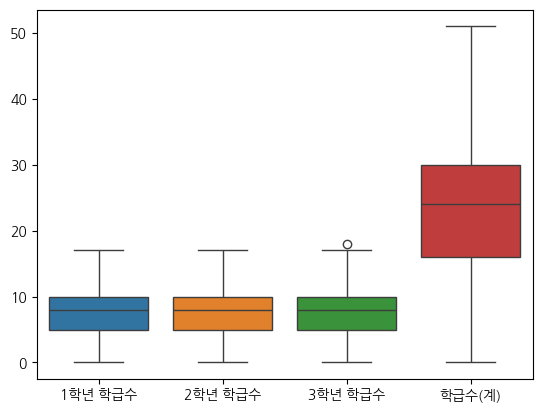

In [ ]:
plt.figure()
sns.boxplot(
    data=class_count
)

In [ ]:
# 중학교/고등학교별 테이블에 구분자 추가
raw_high_school['school_type'] = 'H'
raw_middle_school['school_type'] = 'M'

In [ ]:
# 중학교/고등학교 테이블 병합
raw_school_nationwide = pd.concat([raw_high_school, raw_middle_school])
raw_school_nationwide.columns

Index(['시도교육청', '교육지원청', '지역', '정보공시 학교코드', '학교명', '학교급코드', '설립구분', '제외여부',
       '제외사유', '1학년 학급수', '1학년 학생수', '1학년 학급당 학생수', '2학년 학급수', '2학년 학생수',
       '2학년 학급당 학생수', '3학년 학급수', '3학년 학생수', '3학년 학급당 학생수', '특수학급 학급수',
       '특수학급 학생수', '특수학급 학급당 학생수', '순회학급 학급수', '순회학급 학생수', '순회학급 학급당 학생수',
       '학급수(계)', '학생수(계)', '학급당 학생수(계)', '교사수', '수업교원 1인당 학생수', 'school_type'],
      dtype='object')

In [ ]:
# 필요한 컬럼만 추출
processed_school_nationwide = raw_school_nationwide[['지역', '학교명', '1학년 학급수', '1학년 학생수', '1학년 학급당 학생수', '2학년 학급수', '2학년 학생수',
       '2학년 학급당 학생수', '3학년 학급수', '3학년 학생수', '3학년 학급당 학생수', '학급수(계)', '학생수(계)', '학급당 학생수(계)']].copy()
processed_school_nationwide.head()

,지역,학교명,1학년 학급수,1학년 학생수,1학년 학급당 학생수,2학년 학급수,2학년 학생수,2학년 학급당 학생수,3학년 학급수,3학년 학생수,3학년 학급당 학생수,학급수(계),학생수(계),학급당 학생수(계)
0,서울특별시 강남구,국립국악고등학교,5,152,30.40,5,144,28.80,5,140,28.00,15,436,29.10
1,서울특별시 성북구,서울대학교사범대학부설고등학교,8,244,30.50,8,230,28.80,8,215,26.90,27,711,26.30
2,서울특별시 금천구,국립전통예술고등학교,6,181,30.20,6,174,29.00,6,163,27.20,18,518,28.80
3,서울특별시 송파구,가락고등학교,10,278,27.80,10,239,23.90,10,248,24.80,30,765,25.50
4,서울특별시 강동구,강동고등학교,8,254,31.80,8,225,28.10,8,193,24.10,24,672,28.00


In [ ]:
# 주소지 정리
print(f'내부데이터 학교 주소지: {accounts_school['address_clean'].nunique()}')
print(f'외부데이터 학교 주소지: {processed_school_nationwide['지역'].nunique()}')

내부데이터 학교 주소지: 276
외부데이터 학교 주소지: 255


In [ ]:
# 고유 주소지 리스트 생성
inner_addr = set(accounts_school['address_clean'].unique())
outer_addr = set(processed_school_nationwide['지역'].unique())

# 내부 데이터에만 있는 주소지
only_inner = sorted(list(inner_addr - outer_addr))
print(f'내부에만 있는 지역 ({len(only_inner)}개): {only_inner}')

# 외부 데이터에만 있는 주소지
only_outer = sorted(list(outer_addr - inner_addr))
print(f'\n외부에만 있는 지역 ({len(only_outer)}개): {only_outer}')

내부에만 있는 지역 (62개): ['강원도 강릉시', '강원도 고성군', '강원도 동해시', '강원도 삼척시', '강원도 속초시', '강원도 양구군', '강원도 양양군', '강원도 영월군', '강원도 원주시', '강원도 인제군', '강원도 정선군', '강원도 철원군', '강원도 춘천시', '강원도 태백시', '강원도 평창군', '강원도 홍천군', '강원도 화천군', '강원도 횡성군', '강원도정선군', '경기도 부천시', '경기도 화성시', '경기도군포시', '경기도용인시 기흥구', '경기도용인시 수지구', '경기도의왕시', '경기도하남시', '경상남도진주시', '경상남도창원시 마산합포구', '경상남도창원시 의창구', '경상남도창원시 진해구', '경상북도 군위군', '경상북도김천시', '경상북도영양군', '경상북도의성군', '대구광역시수성구', '서울특별시광진구', '서울특별시노원구', '서울특별시동대문구', '서울특별시마포구', '서울특별시서대문구', '인천광역시남동구', '전라북도 고창군', '전라북도 군산시', '전라북도 김제시', '전라북도 남원시', '전라북도 무주군', '전라북도 부안군', '전라북도 순창군', '전라북도 완주군', '전라북도 익산시', '전라북도 임실군', '전라북도 장수군', '전라북도 전주시 덕진구', '전라북도 전주시 완산구', '전라북도 정읍시', '전라북도 진안군', '전라북도정읍시', '제주특별자치도서귀포시', '충청남도 세종특별자치시', '충청남도서산시', '충청남도아산시', '충청남도천안시 동남구']

외부에만 있는 지역 (41개): ['강원특별자치도 강릉시', '강원특별자치도 고성군', '강원특별자치도 동해시', '강원특별자치도 삼척시', '강원특별자치도 속초시', '강원특별자치도 양구군', '강원특별자치도 양양군', '강원특별자치도 영월군', '강원특별자치도 원주시', '강원특별자치도 인제군', '강원특별자치도 정선군', '강원특별자치도 철원군', '강원특별자치도 춘천시', '강원특별자치도 태백시', '강원특별자치

In [ ]:
# 굿 제미나이.
def clean_address(addr):
    if pd.isna(addr): return addr
    
    # 1. 기본적인 오타 및 붙여쓰기 보정 (띄어쓰기 한 칸으로 통일)
    # '경기도용인시' -> '경기도 용인시' 형태가 되도록 주요 도/시 뒤에 공백 추가
    target_cities = ['강원도', '경기도', '경상남도', '경상북도', '전라남도', '전라북도', '충청남도', '충청북도', 
                     '제주특별자치도', '서울특별시', '대구광역시', '인천광역시', '광주광역시', '대전광역시', '울산광역시', '세종특별자치시']
    
    for city in target_cities:
        if addr.startswith(city) and not addr.startswith(city + ' '):
            addr = addr.replace(city, city + ' ')

    # 2. 행정구역 명칭 변경 업데이트 (최신 기준)
    addr = addr.replace('강원도 ', '강원특별자치도 ')
    addr = addr.replace('전라북도 ', '전북특별자치도 ')
    addr = addr.replace('경상북도 군위군', '대구광역시 군위군')
    addr = addr.replace('충청남도 세종특별자치시', '세종특별자치시')
    
    # 3. 상세 구(區) 단위 제거 (외부 데이터와 수준 맞추기)
    # 예: '전주시 덕진구' -> '전주시', '부천시 원미구' -> '부천시'
    # 데이터 상황에 따라 구 단위까지 맞출지, 시 단위로 자를지 결정해야 합니다.
    # 여기서는 외부 데이터의 '세종특별자치시' 등을 고려해 시/군 단위까지만 남기는 로직입니다.
    parts = addr.split()
    if len(parts) > 2:
        # 도/시 + 시/군 까지만 합침 (구 단위 버림)
        return parts[0] + ' ' + parts[1]
    
    return ' '.join(parts)

# 내부 데이터에 적용
accounts_school['address_fixed'] = accounts_school['address_clean'].apply(clean_address)

# 외부 데이터도 동일하게 시/군 단위로 정리 (비교를 위해)
processed_school_nationwide['지역_fixed'] = processed_school_nationwide['지역'].apply(lambda x: ' '.join(x.split()[:2]) if pd.notna(x) else x)

In [ ]:
# 내용 검토

# 고유 주소지 리스트 생성
inner_addr = set(accounts_school['address_fixed'].unique())
outer_addr = set(processed_school_nationwide['지역_fixed'].unique())

# 내부 데이터에만 있는 주소지
only_inner = sorted(list(inner_addr - outer_addr))
print(f'내부에만 있는 지역 ({len(only_inner)}개): {only_inner}')

# 외부 데이터에만 있는 주소지
only_outer = sorted(list(outer_addr - inner_addr))
print(f'\n외부에만 있는 지역 ({len(only_outer)}개): {only_outer}')

내부에만 있는 지역 (0개): []

외부에만 있는 지역 (0개): []


In [ ]:
accounts_school.head()

,school_id,student_count,school_type,address_clean,is_active_school,address_fixed
0,4,239,H,충청북도 충주시,True,충청북도 충주시
1,5,160,M,충청북도 충주시,True,충청북도 충주시
2,6,200,H,충청북도 충주시,True,충청북도 충주시
3,7,114,H,충청북도 충주시,True,충청북도 충주시
4,8,139,M,충청북도 충주시,True,충청북도 충주시


In [25]:
# 불필요하게 중복된 컬럼 삭제
accounts_school.drop(columns=['address_clean'], inplace=True)
accounts_school.rename(columns={'address_fixed': 'address'}, inplace=True)

In [ ]:
processed_school_nationwide.drop(columns=['지역'], inplace=True)
processed_school_nationwide.rename(columns={'지역_fixed': 'address'}, inplace=True)

In [ ]:
processed_school_nationwide.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4758 entries, 0 to 2378
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   학교명          4758 non-null   object 
 1   1학년 학급수      4758 non-null   int64  
 2   1학년 학생수      4758 non-null   int64  
 3   1학년 학급당 학생수  4758 non-null   float64
 4   2학년 학급수      4758 non-null   int64  
 5   2학년 학생수      4758 non-null   int64  
 6   2학년 학급당 학생수  4758 non-null   float64
 7   3학년 학급수      4758 non-null   int64  
 8   3학년 학생수      4758 non-null   int64  
 9   3학년 학급당 학생수  4758 non-null   float64
 10  학급수(계)       4758 non-null   int64  
 11  학생수(계)       4758 non-null   int64  
 12  학급당 학생수(계)   4758 non-null   float64
 13  address      4758 non-null   object 
dtypes: float64(4), int64(8), object(2)
memory usage: 557.6+ KB


In [ ]:
print(f'내부 주소 고유값: {accounts_school['address'].nunique()}')
print(f'외부 주소 고유값: {processed_school_nationwide['address'].nunique()}')

외부 주소 고유값: 229
내부 주소 고유값: 229


In [ ]:
# 외부데이터를 일반 중/고등학교 자료만 확보함.
print(f'내부 학교 개수: {len(accounts_school['school_id'])}')
print(f'외부 학교 개수: {len(processed_school_nationwide['학교명'])}')

내부 학교 개수: 5948
외부 학교 개수: 4758


- 일반 중/고등학교로 등록된 학교 자료만 수집함
    - 제외 학교 목록
    - 특수학교(특수교육 대상자(장애 학생)에게 전문적인 맞춤형 교육을 제공하는 학교)
    - 각종 학교(정규 학교(초·중·고)와 유사한 교육과정을 운영하는 인가 학교)
    - 기타 학교(고등공민학교, 기술학교 등 법령상 정규 교육과정 외 특별한 목적으로 운영되는 학교)
- 내부 학교 개수가 더 많은 이유는 학급에서 20반 등의 이상치가 있었기 때문

### 2) 추천에 의한 노출

In [28]:
accounts_user_contacts.head()

,user_id,contacts_count,invite_user_id_list,invite_count
0,1167696,30,[],0
1,863169,79,[],0
2,857205,21,[854615],1
3,851431,29,[],0
4,855476,28,[849318],1


In [29]:
accounts_user_contacts.describe()

,contacts_count,invite_count
count,5063.00,5063.00
mean,25.99,0.33
std,13.60,0.75
min,0.00,0.00
25%,16.00,0.00
50%,24.00,0.00
75%,34.00,0.00
max,114.00,10.00


In [30]:
# 초대를 보낸 유저의 고유값
inviters = accounts_user_contacts['invite_user_id_list'].sum()
inviter_list = list(set(inviters))
len(inviter_list)

1122

In [31]:
type(inviter_list)

list

In [32]:
accounts_user_contacts[accounts_user_contacts['user_id'].isin(inviter_list)]

,user_id,contacts_count,invite_user_id_list,invite_count


In [ ]:
inviters = pd.Series(inviters)
print(f'초대를 보냈던(받았던) 전체 집계: {accounts_user_contacts['invite_count'].sum()}건')
print(f'초대를 가장 많이 보낸 top10\n{inviters.value_counts().head(10)}')
print(f'한 명이 보낸 초대의 평균: {inviters.value_counts().mean():.2f}')

초대를 보냈던(받았던) 전체 집계: 1687건
초대를 가장 많이 보낸 top10
1154585    21
1233225    17
883602     16
1041381    14
873001     14
885409     10
1417159     9
883507      9
1062378     9
1210380     8
Name: count, dtype: int64
한 명이 보낸 초대의 평균: 1.50


In [34]:
# 유저당 초대받았던 기록의 합계
accounts_user_contacts['invite_count'].sum()

np.int64(1687)

In [35]:
# 이 유저의 연락처를 가지고있는 사람들 중 실제로 초대를 받은 비율
invite_ratio = accounts_user_contacts['invite_count'] / accounts_user_contacts['contacts_count'] * 100
invite_ratio.describe()

count   5060.00
mean       1.21
std        3.06
min        0.00
25%        0.00
50%        0.00
75%        0.00
max      100.00
dtype: float64

In [36]:
# 100%가 어케나와요
accounts_user_contacts.iloc[invite_ratio.idxmax()]

user_id                  945228
contacts_count                1
invite_user_id_list    [887254]
invite_count                  1
Name: 2753, dtype: object

In [37]:
invite_ratio.value_counts().sort_index()
# 전체 5063명 중 연락처 대비 초대수가 없거나, 초대를 받지 않은 유저는 3902명, 이상치(100%)는 1명

0.00      3902
0.93         1
1.32         1
1.35         2
1.43         1
          ... 
22.73        1
24.32        1
25.00        1
37.50        1
100.00       1
Name: count, Length: 143, dtype: int64

In [38]:
invite_ratio[invite_ratio > 0].reset_index()

,index,0
0,2,4.76
1,4,3.57
2,5,3.23
3,6,4.44
4,8,11.54
...,...,...
1153,5014,5.26
1154,5029,5.26
1155,5044,9.09
1156,5045,12.50


In [39]:
invite_ratio.head()

0   0.00
1   0.00
2   4.76
3   0.00
4   3.57
dtype: float64

In [ ]:
inviter_count = accounts_user_contacts['user_id'].nunique() # 초대 테이블에 있는 전체 유저
invited_count = invite_ratio[invite_ratio > 0] # 초대 테이블에 있는 전체 유저 중 초대받은 기록이 없는 유저
inviter_outlier_count = len(invite_ratio[invite_ratio > 50]) # 초대받은 기록이 50% 이상은 이상치로 간주
print(f'초대를 받았던 유저 비율: {len(invited_count) / (inviter_count - inviter_outlier_count) * 100:.2f}')
print(f'초대를 받은?\n{invited_count}')

초대를 받았던 유저 비율: 22.88
초대를 받은?
2       4.76
4       3.57
5       3.23
6       4.44
8      11.54
        ... 
5014    5.26
5029    5.26
5044    9.09
5045   12.50
5046    9.09
Length: 1158, dtype: float64


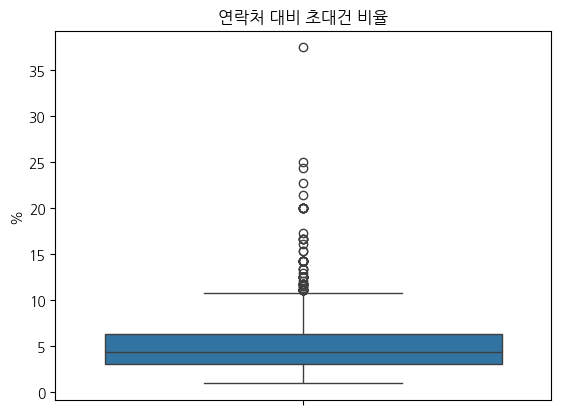

In [41]:
# 50% 이상: 이상치,0%: 결측치로 정의, 제외하고 그래프 확인
invite_condition = (invite_ratio > 0) & (invite_ratio <= 50)
plt.figure()
sns.boxplot(
    data=invite_ratio[invite_condition]
)
plt.title('연락처 대비 초대건 비율')
plt.ylabel('%')
plt.show()

In [ ]:
# 연락처 대비 초대건 비율의 평균을 5%로 계산
print(f'한 사람당 가지고 있는 연락처의 평균 중 초대하는 사람 수: {(accounts_user_contacts['contacts_count'].mean()) * 0.05:.2f}')
print(f'유저의 전체 연락처 중 초대 가능성이 있는 수: {(accounts_user_contacts['contacts_count'].sum()) * 0.05 * ((5059 - 3902) / 5059):.2f}')
# 한 사람 당 평균 1.3명 초대한다고 볼 수 있음
# 약간 1+1 느낌이네

한 사람당 가지고 있는 연락처의 평균 중 초대하는 사람 수: 1.30
유저의 전체 연락처 중 초대 가능성이 있는 수: 1504.49


- 데이터(테이블) 설명
    - 전화번호를 기준으로 해당 전화번호를 가지고있는 유저의 수와 해당 전화번호에게 친구 초대를 보냈던 유저에 대한 기록이 있는 테이블
    - 개인정보 보호를 위해 전화번호에 대한 컬럼은 삭제되어있고, 해당 전화번호를 등록한 유저 아이디가 연계되어있음.
    - 따라서 이 유저 아이디를 이 전화번호의 고유값으로 대체 할 수 있음
- 유저 집계
    - 초대테이블 유저의 고유값은 5067명
    - 그 중 초대를 1번 이상 받았던건 1158명(전체 중 약 22.88%)
    - 초대를 보낸 유저는 1122명
    - 초대를 보냈던 유저 아이디 =/= 초대를 받은 유저 아이디 -> 한 명도 일치하지 않음.
- 초대에 대한 집계
    - 합계: 1687건
    - 한 명이 보낸 최대 초대 횟수: 21회
    - 초대 발송 평균: 약 1.5회
- 보낸 사람와 받은 사람의 비율이 거의 1:1이고, 한명도 겹치지 않기 때문에 초대를 받은 사람만큼 초대를 보낸 사람이 있을 수 있다고 판단
- 초대 발송 평균 횟수는 1.5회, 초대를 받았던건 전체(약 5천명) 중 약 23%, 유저 테이블의 전체 수는 약 67만명
- 친구 초대로 인한 노출 정도 = (67만 명 * 23%) * 1.5 회 = 약 23만 건의 노출 가능성이 있다.

### 3) 오프라인(학교 내) 노출

- 오프라인(학교 내) 노출의 경우 전국 중/고등학교의 학생 수와 학교 관련 테이블을 비교하여
- 학교별(중/고등학교로만 구분), 지역별 활성도를 파악
- 활성도에 따른 노출도 추정

In [ ]:
accounts_school.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5948 entries, 0 to 5950
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   school_id         5948 non-null   object
 1   student_count     5948 non-null   int64 
 2   school_type       5948 non-null   object
 3   is_active_school  5948 non-null   bool  
 4   address           5948 non-null   object
dtypes: bool(1), int64(1), object(3)
memory usage: 238.2+ KB


In [ ]:
processed_school_nationwide.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4758 entries, 0 to 2378
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   학교명          4758 non-null   object 
 1   1학년 학급수      4758 non-null   int64  
 2   1학년 학생수      4758 non-null   int64  
 3   1학년 학급당 학생수  4758 non-null   float64
 4   2학년 학급수      4758 non-null   int64  
 5   2학년 학생수      4758 non-null   int64  
 6   2학년 학급당 학생수  4758 non-null   float64
 7   3학년 학급수      4758 non-null   int64  
 8   3학년 학생수      4758 non-null   int64  
 9   3학년 학급당 학생수  4758 non-null   float64
 10  학급수(계)       4758 non-null   int64  
 11  학생수(계)       4758 non-null   int64  
 12  학급당 학생수(계)   4758 non-null   float64
 13  address      4758 non-null   object 
dtypes: float64(4), int64(8), object(2)
memory usage: 557.6+ KB


In [ ]:
# 내부데이터와 외부데이터 병합
inner_school_count = accounts_school.groupby('address').agg(total_count=('student_count', 'sum')).reset_index()
outer_school_count = processed_school_nationwide.groupby('address').agg(total_count=('학생수(계)', 'sum')).reset_index()
total_school_count = pd.merge(inner_school_count, outer_school_count, on='address')

total_school_count.rename(columns={'total_count_x': 'inner_count', 'total_count_y':'outer_count'}, inplace=True) # 컬럼명 수정
total_school_count['ratio'] = round(total_school_count['inner_count'] / total_school_count['outer_count'] * 100, 2) # 비율 컬럼 추가
total_school_count['city'] = total_school_count['address'].str.split().str[0] # 대분류용 도시별 컬럼 추가

total_school_count.head()

,address,inner_count,outer_count,ratio,city
0,강원특별자치도 강릉시,3117,10132,30.76,강원특별자치도
1,강원특별자치도 고성군,200,784,25.51,강원특별자치도
2,강원특별자치도 동해시,1962,4660,42.10,강원특별자치도
3,강원특별자치도 삼척시,377,2704,13.94,강원특별자치도
4,강원특별자치도 속초시,1064,3786,28.10,강원특별자치도


In [ ]:
# 도시별 학생 수 집계
total_school_city_count = total_school_count.groupby('city')[['inner_count', 'outer_count']].sum().reset_index()
total_school_city_count['ratio'] = round(total_school_city_count['inner_count'] / total_school_city_count['outer_count'] * 100, 2)
total_school_city_count.sort_values('ratio', ascending=False, inplace=True)
total_school_city_count.head()

,city,inner_count,outer_count,ratio
13,전북특별자치도,34449,96490,35.70
12,전라남도,31564,90512,34.87
10,울산광역시,19950,60686,32.87
9,세종특별자치시,7700,24888,30.94
15,충청남도,35097,114686,30.60


In [ ]:
total_school_city_count.describe()

,inner_count,outer_count,ratio
count,17.00,17.00,17.00
mean,39827.00,150335.65,27.76
std,42135.57,164987.99,4.99
min,6508.00,24888.00,17.51
25%,19950.00,78026.00,25.30
50%,31564.00,96490.00,28.05
75%,41086.00,140014.00,30.60
max,191688.00,698242.00,35.70


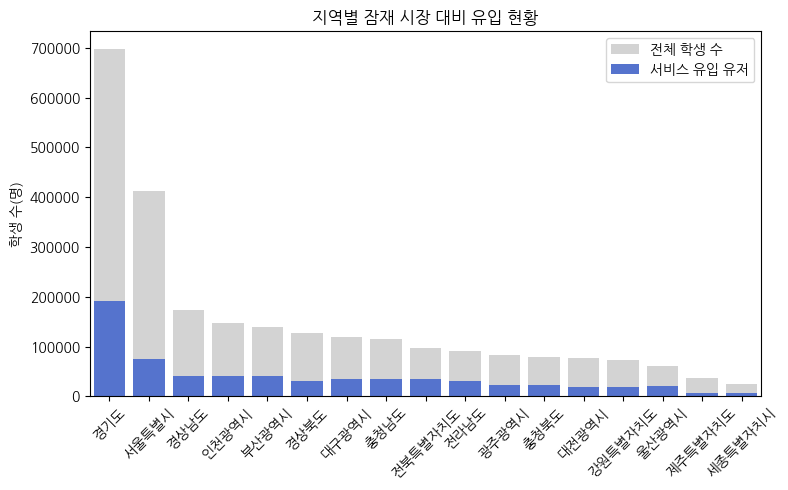

In [ ]:
count_sorted = total_school_city_count.sort_values('outer_count', ascending=False)
city_order = count_sorted['city'].tolist()

plt.figure(figsize=(8, 5))

# 외부 데이터 (배경 - 연한 색)
sns.barplot(
    data=count_sorted, 
    x='city', 
    y='outer_count', 
    order=city_order, 
    color='lightgrey', 
    label='전체 학생 수', 
    errorbar=None)

# 내부 데이터 (앞쪽 - 강조 색)
sns.barplot(
    data=count_sorted, 
    x='city', 
    y='inner_count', 
    order=city_order, 
    color='royalblue', 
    label='서비스 유입 유저', 
    errorbar=None)

plt.title('지역별 잠재 시장 대비 유입 현황',)
plt.xlabel('')
plt.ylabel('학생 수(명)')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

- 외부데이터를 2023년 기준으로 다운받았는데 내부데이터 날짜 없긴 함
- 다른 내부데이터 날짜들이 230428 ~ 240508 인데 .. 2024년도 받아서 평균을 내야하나?
    - 아니면 한 학년 기준이 23년 3월 ~ 24년 2월이니까 그냥 둬도 될까?

In [ ]:
processed_school_nationwide.describe()

,1학년 학급수,1학년 학생수,1학년 학급당 학생수,2학년 학급수,2학년 학생수,2학년 학급당 학생수,3학년 학급수,3학년 학생수,3학년 학급당 학생수,학급수(계),학생수(계),학급당 학생수(계)
count,4758.00,4758.00,4758.00,4758.00,4758.00,4758.00,4758.00,4758.00,4758.00,4758.00,4758.00,4758.00
mean,7.66,195.11,23.99,7.50,172.99,21.64,7.46,164.54,20.77,23.45,537.14,21.60
std,3.27,105.26,5.78,3.23,95.39,5.76,3.21,89.28,5.49,9.83,287.65,5.31
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,5.00,111.00,20.40,5.00,98.00,18.32,5.00,96.00,17.90,16.00,312.00,18.40
50%,8.00,195.00,24.50,8.00,174.00,22.00,8.00,166.00,21.20,24.00,542.00,21.90
75%,10.00,272.00,27.80,10.00,241.00,25.30,10.00,228.00,24.10,30.00,742.75,25.10
max,17.00,505.00,40.50,17.00,508.00,40.50,18.00,413.00,40.50,51.00,1349.00,40.30


- '거점 학교' 중심의 간접 노출 계산 (Network Effect)
- 오프라인(학교)에서는 우리 서비스 유저 한 명이 주변 친구들에게 앱을 노출시키는 '네트워크 효과'가 발생
- 논리: "우리 서비스 유저 1명이 같은 반/학교 학생 N명에게 앱을 시각적으로 노출시킨다"고 가정
- 계산식: 지역별 inner_count 오프라인 노출 상수(k)예를 들어, 같은 반 학생들을 노출 대상으로 보고 k=10 정도로 설정한다면, 경기도의 경우 약 20만 명의 유저가 200만 명에게 노출을 발생
- 인사이트: 침투율(ratio)이 높은 전북(35.7%)이나 전남(34.8%) 같은 지역은 학교 내에서 3명 중 1명이 유저이므로, 사실상 해당 지역의 모든 학생에게 노출(노출률 100%)되었다고 주장할 수 있는 근거

- 학급당 학생 평균 21명, 이 중 28%는 약 6명
- 온라인 노출에 대해 유저 한 명당 해당 연락처를 보유하고 있는 사람은 평균 26명이었으므로, 노출상수를 보수적으로 계산했을때 k=10 으로 설정

In [ ]:
(total_school_city_count['inner_count'] * 2.6).mean() * len(total_school_city_count['city'])

np.float64(1760353.4000000001)

- 내부 데이터(테이블) 설명
    - 유저가 등록한 학교 및 학급에 대한 정보가 기록된 테이블
    - 개인정보 보호를 위해 정확한 학교 명은 삭제되어있고, 해당 학교의 고유번호와 대략적인 주소지, 같은 학교로 등록된 학생 수가 집계되어있음.
- 외부 데이터 설명
    - 교육부에서 공시하는 '학교 알리미'라는 사이트를 통해 2023년 전국의 지역별 중/고등학교의 학생 수에 대한 데이터 확보
    - 전국의 학생 수와 서비스 내 유저의 수를 지역별로 집계하고 비교하여 이 서비스의 활성도를 계산 할 수 있음
- 학생 수 집계
    - 내부/외부 데이터의 지역들을 광역자치단체를 기준으로 구분하여 지리적 세그먼트를 설정해 집계했다.
    - 내부 데이터 중 지역별 학생 수 평균은 약 4만명, 가장 적은 지역은 제주특별자치도의 약 6천 5백명이고 가장 많은 지역은 경기도의 약 19만명이다.
    - 외부 데이터 중 지역별 학생 수 평균은 약 15만명, 가장 적은 지역은 세종특별자치시의 약 2만 5천명, 다음으로 적은 지역은 제주특별자치도의 약 3만 7천명이다. 그리고 가장 많은 지역은 경기도의 약 70만명이다.
- 활성도 집계
    - 지역별 활성도 평균은 약 27.76%, 지역별 활성도가 가장 높은 지역은 전라북도 35.7%, 전라남도 34.9%로 전라도 지역이 가장 높은 것으로 나타났다. 이는 해당 지역 내 학교를 거점으로 한 네트워크 전파가 가장 활발하게 이루어졌음을 시사한다. 반면 가장 낮은 지역은 제주특별자치도가 17.5%로, 전체 학생 규모가 적어 초기 확산 속도가 완만했을 수 있으며, 지리적 특성상 타 지역과의 네트워크 교류가 단절되어 활성도가 낮게 나타난 것으로 풀이된다. 그 다음으로 활성도가 낮은 지역은 서울특별시가 18.1%였으며, 활성도 평균 28%를 크게 하회하는 낮은 활성도를 보였다. 서울 지역의 낮은 활성도는 두 가지 측면에서 해석이 가능하다. 첫째, 학생 밀집도는 높으나 타 지역 대비 학업 몰입도가 높은 환경적 특성상 학생 간 커뮤니티 활동이 상대적으로 제한적일 가능성이 있다. 둘째, 풍부한 인프라를 바탕으로 한 대체 콘텐츠가 많아 서비스에 대한 집중도가 분산된 결과로 풀이된다. 따라서 서울과 같은 대도시 권역은 단순 노출을 넘어선 강력한 참여 유인책이 더욱 절실한 지역임을 시사한다.
- 노출도 계산
    - 오프라인(학교)에서는 이 서비스 유저 한 명이 주변 친구들에게 앱을 노출시키는 '네트워크 효과'가 발생 할 수 있다. 노출도 계산식은 다음과 같이 정의했다. 노출도 = 지역별 유저 수 x 오프라인 노출 상수(k)
    - 도달 범위(계산1)
        - "우리 서비스 유저 1명이 주변의 미가입자에게 앱을 노출시킨다"고 가정했을 때, 학교알리미에 공시된 2023년 전국 중/고등학교 학급 당 평균 인원은 21.6명이므로 지역별 활성도 평균인 약 27.76%를 계산하면 한 학급당 약 6명의 학생들이 이 서비스를 이용하고 있는 것으로 볼 수 있다. 이 내용을 바탕으로 노출 상수 계산식을 k = (학급 평균 인원 - 학급당 평균 유저 수) / 학급당 평균 유저수 로 계산하면 k=(21.6-6)/6 = 약 2.6이 된다. 따라서 노출도는 67만 명 x 2.6 명 = 약 176만 명으로, 전체 학생 시장의 약 68%에게 도달했다고 볼 수 있다.
    - 총 노출량(계산2)
        - 이 서비스는 학교 당 40명, 학급당 4명 이상이 모여야 활성화되는 특징이 있고, 학급 당 평균 인원이 21.6명이라는 점에서 4명의 유저는 학급 당 약 25%를 차지하므로 학급당 4명만 모여도 해당 학급 전체에 서비스가 인지(노출)되었다고 간주 할 수 있다. 한 학급 당 평균 6명의 학생이 이 서비스를 이용하고 있다는 계산이 있기때문에 대부분의 학급에 노출 되었다고 볼 수 있다. 또한 1명의 학생이 하루에도 여러 명의 친구를 통해 이 서비스에 반복해서 노출 될 수 있기 때문에, 노출 상수의 최소값은 해당 학급 전체에 서비스가 노출되었다는 전제와 학급 활성화 조건의 최소값인 4명을 근거로 계산하여 21.6(평균 학급 인원)/4(활성화 조건 인원) = 5.4 회, 최대값은 온라인 노출 계산에서 연락처 수(26명)를 통해 확인된 유저의 잠재적 네트워크 영향력을 오프라인에 투영하되, 반복 노출 빈도를 고려해 보수적으로 계산하여 10 회 정도로 설정했다. 여기에 학교에 매일 출석하는 학생들의 특성까지 고려했을 때 일일 총 노출량은 362만 회 ~ 670만 회 라고 추산 할 수 있다.

- 이와 같이 이 이미 해당 서비스에 대한 충분한 인지가 형성되었음에도 불구하고 활성화 비율이 전체 유입 인원 대비 약 44.58%에 그친 것은 유입 이후 유저를 묶어둘 강력한 참여 트리거가 부족하여 학교/학급 별 활성화 단계로 넘어가지 못한 것으로 해석된다.

## 7-2. 참여 유저 패턴 분석

In [68]:
sns.set_palette('pastel')
passive_color = sns.color_palette('pastel')[0]
active_color = sns.color_palette('pastel')[1]

### 1) 질문

In [41]:
# created_at부터 answer_updated_at까지 걸린 기간을 구하려고 함 -> 마이너스가 될만한 요소가 있나? -> 있음!!
# 마이너스 요소들 파악, 분석, 처리방법 필요!

# created_at보다 answer_updated_at가 더 빠른 건 뭐지
# 질문을 먼저 한 다음 답변하면 answer_updated_at가 느리고,
# 답변하지 않으면 answer_updated_at와 같아야 하는데
# 빠른 애들은 오류인가? -> 534개로 극소수이긴 함 -> 0.1%

columns = ['question_id', 'status', 'created_at', 'chosen_user_id', 'user_id', 'has_read', 'answer_status', 'answer_updated_at', 'report_count', 'opened_times']

same_answer = question[question['answer_updated_at'] == question['created_at']][columns] # 377,186개
late_answer = question[question['answer_updated_at'] > question['created_at']][columns] # 50,175개
fast_answer = question[question['answer_updated_at'] < question['created_at']][columns] # 534개

fast_answer

,question_id,status,created_at,chosen_user_id,user_id,has_read,answer_status,answer_updated_at,report_count,opened_times
416099,31743978,C,2023-05-13 08:35:51,1108505,1189500,0,N,2023-05-13 08:35:50,0,0
423450,32705831,C,2023-05-13 11:34:55,1151668,1189770,0,N,2023-05-13 11:34:54,0,0
441956,35077126,C,2023-05-13 17:39:20,841576,1193797,1,N,2023-05-13 17:39:19,0,0
448400,35894054,C,2023-05-13 19:33:14,1142998,1187024,1,N,2023-05-13 19:33:13,0,0
465308,37903579,C,2023-05-13 23:12:09,1208433,1216746,0,N,2023-05-13 23:12:08,0,0
...,...,...,...,...,...,...,...,...,...,...
1211969,160180544,C,2023-07-29 20:40:22,1003443,1301546,1,N,2023-07-29 20:40:21,0,0
1212752,160448124,C,2023-08-06 19:39:11,1425732,1436724,0,N,2023-08-06 19:39:10,0,0
1212895,160500919,C,2023-08-07 19:29:12,1511957,1512864,0,N,2023-08-07 19:29:11,0,0
1213116,160550974,C,2023-08-09 16:29:24,1284139,1214735,1,N,2023-08-09 16:29:23,0,0


In [42]:
late_answer['answer_status'].value_counts().reset_index()

,answer_status,count
0,A,46463
1,P,3712


In [43]:
# answer_status가 답변만 있는 것과
# has_read가 1만 있는 것으로 보아
# created_at보다 answer_updated_at가 늦은건
# 확실하게 채팅을 열은 것

late_answer['has_read'].value_counts().reset_index()

,has_read,count
0,1,50175


In [44]:
# answer_status가 미답변만 있는 것으로 보아
# created_at와 answer_updated_at가 같은건
# 확실하게 채팅한 적이 없어서 투표 기록시간과 같은 거로 찍힌 것
same_answer['answer_status'].value_counts().reset_index()

,answer_status,count
0,N,377186


In [ ]:
same_answer['has_read'].value_counts().reset_index()

,has_read,count
0,1,217279
1,0,159907


In [45]:
# 얘넨 뭘까
# 시간 차이를 봐야겠음
fast_answer['answer_status'].value_counts().reset_index()

,answer_status,count
0,N,534


In [ ]:
# 정리하면,
# 채팅을 활발하게 진행한 것들은 answer_updated_at가 created_at보다 느림
# created_at부터 answer_updated_at까지 걸린 기간은
# 절대값으로 평균 보면 될 듯

fast_answer['has_read'].value_counts().reset_index()

,has_read,count
0,1,305
1,0,229


In [49]:
# created_at와 다 1초밖에 차이 안 남
# 오류로 인한 타임 기록이라고 봐도 되지 않을까
# 그리고 1초 차이 이므로 얘네들은 created_at = answer_updated_at로 봐도
# 계산 오차가 크지 않을 듯
fast_answer['diff'] = fast_answer['created_at'] - fast_answer['answer_updated_at']
fast_answer['diff'].value_counts().reset_index()

,diff,count
0,0 days 00:00:01,534


In [50]:
question_time_diff = question[columns]
question_time_diff['diff'] = question_time_diff['answer_updated_at'] - question_time_diff['created_at']

# diff가 마이너스인 애들은 오류인 애들
# 0으로 치환해줌 
question_time_diff.loc[question_time_diff['diff'] < pd.Timedelta(0), 'diff'] = pd.Timedelta(0)
question_time_diff[question_time_diff['diff'] < pd.Timedelta(0)]

,question_id,status,created_at,chosen_user_id,user_id,has_read,answer_status,answer_updated_at,report_count,opened_times,diff


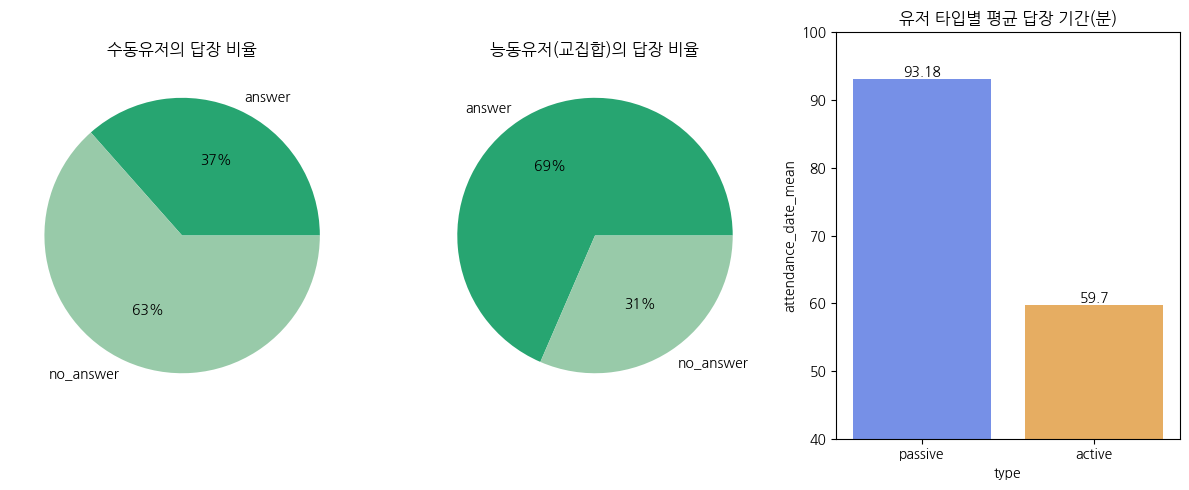

In [ ]:
passive_time_diff = question_time_diff[question_time_diff['chosen_user_id'].isin(passive_user)]
intersection_time_diff = question_time_diff[question_time_diff['chosen_user_id'].isin(intersection_user)]

passive_time_diff_mean = passive_time_diff.groupby('chosen_user_id')['diff'].mean().reset_index()
intersection_time_diff_mean = intersection_time_diff.groupby('chosen_user_id')['diff'].mean().reset_index()

# 평균값이 0일인 유저들 diff 타입 설정
passive_time_diff_mean.loc[passive_time_diff_mean['diff'] <= pd.Timedelta(0), 'diff_type'] = 'no_answer'
passive_time_diff_mean['diff_type'].fillna('answer', inplace=True)
intersection_time_diff_mean.loc[intersection_time_diff_mean['diff'] <= pd.Timedelta(0), 'diff_type'] = 'no_answer'
intersection_time_diff_mean['diff_type'].fillna('answer', inplace=True)

# 그래프 그리기 쉽게 df 수정
passive_diff_counts = passive_time_diff_mean['diff_type'].value_counts().reset_index().sort_values(by='diff_type')
intersection_diff_counts = intersection_time_diff_mean['diff_type'].value_counts().reset_index().sort_values(by='diff_type')
diff_mean = pd.DataFrame({
    'type': ['passive', 'active'],
    'attendance_date_mean': [round(passive_time_diff_mean['diff'].mean().total_seconds() / 60, 2), 
                             round(intersection_time_diff_mean['diff'].mean().total_seconds() / 60, 2)]
})

diff_type_colors = ['#27A571', '#98caa9']
color_map = ['#6386fa', '#fcb04c']

fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].pie(x=passive_diff_counts['count'], labels=passive_diff_counts['diff_type'], autopct='%.f%%', colors=diff_type_colors)
ax[1].pie(x=intersection_diff_counts['count'], labels=intersection_diff_counts['diff_type'], autopct='%.f%%', colors=diff_type_colors)
ax[2] = sns.barplot(data=diff_mean, x='type', y='attendance_date_mean', hue='type', palette=color_map, ax=ax[2])

ax[2].bar_label(ax[2].containers[0], fontsize=10)
ax[2].bar_label(ax[2].containers[1], fontsize=10)
ax[2].set_ylim(40, 100)

ax[0].set_title('수동유저의 답장 비율')
ax[1].set_title('능동유저(교집합)의 답장 비율')
ax[2].set_title('유저 타입별 평균 답장 기간(분)') # 투표된 시점으로부터 답장까지

# 어차피 능동유저의 98%가 넘는 비율이 교집합 유저이기도 함
plt.tight_layout()
plt.show()

In [52]:
diff_mean

,type,attendance_date_mean
0,passive,93.18
1,active,59.70


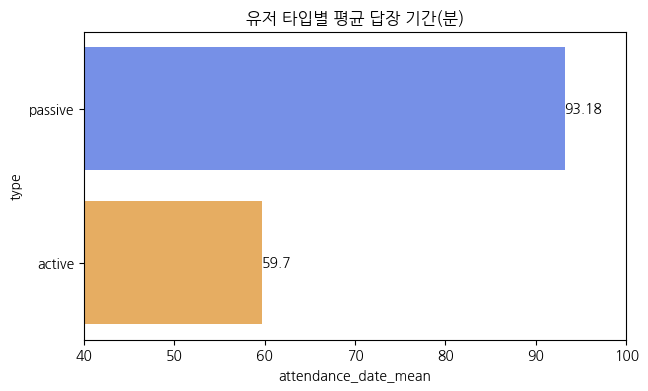

In [53]:
# 보고서용 임시 그래프
fig, ax = plt.subplots(figsize=(7, 4))
ax = sns.barplot(data=diff_mean, x='attendance_date_mean', y='type', hue='type', palette=color_map)
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.set_xlim(40, 100)
ax.set_title('유저 타입별 평균 답장 기간(분)')
plt.show()

In [54]:
passive_question = question[question['chosen_user_id'].isin(passive_user)]
active_question = question[question['user_id'].isin(active_user)]

passive_question_describe = passive_question['chosen_user_id'].value_counts().reset_index()
passive_question_describe = passive_question_describe['count'].describe().reset_index(name='passive_question_counts')

active_question_describe = active_question['user_id'].value_counts().reset_index()
active_question_describe = active_question_describe['count'].describe().reset_index(name='active_question_counts')

# 최대 몇 번이나 투표 받거나 했나 -> 능동유저: 892번 / 능동유저: 1695번 -> 인싸네..
# 한 사람 당 평균적으로 투표에 관여된 횟수 ->  수동유저: 약 26번 / 능동유저: 약 251번
total_question_describe = pd.merge(passive_question_describe, active_question_describe, on='index', how='left')
total_question_describe

,index,passive_question_counts,active_question_counts
0,count,4390.00,1705.00
1,mean,26.49,250.96
2,std,47.04,234.27
3,min,1.00,1.00
4,25%,3.00,87.00
5,50%,9.00,183.00
6,75%,31.00,335.00
7,max,892.00,1695.00


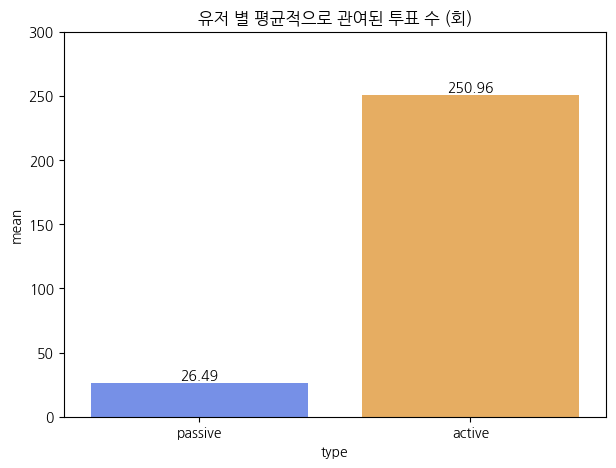

In [55]:
# 가로로 되어 있던 df를 그래프 그리기 편하도록 세로로 변경해줌
total_question_mean = total_question_describe.loc[total_question_describe['index'] == 'mean']
total_question_mean.rename(columns={'passive_question_counts': 'passive', 'active_question_counts': 'active'}, inplace=True)
total_question_mean = total_question_mean[['passive', 'active']].transpose().reset_index()
total_question_mean.rename(columns={'index': 'type', 1: 'mean'}, inplace=True)
total_question_mean['mean'] = round(total_question_mean['mean'], 2)

# 평균적으로 관여된 투표 수를 그린건데,
# 생각해보면 당연히 수동유저들은 투표 받기만을 기다려야 하니까? 
# 상대적으로 적게 나오는 것이 당연할 듯

fig, ax = plt.subplots(figsize=(7, 5))
ax = sns.barplot(data=total_question_mean, x='type', y='mean', hue='type', palette=color_map)
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.set_ylim(0, 300)

plt.title('유저 별 평균적으로 관여된 투표 수 (회)')
plt.show()

In [56]:
# 시간 차이가 나지 않는 기록들은 전부 미답변 상태
# 읽은 기록이 있기도 하지만 모두 미답변
# 따라서, 시간 차이가 나는 기록들 -> 채팅

test = question_time_diff[question_time_diff['diff'] == pd.Timedelta(0)]
test[test['answer_status'] != 'N']

,question_id,status,created_at,chosen_user_id,user_id,has_read,answer_status,answer_updated_at,report_count,opened_times,diff


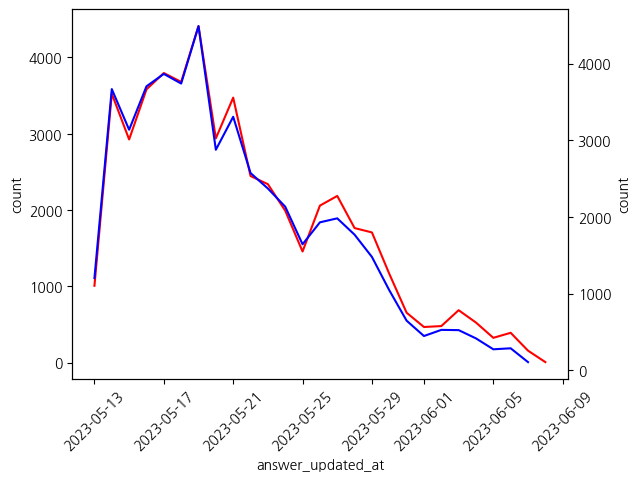

In [57]:
# 그렇다면, 채팅 투표 기록만 추이를 봐보자
# 날짜별 기록된 횟수
# 5월 21일 이후로 계속되는 하락세
# question의 created_at, answer_updated_at 채팅 기록 날짜 범위: 2023-05-13 ~ 2024-05-05
# 근데, 채팅 기록이 확실한 것들 날짜 범위: 2023-05-13 ~ 2023-06-08
# 약 일주일동안 활발한 채팅기록이 생성되다가 6월 초 이후부터는 급격히 사라진 것을 볼 수 있음

ee = question[question['answer_updated_at'] > question['created_at']][columns]
ex = ee['answer_updated_at'].dt.date
ex1 = ee['created_at'].dt.date
ex = ex.value_counts().reset_index()
ex1 = ex1.value_counts().reset_index()

fig, ax = plt.subplots()
ax = sns.lineplot(data=ex, x='answer_updated_at', y='count', color='red')
ax1 = ax.twinx()
ax1 = sns.lineplot(data=ex1, x='created_at', y='count', color='blue')
ax.tick_params(axis='x', labelrotation=45)
plt.show()

In [58]:
# 수동이다가 능동이 된 유저들의 전환 기간 확인
passive_first = question.groupby('chosen_user_id')['created_at'].min().reset_index()
passive_first.columns = ['user_id', 'first_passive_at']

active_first = question.groupby('user_id')['created_at'].min().reset_index()
active_first.columns = ['user_id', 'first_active_at']

# 둘다 기록을 가지고 있는 user_id가 교집합 유저 (1,686명)
total_first = pd.merge(passive_first, active_first, on='user_id', how='inner')

# 수동 -> 능동 전환된 유저 523명 (전체 교집합 유저의 31%)
converted = total_first[total_first['first_passive_at'] < total_first['first_active_at']] 

# 평균적으로 13시간 뒤에 능동으로 전환됨
# 중앙값 약 2시간 이내로 능동으로 전환됨
converted['conversion_days'] = converted['first_active_at'] - converted['first_passive_at']
converted['conversion_days'].describe().reset_index()

,index,conversion_days
0,count,523
1,mean,0 days 13:19:56.460803059
2,std,1 days 05:08:22.881296585
3,min,0 days 00:00:01
4,25%,0 days 00:14:41
5,50%,0 days 01:51:51
6,75%,0 days 13:02:08
7,max,9 days 23:40:14


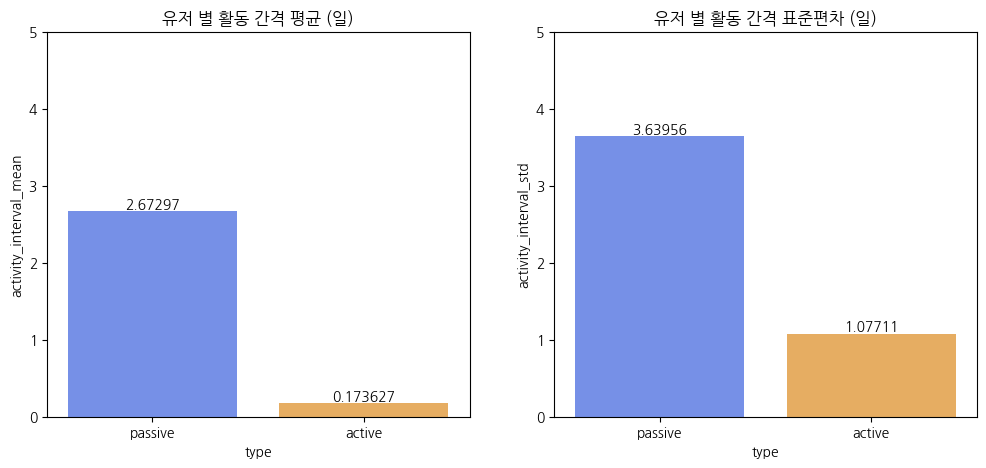

In [59]:
# 유저별 활동 간격 표준편차 확인
# 표준편차로 본 이유: 활동 간격이 일정한지 일정하지 않은지 확인하기 위해
# 활동 패턴 안정성을 볼 수 있음!
# 표준편차가 클수록, 몰아서 들어옴

# 투표 하거나 받은 created_at를 기준으로 함
passive_question_slice = passive_question[['chosen_user_id', 'created_at']]
active_question_slice = active_question[['user_id', 'created_at']]
passive_question_slice.columns = ['user_id', 'created_at']

all_slice = pd.concat([passive_question_slice, active_question_slice], ignore_index=True)
all_slice.dropna(subset=['user_id'], inplace=True) # 혹시나 null 있으면 드롭
all_slice.sort_values(by=['user_id', 'created_at'], inplace=True)

# 유저별 시간 차이 계산
all_slice['time_diff'] = all_slice.groupby('user_id')['created_at'].diff()

# 일 단위로 변환
all_slice['time_diff_days'] = all_slice['time_diff'].dt.total_seconds() / (60*60*24)
user_interval_info = all_slice.groupby('user_id')['time_diff_days'].agg(['mean', 'std']).reset_index() # 평균, 표준편차 둘다 구함
user_interval_info.columns = ['user_id', 'activity_interval_mean', 'activity_interval_std']

user_interval_info['type'] = user_interval_info['user_id'].apply(lambda x: 'passive' if x in passive_user else 'active')
user_interval_info_mean = user_interval_info.groupby('type')[['activity_interval_mean', 'activity_interval_std']].mean().reset_index()
user_interval_info_mean.sort_values(by='type', ascending=False, inplace=True)

# 그래프로 정리
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0] = sns.barplot(data=user_interval_info_mean, x='type', y='activity_interval_mean', hue='type', palette=color_map, ax=ax[0])
ax[0].bar_label(ax[0].containers[0], fontsize=10)
ax[0].bar_label(ax[0].containers[1], fontsize=10)
ax[0].set_ylim(0, 5)
ax[0].set_title('유저 별 활동 간격 평균 (일)')

ax[1] = sns.barplot(data=user_interval_info_mean, x='type', y='activity_interval_std', hue='type', palette=color_map, ax=ax[1])
ax[1].bar_label(ax[1].containers[0], fontsize=10)
ax[1].bar_label(ax[1].containers[1], fontsize=10)
ax[1].set_ylim(0, 5)
ax[1].set_title('유저 별 활동 간격 표준편차 (일)')

plt.show()

### 2) 출석

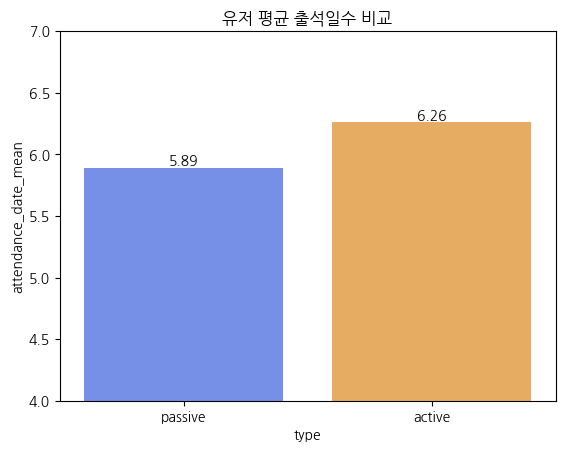

In [61]:
# 능동, 수동 유저 별 출석일수 비교
passive_attendance = funnel_attendance[funnel_attendance['user_id'].isin(passive_user)]
active_attendance = funnel_attendance[funnel_attendance['user_id'].isin(active_user)]

passive_attendance_counts = passive_attendance.groupby('user_id')['attendance_date_list'].count().reset_index(name='attendance_date_counts')
active_attendance_counts = active_attendance.groupby('user_id')['attendance_date_list'].count().reset_index(name='attendance_date_counts')

passive_attendance_counts_mean = passive_attendance_counts['attendance_date_counts'].mean()
active_attendance_counts_mean = active_attendance_counts['attendance_date_counts'].mean()

attendance_counts = pd.DataFrame({
    'type': ['passive', 'active'],
    'attendance_date_mean': [round(passive_attendance_counts_mean, 2), 
                             round(active_attendance_counts_mean, 2)]
})

# 출석 일수 별 차이 없었음
ax = sns.barplot(data=attendance_counts, x='type', y='attendance_date_mean', hue='type', palette=color_map)
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.set_title('유저 평균 출석일수 비교')
ax.set_ylim(4, 7)
plt.show()

In [62]:
def make_diff_column(df):
    new_df = pd.DataFrame({})
    for i in range(len(df)):
        df_slice = df.iloc[i: i+1] # df용
        df_slice_compare = df_slice.iloc[0] # 조건 비교용. 이렇게 안 하면 값이 index있는 df 형식으로 나옴
        
        if df_slice_compare['user_id'] == df_slice_compare['before_user_id']: # 이전행, 현재행의 user_id가 같으면
            diff = df_slice_compare['attendance_date_list'] - df_slice_compare['before_attendance_date'] # 날짜 차이 구함
            df_slice['diff'] = diff
        else: # 다르면
            df_slice['diff'] = np.nan # null 넣어줌
        
        new_df = pd.concat([new_df, df_slice])
    
    return new_df

# 1번만 출석한 유저는 제외 
passive_no_only_cond = passive_attendance_counts['attendance_date_counts'] > 1
active_no_only_cond = active_attendance_counts['attendance_date_counts'] > 1

passive_no_only_user = passive_attendance_counts[passive_no_only_cond]['user_id'].unique()
passive_attendance_diff = passive_attendance[passive_attendance['user_id'].isin(passive_no_only_user)]
passive_attendance_diff.sort_values(by=['user_id', 'attendance_date_list'], inplace=True)
passive_attendance_diff['before_attendance_date'] = passive_attendance_diff['attendance_date_list'].shift(1)
passive_attendance_diff['before_user_id'] = passive_attendance_diff['user_id'].shift(1)

active_no_only_user = active_attendance_counts[passive_no_only_cond]['user_id'].unique()
active_attendance_diff = active_attendance[active_attendance['user_id'].isin(active_no_only_user)]
active_attendance_diff.sort_values(by=['user_id', 'attendance_date_list'], inplace=True)
active_attendance_diff['before_attendance_date'] = active_attendance_diff['attendance_date_list'].shift(1)
active_attendance_diff['before_user_id'] = active_attendance_diff['user_id'].shift(1)

# 유저들의 평균 출석 기간 차이 df 생성
passive_attendance_diff = make_diff_column(passive_attendance_diff)
active_attendance_diff = make_diff_column(active_attendance_diff)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_20416\3040651416.py:27: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [63]:
# diff 평균 구함
passive_attendance_diff_mean = passive_attendance_diff.groupby('user_id')['diff'].mean().reset_index()
passive_attendance_diff_mean = passive_attendance_diff_mean['diff'].mean()

active_attendance_diff_mean = active_attendance_diff.groupby('user_id')['diff'].mean().reset_index()
active_attendance_diff_mean = active_attendance_diff_mean['diff'].mean()

attendance_diff = pd.DataFrame({
    'type': ['passive', 'active'],
    'attendance_diff_mean': [passive_attendance_diff_mean, 
                             active_attendance_diff_mean]
})

# diff df
# 다음 출석일까지 평균적으로 6~7일 정도 걸렸음
# 두 유저타입에서 별 차이 없었음
attendance_diff

,type,attendance_diff_mean
0,passive,6 days 20:46:59.351467567
1,active,6 days 05:42:05.268863574


### 3) 포인트

In [66]:
# 능동, 수동 유저 별 포인트 수 비교
passive_accounts_user = funnel_user[funnel_user['user_id'].isin(passive_user)]
active_accounts_user = funnel_user[funnel_user['user_id'].isin(active_user)]

passive_point_describe = passive_accounts_user['point'].describe().reset_index(name='passive_points')
active_point_describe = active_accounts_user['point'].describe().reset_index(name='active_points')

# 포인트 describe는 별 차이 없음
# 굳이 따지면, max 차이
pd.merge(passive_point_describe, active_point_describe, on='index', how='left')

,index,passive_points,active_points
0,count,2289.00,1705.00
1,mean,1856.14,1902.63
2,std,2013.51,2021.66
3,min,4.00,0.00
4,25%,488.00,465.00
5,50%,1231.00,1235.00
6,75%,2503.00,2643.00
7,max,18803.00,15951.00


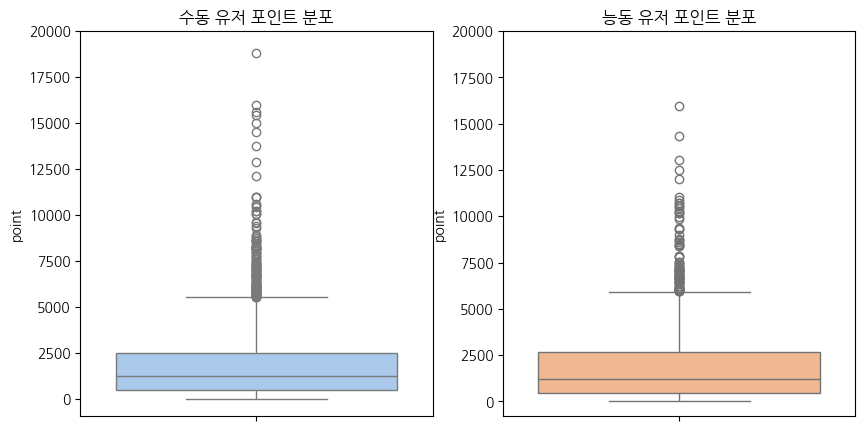

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0] = sns.boxplot(data=passive_accounts_user, y='point', ax=ax[0], color=passive_color)
ax[1] = sns.boxplot(data=active_accounts_user, y='point', ax=ax[1], color=active_color)

ax[0].set_title('수동 유저 포인트 분포')
ax[1].set_title('능동 유저 포인트 분포')

ax[0].set_yticks(range(0, 20001, 2500))
ax[1].set_yticks(range(0, 20001, 2500))
plt.show()

### 4) 하트 구매 이력

In [70]:
# 능동, 수동 유저 별 구매이력 비교
passive_payment = funnel_payment[funnel_payment['user_id'].isin(passive_user)]
active_payment = funnel_payment[funnel_payment['user_id'].isin(active_user)]

passive_total_pay = passive_payment.groupby('user_id')['product_hearts'].sum().reset_index(name='total_pay_hearts')
active_total_pay = active_payment.groupby('user_id')['product_hearts'].sum().reset_index(name='total_pay_hearts')

passive_hearts_describe = passive_total_pay['total_pay_hearts'].describe().reset_index(name='passive_hearts')
active_hearts_describe = active_total_pay['total_pay_hearts'].describe().reset_index(name='active_hearts')

# 하트 총 구매 수에서, max부분에서 많이 차이가 남
pd.merge(passive_hearts_describe, active_hearts_describe, on='index', how='left')

,index,passive_hearts,active_hearts
0,count,459.00,214.00
1,mean,1417.00,1260.50
2,std,2630.79,1298.91
3,min,200.00,200.00
4,25%,777.00,777.00
5,50%,777.00,777.00
6,75%,977.00,977.00
7,max,44777.00,10977.00


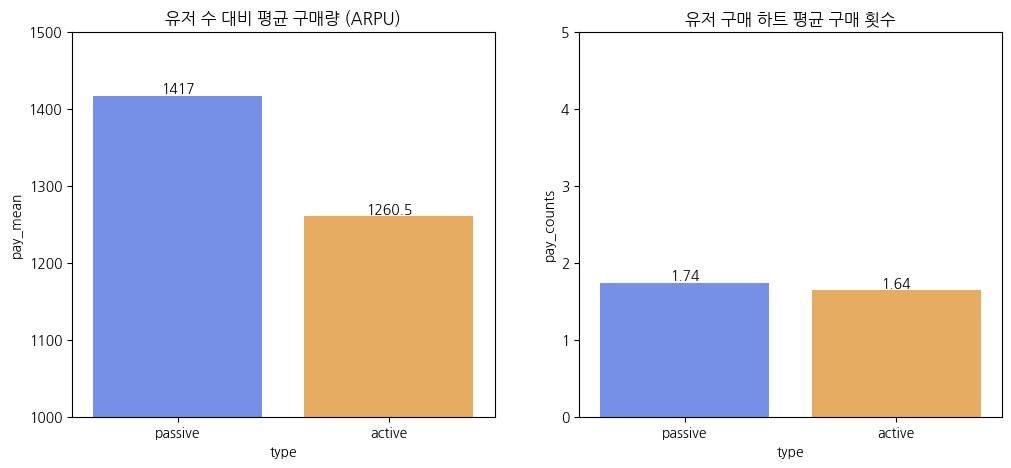

In [71]:
passive_total_pay_mean = passive_total_pay['total_pay_hearts'].mean()
active_total_pay_mean = active_total_pay['total_pay_hearts'].mean()

pay_mean = pd.DataFrame({
    'type': ['passive', 'active'],
    'pay_mean': [round(passive_total_pay_mean, 2), 
                round(active_total_pay_mean, 2)]
})

passive_pay_counts = passive_payment.groupby('user_id')['product_hearts'].count().reset_index(name='pay_count')
active_pay_counts = active_payment.groupby('user_id')['product_hearts'].count().reset_index(name='pay_count')

passive_pay_counts_mean = passive_pay_counts['pay_count'].mean()
active_pay_counts_mean = active_pay_counts['pay_count'].mean()

pay_counts = pd.DataFrame({
    'type': ['passive', 'active'],
    'pay_counts': [round(passive_pay_counts_mean, 2), 
                round(active_pay_counts_mean, 2)]
})

# 수동 유저들이 구매한 하트가 평균적으로 더 많았음
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0] = sns.barplot(data=pay_mean, x='type', y='pay_mean', hue='type', palette=color_map, ax=ax[0])
ax[0].bar_label(ax[0].containers[0], fontsize=10)
ax[0].bar_label(ax[0].containers[1], fontsize=10)
ax[0].set_title('유저 수 대비 평균 구매량 (ARPU)')
ax[0].set_ylim(1000, 1500)

ax[1] = sns.barplot(data=pay_counts, x='type', y='pay_counts', hue='type', palette=color_map, ax=ax[1])
ax[1].bar_label(ax[1].containers[0], fontsize=10)
ax[1].bar_label(ax[1].containers[1], fontsize=10)
ax[1].set_title('유저 구매 하트 평균 구매 횟수')
ax[1].set_ylim(0, 5)

plt.show()

In [72]:
passive_payment['type'] = 'passive'
active_payment['type'] = 'active'

total_payment = pd.concat([passive_payment, active_payment])
total_sum_payment = total_payment.groupby('user_id').agg({'product_hearts': 'sum', 'type': 'min'}).reset_index()
total_sum_payment.rename(columns={'product_hearts': 'total_hearts'}, inplace=True)

total_revenue = total_sum_payment['total_hearts'].sum()
revenue_by_type = total_sum_payment.groupby('type')['total_hearts'].sum().reset_index()
revenue_by_type['contribution_ratio'] = revenue_by_type['total_hearts'] / total_revenue

# 총 구매량 대비 비율 (구매 기여도)
revenue_by_type

,type,total_hearts,contribution_ratio
0,active,269747,0.29
1,passive,650404,0.71


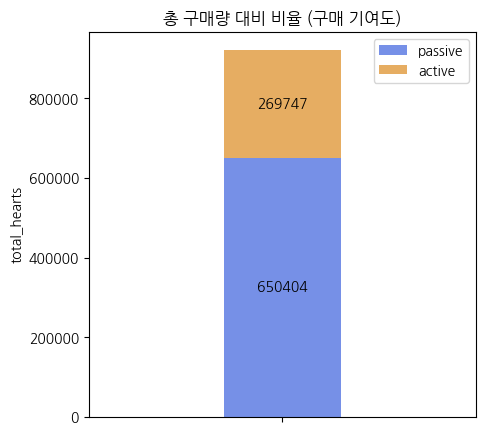

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(data=revenue_by_type[revenue_by_type['type'] == 'passive'], y='total_hearts', 
            label='passive', width=0.3, color='#6386fa')
sns.barplot(data=revenue_by_type[revenue_by_type['type'] == 'active'], y='total_hearts',
            bottom=revenue_by_type[revenue_by_type['type'] == 'passive']['total_hearts'], 
            label='active', width=0.3, color='#fcb04c')

for container in ax.containers:
    ax.bar_label(container, label_type='center')

ax.set_title('총 구매량 대비 비율 (구매 기여도)')
plt.show()

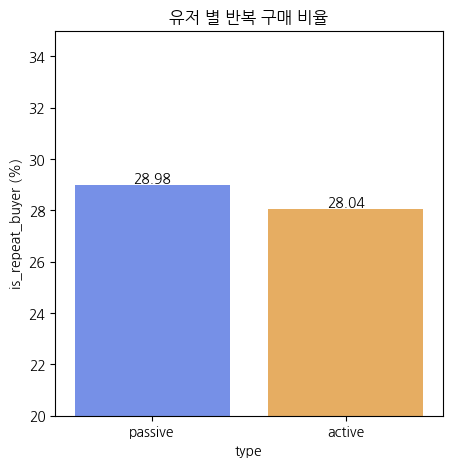

In [ ]:
purchase_count = total_payment.groupby('user_id').agg({'product_hearts': 'size', 'type': 'min'}).reset_index()
purchase_count.rename(columns={'product_hearts': 'purchase_count'}, inplace=True)
purchase_count['is_repeat_buyer'] = purchase_count['purchase_count'] > 1 # 반복 구매자 표시

# 유저 별 반복 구매 비율
repeat_rate = purchase_count.groupby('type')['is_repeat_buyer'].mean().reset_index()
repeat_rate['is_repeat_buyer'] = round(repeat_rate['is_repeat_buyer'], 4) * 100
repeat_rate.rename(columns={'is_repeat_buyer': 'is_repeat_buyer (%)'}, inplace=True)
repeat_rate.sort_values(by='type', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(data=repeat_rate, x='type', y='is_repeat_buyer (%)', hue='type', palette=color_map)
for container in ax.containers:
    ax.bar_label(container)
ax.set_ylim(20, 35)
ax.set_title('유저 별 반복 구매 비율')
plt.show()

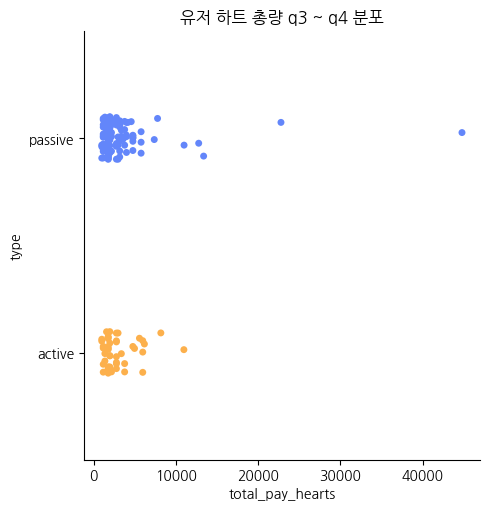

In [76]:
# 하트 75% ~ 비교
# np.percentile(passive_total_pay['total_pay_hearts'], 75)
passive_q3_pay = passive_total_pay[passive_total_pay['total_pay_hearts'] > 977]
active_q3_pay = active_total_pay[active_total_pay['total_pay_hearts'] > 977]

passive_q3_pay['type'] = 'passive'
active_q3_pay['type'] = 'active'

q3_pay = pd.concat([passive_q3_pay, active_q3_pay])

sns.catplot(data=q3_pay, x='total_pay_hearts', y='type', hue='type', palette=color_map)
plt.title('유저 하트 총량 q3 ~ q4 분포')
plt.show()

In [77]:
# 해당 유저의 구매 여부 구분 함수
def is_pay(user, user_list):
    if user in user_list:
        return '구매'
    else:
        return '구매 X'

# 구매 유저 구하기
passive_pay_user = passive_total_pay['user_id'].unique()
active_pay_user = active_total_pay['user_id'].unique()
total_pay_user = funnel_payment['user_id'].unique()

# 유저 타입 별 구매 여부 df 생성
passive_is_pay = pd.DataFrame({
    'user_id': passive_user
})
active_is_pay = pd.DataFrame({
    'user_id': active_user
})

passive_is_pay['is_pay'] = passive_is_pay['user_id'].apply(lambda x: is_pay(x, passive_pay_user))
active_is_pay['is_pay'] = active_is_pay['user_id'].apply(lambda x: is_pay(x, active_pay_user))

passive_is_pay = passive_is_pay['is_pay'].value_counts().reset_index()
active_is_pay = active_is_pay['is_pay'].value_counts().reset_index()

# 전체 유저의 구매 여부 df (기간으로만 전처리한 전체 테이블)
funnel_pay_user_counts = len(funnel_user[funnel_user['user_id'].isin(total_pay_user)])
total_is_pay = pd.DataFrame({
    'is_pay': ['구매', '구매 X'],
    'count': [funnel_pay_user_counts,
              funnel_user['user_id'].nunique() - funnel_pay_user_counts]
})
total_is_pay.sort_values(by='count', ascending=False, inplace=True)

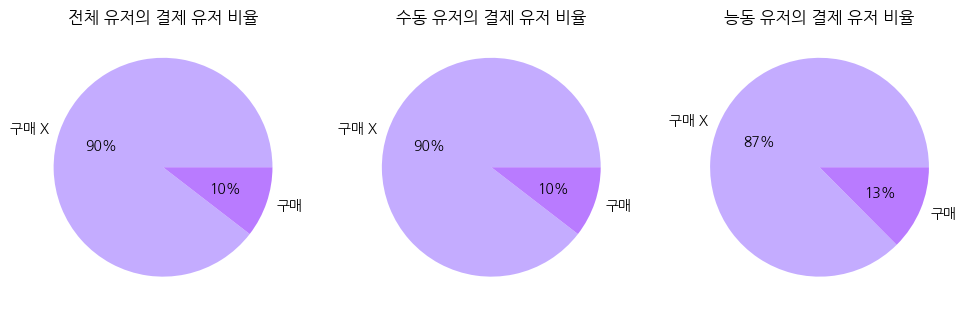

In [ ]:
# 구매율 그래프
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
pay_colors = ['#c4acff', '#b97bff']
ax[0].pie(x=total_is_pay['count'], labels=total_is_pay['is_pay'], autopct='%.f%%', colors=pay_colors)
ax[1].pie(x=passive_is_pay['count'], labels=passive_is_pay['is_pay'], autopct='%.f%%', colors=pay_colors)
ax[2].pie(x=active_is_pay['count'], labels=active_is_pay['is_pay'], autopct='%.f%%', colors=pay_colors)

ax[0].set_title('전체 유저의 결제 유저 비율')
ax[1].set_title('수동 유저의 결제 유저 비율')
ax[2].set_title('능동 유저의 결제 유저 비율')

plt.show()

# 수동유저의 구매 비율이 생각보다 낮음
# 구매 총량은 많았는데..?
# 수동유저는 한 사람이 여러번 사는 경우가 많았나봄

In [79]:
# 유저별 첫 구매 시점
first_purchase = total_payment.groupby('user_id')['created_at'].min().reset_index()
first_purchase.columns = ['user_id', 'first_purchase_at']

# 유저별 첫 투표 시점
vote_activity = pd.concat([passive_question_slice, active_question_slice], ignore_index=True)
vote_activity.dropna(inplace=True)  # 혹시나 null 있으면 드롭
vote_activity = vote_activity.merge(first_purchase, on='user_id', how='inner')
vote_activity['type'] = vote_activity['user_id'].apply(lambda x: 'passive' if x in passive_user else 'active')

# 첫 구매 시점보다 이전 투표 기록만 남김
before_purchase = vote_activity[vote_activity['created_at'] < vote_activity['first_purchase_at']]

# 첫 구매까지 걸리는 평균 투표 횟수
activity_before_purchase = before_purchase.groupby('user_id').agg({'first_purchase_at': 'size', 'type': 'min'}).reset_index()
activity_before_purchase.rename(columns={'first_purchase_at': 'vote_count_before_purchase'}, inplace=True)
activity_before_purchase_describe = activity_before_purchase.groupby('type')['vote_count_before_purchase'].describe().reset_index()
activity_before_purchase_describe

,type,count,mean,std,min,25%,50%,75%,max
0,active,212.00,85.36,95.85,1.00,23.00,58.50,109.50,714.00
1,passive,235.00,13.57,23.11,1.00,2.00,5.00,15.50,157.00


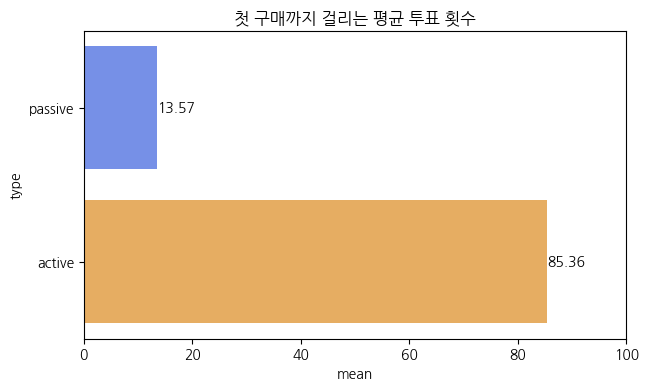

In [80]:
activity_before_purchase_describe.sort_values(by='type', ascending=False, inplace=True)
activity_before_purchase_describe['mean'] = round(activity_before_purchase_describe['mean'], 2)

fig, ax = plt.subplots(figsize=(7, 4))
ax = sns.barplot(data=activity_before_purchase_describe, x='mean', y='type', hue='type', palette=color_map)
for container in ax.containers:
    ax.bar_label(container)
ax.set_xlim(0, 100)
plt.title('첫 구매까지 걸리는 평균 투표 횟수')
plt.show()

## 7-3. 수익 유저 분석

### 1) 결제 전환율, 재구매율 확인

In [13]:
accounts_paymenthistory.columns

Index(['user_id', 'productId', 'phone_type', 'created_at', 'product_hearts'], dtype='object')

In [ ]:
candidates = {
    'accounts_paymenthistory': accounts_paymenthistory,
    'event_receipts': globals().get('event_receipts', None),
    'events': globals().get('events', None),
}

for name, df in candidates.items():
    if df is None:
        continue
    cols = [c.lower() for c in df.columns]
    money_cols = [c for c in df.columns if any(k in c.lower() for k in ['price','amount','value','revenue','cost','currency','money','paid'])]
    pid_cols = [c for c in df.columns if 'product' in c.lower() or 'sku' in c.lower() or 'item' in c.lower()]
    print(f'\n[{name}] rows={len(df):,}')
    print('  money-ish:', money_cols)
    print('  product-ish:', pid_cols[:10])


[accounts_paymenthistory] rows=95,140
  money-ish: []
  product-ish: ['productId', 'product_hearts']

[event_receipts] rows=309
  money-ish: []
  product-ish: []

[events] rows=3
  money-ish: []
  product-ish: []


In [ ]:
print(event_receipts.shape, events.shape)
print('event_receipts cols:', list(event_receipts.columns))
print('events cols:', list(events.columns))

(309, 5) (3, 6)
event_receipts cols: ['id', 'created_at', 'event_id', 'user_id', 'plus_point']
events cols: ['event_id', 'title', 'plus_point', 'event_type', 'is_expired', 'created_at']


- 정확한 금액을 알 수 있는 컬럼이나 테이블이 없었던 기억
- 지피티한테, 가격과 관련한 컬럼이 있는지 교차검증 할 수 있는 코드 짜달라고 해서 해클까지 확인
    - 구체적인 매출을 알 수 있는 방법은 없을듯 함

In [19]:
inflow_set = set(inflow_user.astype(str))
part_set = set(participation_user.astype(str))

In [ ]:
def heart_kpis(base_set, label):

    sub = funnel_payment[funnel_payment['user_id'].isin(base_set)].copy()

    users_cnt = len(base_set)
    buyers = sub['user_id'].nunique()
    tx = len(sub)

    user_tx = sub.groupby('user_id').size()

    freq = tx / max(1, buyers)
    repurchase = (user_tx >= 2).sum()
    repurchase_rate = repurchase / max(1, buyers)

    print(f'{label} -> 하트 수익')
    print('기준 유저:', users_cnt)
    print('하트 구매 유저:', buyers)
    print('구매 전환율:', buyers / max(1, users_cnt))
    print('총 구매 건수:', tx)
    print('구매자당 평균 구매:', freq)
    print('재구매 유저:', repurchase)
    print('재구매율:', repurchase_rate)

    print('\n상품 별 구매자 수')
    print(sub['productId'].value_counts().head(10))

In [ ]:
heart_kpis(inflow_set, '유입')

유입 -> 하트 수익
기준 유저: 301884
하트 구매 유저: 34369
구매 전환율: 0.11384836559738178
총 구매 건수: 57401
구매자당 평균 구매: 1.670138787861154
재구매 유저: 9971
재구매율: 0.29011609299077656

상품 별 구매자 수
productId
heart.777     33592
heart.1000    12354
heart.200     10128
heart.4000     1327
Name: count, dtype: int64


In [ ]:
heart_kpis(part_set, '참여')

참여 -> 하트 수익
기준 유저: 6095
하트 구매 유저: 673
구매 전환율: 0.11041837571780147
총 구매 건수: 1150
구매자당 평균 구매: 1.7087667161961366
재구매 유저: 193
재구매율: 0.2867756315007429

상품 별 구매자 수
productId
heart.777     663
heart.1000    261
heart.200     200
heart.4000     26
Name: count, dtype: int64


- 유입 퍼널의 결제 전환율: 11.3%, 재구매율: 29%
- 참여 퍼널의 결제 전환율: 11.0%, 재구매율: 28.6%
    - 구매는 참여의 깊이보다 서비스 진입 초반 상태에서 이미 결정됨
- 평균 구매 횟수: 약 1.7회
- 중간 가격 상품(777개)이 메인


In [ ]:
user_purchase = funnel_payment.groupby('user_id').size().reset_index(name='tx')

user_purchase['percentile'] = pd.qcut(user_purchase['tx'], q=10, labels=False, duplicates='drop')

user_purchase.groupby('percentile')['tx'].sum()

percentile
0    60212
1    10266
2    24658
Name: tx, dtype: int64

In [ ]:
signup_time = accounts_user[['user_id','created_at']].copy()
signup_time['created_at'] = pd.to_datetime(signup_time['created_at'])

purchase_time = funnel_payment.groupby('user_id')['created_at'].min().reset_index()
purchase_time['created_at'] = pd.to_datetime(purchase_time['created_at'])

signup_time['user_id'] = signup_time['user_id'].astype(str)
purchase_time['user_id'] = purchase_time['user_id'].astype(str)

speed = signup_time.merge(purchase_time, on='user_id', how='inner', suffixes=('_signup', '_buy'))

speed['days_to_buy'] = (speed['created_at_buy'] - speed['created_at_signup']).dt.days

speed['days_to_buy'].describe()

count   59177.00
mean        9.21
std        24.11
min         0.00
25%         1.00
50%         3.00
75%         8.00
max       372.00
Name: days_to_buy, dtype: float64

- 하트 구매까지 이어진 유저 수: 59177명(가입 -> 하트 구매 기록)
- 평균 구매까지 9.2일이 걸림
- 표준편차가 평균보다 훨씬 큼
    - max 구매 유저가 372일이므로 표준편차 차이가 나는 듯
    - 구매 타이밍이 매우 제각각, 유저 팽동 패턴이 하나가 아님
- 구매 유저 절반이 가입 후 3일 안에 결제
- 🟢중앙값 3일로 대부분의 구매가 가입 초기 단계에서 발생, 일부 장기 지연 구매자가 존재해 분산은 크지만, 전체적으로 초기 경험 구간에서 수익 전환이 집중되는 구조를 보임

In [ ]:
active_time = (
    question.groupby('user_id')['created_at'].min()
     .reset_index()
     .rename(columns={'user_id': 'user', 'created_at': 'first_part_at'})
)

passive_time = (
    question.groupby('chosen_user_id')['created_at'].min()
     .reset_index()
     .rename(columns={'chosen_user_id': 'user', 'created_at': 'first_part_at'})
)

part_time = (
    pd.concat([active_time, passive_time], ignore_index=True)
      .groupby('user')['first_part_at'].min()
      .reset_index()
)

buy_time = (
    funnel_payment.groupby('user_id')['created_at'].min()
       .reset_index()
       .rename(columns={'user_id': 'user', 'created_at': 'first_buy_at'})
)

In [ ]:
speed_part = part_time.merge(buy_time, on='user', how='inner')
speed_part['days_to_buy'] = (speed_part['first_buy_at'] - speed_part['first_part_at']).dt.days

print('참여 > 구매 유저 수:', len(speed_part))
print('음수(구매가 참여보다 빠름) 개수:', (speed_part['days_to_buy'] < 0).sum())

speed_part['days_to_buy'].describe()

참여 > 구매 유저 수: 673
음수(구매가 참여보다 빠름) 개수: 226


count    673.00
mean       0.70
std       18.66
min     -129.00
25%       -2.00
50%        0.00
75%        1.00
max      287.00
Name: days_to_buy, dtype: float64

- 투표보다 하트 구매가 먼저 진행된 유저들: 226명
- 데이터가 잘렸을 수도 있고, 실제로 하트를 먼저 구매했을 수도 있음
    - 하위 25%는 이미 구매 상태였음
    - !!!!!!!절반의 유저가 참여 당일 하트 구매!!!!!!!
    - 70% 유저가 1일 이내 구매
- 참여 유저들은 평균 약 0.7일 안에 구매(분산은 큼)
- 🟢참여 이후 구매는 즉시 전환 패턴, 구매 유저 절반 이상이 참여 당일 하트 구매하는 강한 단기 전환 구조를 보임

### 2) 헤비유저 확인

In [ ]:
user_tx = funnel_payment.groupby('user_id').size().reset_index(name='tx')

user_tx['group'] = pd.qcut(user_tx['tx'], q=5, labels=False, duplicates='drop')

user_tx.groupby('group')['tx'].agg(['count','sum'])

,count,sum
group,,
0,51631,60212
1,7560,34924


In [ ]:
user_tx['tx'].describe()

count   59191.00
mean        1.61
std         1.56
min         1.00
25%         1.00
50%         1.00
75%         2.00
max        60.00
Name: tx, dtype: float64

In [ ]:
(user_tx['tx'] >= 2).mean()

np.float64(0.2726934838066598)

In [ ]:
heavy_users = user_tx[user_tx['tx'] >= 3]['user_id']

In [ ]:
heavy_part = set(map(str, heavy_users)) & set(map(str, participation_user))
print('헤비유저 참여유저 합집합:', len(heavy_part))

헤비유저 참여유저 합집합: 109


In [ ]:
heavy_inflow = set(map(str, heavy_users)) & set(map(str, inflow_user))  # inflow_users는 너 유입 유저 변수명으로
print('헤비유저 유입유저 합집합:', len(heavy_inflow))

헤비유저 유입유저 합집합: 4811


In [ ]:
print('헤비 중 참여 비율:', len(heavy_part) / len(heavy_users))
print('헤비 중 유입 비율:', len(heavy_inflow) / len(heavy_users))

헤비 중 참여 비율: 0.014417989417989418
헤비 중 유입 비율: 0.6363756613756614


In [98]:
participation_user_df = pd.concat([question['user_id'], question['chosen_user_id']]).reset_index(name='user')
part_cnt = participation_user_df.groupby('user').size().reset_index(name='part_cnt')

buyer = set(funnel_payment['user_id'].astype(str).unique())

part_cnt['is_buyer'] = part_cnt['user'].astype(str).isin(buyer)

part_cnt['group'] = pd.qcut(
    part_cnt['part_cnt'],
    q=4,
    labels=['low','mid-low','mid-high','high'],
    duplicates='drop'
)

part_cnt.groupby('group')['is_buyer'].mean()

group
low        0.10
mid-low    0.11
mid-high   0.10
high       0.14
Name: is_buyer, dtype: float64

In [ ]:
re_user = set(user_tx[user_tx['tx'] >= 2]['user_id'].astype(str))

part_cnt['is_repeat'] = part_cnt['user'].astype(str).isin(re_user)

part_cnt.groupby('group')['is_repeat'].mean()

In [ ]:
funnel_payment['user_id'].nunique()

59191

In [ ]:
all_buyers = set(funnel_payment['user_id'].astype(str).unique())
inflow_buyers = all_buyers & set(map(str, inflow_user))
part_buyers = all_buyers & set(map(str, participation_user))

In [ ]:
funnel_payment['user_id'] = funnel_payment['user_id'].astype(str)

pay_all = funnel_payment.copy()
pay_inflow = funnel_payment[funnel_payment['user_id'].isin(inflow_buyers)].copy()
pay_part = funnel_payment[funnel_payment['user_id'].isin(part_buyers)].copy()

In [ ]:
def purchase_stats(df):
    user_tx = df.groupby('user_id').size().reset_index(name='tx')
    return user_tx['tx'].describe()

purchase_stats(pay_all)

count   59191.00
mean        1.61
std         1.56
min         1.00
25%         1.00
50%         1.00
75%         2.00
max        60.00
Name: tx, dtype: float64

In [53]:
purchase_stats(pay_inflow)

count   34369.00
mean        1.67
std         1.68
min         1.00
25%         1.00
50%         1.00
75%         2.00
max        60.00
Name: tx, dtype: float64

In [54]:
purchase_stats(pay_part)

count   673.00
mean      1.71
std       1.68
min       1.00
25%       1.00
50%       1.00
75%       2.00
max      20.00
Name: tx, dtype: float64

In [59]:
pay = funnel_payment.copy()
pay['user_id'] = pay['user_id'].astype(str)

buyers = set(pay['user_id'].unique())

group_sets = {
    '전체구매자': buyers,
    '유입 → 구매자': set(map(str, inflow_user)) & buyers,
    '참여 → 구매자': set(map(str, participation_user)) & buyers,
}

In [60]:
def purchase_kpis_for_group(pay_df, buyer_set, base_set=None, label=''):
    
    buyer_set = set(map(str, buyer_set))
    sub = pay_df[pay_df['user_id'].isin(buyer_set)].copy()

    user_tx = sub.groupby('user_id').size().rename('tx')
    buyers_cnt = user_tx.shape[0]
    total_tx = int(user_tx.sum())

    repeat_buyers = int((user_tx >= 2).sum())
    repurchase_rate = repeat_buyers / max(1, buyers_cnt)

    def top_share(p):
        if buyers_cnt == 0:
            return 0.0
        k = max(1, int(np.ceil(buyers_cnt * p)))
        top_tx = user_tx.sort_values(ascending=False).head(k).sum()
        return float(top_tx / max(1, total_tx))

    top1 = top_share(0.01)
    top5 = top_share(0.05)
    top10 = top_share(0.10)

    if base_set is None:
        base_set = buyer_set
    base_set = set(map(str, base_set))
    base_cnt = len(base_set)

    buy_rate_vs_base = buyers_cnt / max(1, base_cnt)

    repeat_rate_vs_base = repeat_buyers / max(1, base_cnt)

    out = {
        '집단': label,
        '기준유저수': base_cnt,
        '구매자수': buyers_cnt,
        '구매율(vs기준)': buy_rate_vs_base,
        '구매건수(=매출대용)': total_tx,
        '구매자당평균구매': total_tx / max(1, buyers_cnt),
        '재구매자수(>=2회)': repeat_buyers,
        '재구매율(구매자내)': repurchase_rate,
        '재구매율(vs기준)': repeat_rate_vs_base,
        '집중도Top1%(tx)': top1,
        '집중도Top5%(tx)': top5,
        '집중도Top10%(tx)': top10,
    }
    return out

In [ ]:
rows = []

rows.append(purchase_kpis_for_group(pay, group_sets['전체구매자'], base_set=buyers, label='전체구매자'))
rows.append(purchase_kpis_for_group(pay, group_sets['유입 → 구매자'], base_set=inflow_user, label='유입 → 구매자'))
rows.append(purchase_kpis_for_group(pay, group_sets['참여 → 구매자'], base_set=participation_user, label='참여 → 구매자'))

kpi_df = pd.DataFrame(rows)

kpi_df

,집단,기준유저수,구매자수,구매율(vs기준),구매건수(=매출대용),구매자당평균구매,재구매자수(>=2회),재구매율(구매자내),재구매율(vs기준),집중도Top1%(tx),집중도Top5%(tx),집중도Top10%(tx)
0,전체구매자,59191,59191,1.00,95136,1.61,16141,0.27,0.27,0.07,0.21,0.32
1,유입 → 구매자,301884,34369,0.11,57401,1.67,9971,0.29,0.03,0.08,0.22,0.32
2,참여 → 구매자,6095,673,0.11,1150,1.71,193,0.29,0.03,0.07,0.22,0.33


In [ ]:
def repurchase_stats(df):
    user_tx = df.groupby('user_id').size().reset_index(name='tx')

    buyers = len(user_tx)
    repeat_buyers = (user_tx['tx'] >= 2).sum()

    return {
        'buyers': buyers,
        'repeat_buyers': repeat_buyers,
        'repurchase_rate': repeat_buyers / buyers
    }

In [65]:
repurchase_stats(pay_all)

{'buyers': 59191,
 'repeat_buyers': np.int64(16141),
 'repurchase_rate': np.float64(0.2726934838066598)}

In [67]:
repurchase_stats(pay_inflow)

{'buyers': 34369,
 'repeat_buyers': np.int64(9971),
 'repurchase_rate': np.float64(0.29011609299077656)}

In [66]:
repurchase_stats(pay_part)

{'buyers': 673,
 'repeat_buyers': np.int64(193),
 'repurchase_rate': np.float64(0.2867756315007429)}

In [ ]:
def revenue_concentration(df):

    user_tx = df.groupby('user_id').size().reset_index(name='tx')

    user_tx = user_tx.sort_values('tx', ascending=False)

    top_n = int(len(user_tx) * 0.1)

    top_users = user_tx.head(top_n)

    concentration = top_users['tx'].sum() / user_tx['tx'].sum()

    return {
        'total_buyers': len(user_tx),
        'top10_users': top_n,
        'top10_revenue_share': concentration
    }

In [69]:
revenue_concentration(pay_all)

{'total_buyers': 59191,
 'top10_users': 5919,
 'top10_revenue_share': np.float64(0.31534855364951225)}

In [70]:
revenue_concentration(pay_inflow)

{'total_buyers': 34369,
 'top10_users': 3436,
 'top10_revenue_share': np.float64(0.3233044720475253)}

In [71]:
revenue_concentration(pay_part)

{'total_buyers': 673,
 'top10_users': 67,
 'top10_revenue_share': np.float64(0.3269565217391304)}

In [ ]:
participation_user_df = pd.concat([question['user_id'], question['chosen_user_id']]).drop_duplicates().reset_index(name='user')
part_users = set(participation_user_df['user'].astype(str).unique())

buyers = set(pay['user_id'].astype(str).unique())

part_to_buy_rate = len(part_users & buyers) / len(part_users)

print('참여 -> 구매율:', part_to_buy_rate)

참여 -> 구매율: 0.11041837571780147


In [ ]:
user_tx = pay.groupby('user_id').size().reset_index(name='tx')
user_tx['user_id'] = user_tx['user_id'].astype(str)

In [ ]:
def concentration_by_tx(user_tx_df, user_set, name='group'):

    df = user_tx_df[user_tx_df['user_id'].isin(user_set)].copy()

    total_tx = df['tx'].sum()
    buyers = len(df)

    df = df.sort_values('tx', ascending=False).reset_index(drop=True)

    def share(p):
        k = max(1, int(len(df) * p))
        return df.loc[:k-1, 'tx'].sum() / total_tx

    return {
        'segment': name,
        'buyers': buyers,
        'total_tx': total_tx,
        'avg_tx': df['tx'].mean(),
        'top_1%_share': share(0.01),
        'top_5%_share': share(0.05),
        'top_10%_share': share(0.10),
    }

In [ ]:
all_buyers = set(user_tx['user_id'])
inflow_buyers = set(map(str, inflow_buyers))
part_buyers = set(map(str, part_buyers))

rows = [
    concentration_by_tx(user_tx, all_buyers, 'ALL'),
    concentration_by_tx(user_tx, inflow_buyers, 'INFLOW→BUY'),
    concentration_by_tx(user_tx, part_buyers, 'PART→BUY'),
]

pd.DataFrame(rows)

,segment,buyers,total_tx,avg_tx,top_1%_share,top_5%_share,top_10%_share
0,ALL,59191,95136,1.61,0.07,0.21,0.32
1,INFLOW→BUY,34369,57401,1.67,0.08,0.22,0.32
2,PART→BUY,673,1150,1.71,0.07,0.21,0.33


In [ ]:
heavy_users_set  = set(user_tx.loc[user_tx['tx'] >= 3, 'user_id'].astype(str))

inflow_users_set = set(pd.Series(list(inflow_user)).astype(str))
part_users_set   = set(pd.Series(list(participation_user)).astype(str))

heavy_from_inflow = len(heavy_users_set & inflow_users_set) / len(heavy_users_set) if len(heavy_users_set) else 0
heavy_from_part   = len(heavy_users_set & part_users_set)   / len(heavy_users_set) if len(heavy_users_set) else 0

print('헤비유저 수:', len(heavy_users_set))
print('헤비유저 중 유입 경험 유저 수:', len(heavy_users_set & inflow_users_set))
print('헤비유저 중 참여 경험 유저 수:', len(heavy_users_set & part_users_set))
print('헤비유저 중 유입 경험 비율:', heavy_from_inflow)
print('헤비유저 중 참여 경험 비율:', heavy_from_part)

헤비유저 수: 7560
헤비유저 중 유입 경험 유저 수: 4811
헤비유저 중 참여 경험 유저 수: 109
헤비유저 중 유입 경험 비율: 0.6363756613756614
헤비유저 중 참여 경험 비율: 0.014417989417989418


In [ ]:
pay['created_at'] = pd.to_datetime(pay['created_at'], errors='coerce')

pay_sorted = pay.sort_values(['user_id', 'created_at'])

pay_sorted['order'] = pay_sorted.groupby('user_id').cumcount() + 1

first_buy = pay_sorted[pay_sorted['order'] == 1][['user_id','created_at']] \
                .rename(columns={'created_at':'first_buy_at'})

second_buy = pay_sorted[pay_sorted['order'] == 2][['user_id','created_at']] \
                .rename(columns={'created_at':'second_buy_at'})

rebuy = first_buy.merge(second_buy, on='user_id', how='inner')

rebuy['days_to_rebuy'] = (
    rebuy['second_buy_at'] - rebuy['first_buy_at']
).dt.days

rebuy['days_to_rebuy'].describe()

count   16141.00
mean        4.53
std        19.08
min         0.00
25%         0.00
50%         0.00
75%         2.00
max       351.00
Name: days_to_rebuy, dtype: float64

### 3) 재구매 분석

In [ ]:
def rebuy_lag_days(pay_df: pd.DataFrame) -> pd.DataFrame:
    tmp = pay_df.sort_values(['user_id', 'created_at']).copy()
    tmp['order'] = tmp.groupby('user_id').cumcount() + 1

    first_buy = (
        tmp[tmp['order'] == 1][['user_id', 'created_at']]
        .rename(columns={'created_at': 'first_buy_at'})
    )
    second_buy = (
        tmp[tmp['order'] == 2][['user_id', 'created_at']]
        .rename(columns={'created_at': 'second_buy_at'})
    )

    rebuy = first_buy.merge(second_buy, on='user_id', how='inner')
    rebuy['days_to_rebuy'] = (rebuy['second_buy_at'] - rebuy['first_buy_at']).dt.days
    return rebuy

In [ ]:
pay_all = pay.copy()
pay_inflow = pay[pay['user_id'].isin(set(map(str, inflow_buyers)))].copy()
pay_part = pay[pay['user_id'].isin(set(map(str, part_buyers)))].copy()

rebuy_all = rebuy_lag_days(pay_all)
rebuy_inflow = rebuy_lag_days(pay_inflow)
rebuy_part = rebuy_lag_days(pay_part)

In [ ]:
def rebuy_summary(rebuy_df: pd.DataFrame, label: str) -> dict:
    x = rebuy_df['days_to_rebuy'].dropna()
    out = {
        'segment': label,
        'rebuy_users(2+buyers)': int(x.shape[0]),
        'mean_days': float(x.mean()) if len(x) else np.nan,
        'median_days': float(x.median()) if len(x) else np.nan,
        'p75_days': float(x.quantile(0.75)) if len(x) else np.nan,
        'p80_days': float(x.quantile(0.8)) if len(x) else np.nan,
        'p90_days': float(x.quantile(0.9)) if len(x) else np.nan,
        'p95_days': float(x.quantile(0.95)) if len(x) else np.nan,
        'min_days': float(x.min()) if len(x) else np.nan,
        'max_days': float(x.max()) if len(x) else np.nan,
        'share_0d': float((x == 0).mean()) if len(x) else np.nan,
        'share_le_1d': float((x <= 1).mean()) if len(x) else np.nan,
        'share_le_2d': float((x <= 2).mean()) if len(x) else np.nan,
        'share_le_3d': float((x <= 3).mean()) if len(x) else np.nan,
        'share_le_7d': float((x <= 7).mean()) if len(x) else np.nan,
    }
    return out

summary = pd.DataFrame([
    rebuy_summary(rebuy_all, 'ALL'),
    rebuy_summary(rebuy_inflow, 'INFLOW -> BUY'),
    rebuy_summary(rebuy_part, 'PART -> BUY'),
])

pct_cols = ['share_0d','share_le_1d','share_le_2d','share_le_3d','share_le_7d']

display(summary)


,segment,rebuy_users(2+buyers),mean_days,median_days,p75_days,p80_days,p90_days,p95_days,min_days,max_days,share_0d,share_le_1d,share_le_2d,share_le_3d,share_le_7d
0,ALL,16141,4.53,0.00,2.00,3.00,7.00,16.00,0.00,351.00,0.64,0.74,0.80,0.83,0.90
1,INFLOW -> BUY,9971,3.65,0.00,1.00,2.00,5.00,11.00,0.00,344.00,0.66,0.77,0.83,0.87,0.93
2,PART -> BUY,193,4.65,0.00,1.00,2.00,5.00,12.40,0.00,306.00,0.68,0.79,0.84,0.87,0.93


In [ ]:
def rebuy_bins(rebuy_df: pd.DataFrame, label: str) -> pd.DataFrame:
    x = rebuy_df['days_to_rebuy'].dropna()
    bins = [-1, 0, 1, 2, 7, 14, 30, 10**9]
    labels = ['0일', '1일', '2일', '3~7일', '8~14일', '15~30일', '31일+']
    b = pd.cut(x, bins=bins, labels=labels)
    out = (
        b.value_counts(normalize=True)
        .reindex(labels)
        .fillna(0)
        .mul(100)
        .round(1)
        .to_frame(name=label)
    )
    return out

dist = pd.concat([
    rebuy_bins(rebuy_all, 'ALL'),
    rebuy_bins(rebuy_inflow, 'INFLOW -> BUY'),
    rebuy_bins(rebuy_part, 'PART -> BUY'),
], axis=1)

display(dist)

,ALL,INFLOW -> BUY,PART -> BUY
days_to_rebuy,,,
0일,63.80,65.90,67.90
1일,10.40,11.50,10.90
2일,5.60,5.60,5.70
3~7일,10.40,10.00,8.30
8~14일,4.30,3.20,3.10
15~30일,1.90,1.20,1.00
31일+,3.60,2.70,3.10


In [ ]:
def crm_window_hint(rebuy_df: pd.DataFrame) -> dict:
    x = rebuy_df['days_to_rebuy'].dropna()
    if len(x) == 0:
        return {'p50': np.nan, 'p75': np.nan, 'p90': np.nan}
    return {
        'p50': int(x.quantile(0.50)),
        'p75': int(x.quantile(0.75)),
        'p90': int(x.quantile(0.90)),
    }

print('ALL:', crm_window_hint(rebuy_all))
print('INFLOW→BUY:', crm_window_hint(rebuy_inflow))
print('PART→BUY:', crm_window_hint(rebuy_part))

ALL: {'p50': 0, 'p75': 2, 'p90': 7}
INFLOW→BUY: {'p50': 0, 'p75': 1, 'p90': 5}
PART→BUY: {'p50': 0, 'p75': 1, 'p90': 5}


In [84]:
for name, obj in list(globals().items()):
    if isinstance(obj, pd.DataFrame):
        print(name, obj.shape)

__ (3, 7)
accounts_school (5948, 5)
accounts_user_contacts (5063, 4)
accounts_user (676978, 15)
accounts_userquestionrecord (1217558, 12)
polls_questionset (157705, 6)
accounts_paymenthistory (95140, 5)
accounts_failpaymenthistory (160, 5)
accounts_group (84508, 5)
accounts_attendance (349637, 3)
event_receipts (309, 5)
events (3, 6)
explode_attendance (2243272, 2)
funnel_user (363134, 15)
funnel_questionset (102120, 6)
funnel_payment (95136, 5)
funnel_question (809924, 12)
funnel_attendance (2222213, 2)
signup (301884, 4)
question (427895, 12)
intersection_df (1686, 2)
passive_df (4390, 2)
first_question_choose (1705, 2)
first_question_chosen (6076, 2)
first_question (6095, 2)
attendance (19700, 2)
attendance_merge (18693, 4)
_14 (19700, 4)
_15 (18693, 4)
df (3, 6)
user_purchase (59191, 3)
signup_time (676978, 2)
purchase_time (59191, 2)
speed (59177, 4)
active_time (1705, 2)
passive_time (6076, 2)
part_time (6095, 2)
buy_time (59191, 2)
speed_part (673, 4)
user_tx (59191, 2)
_26 (2, 

                ALL  INFLOW -> BUY  PART -> BUY
days_to_rebuy                                  
0일            63.80          65.90        67.90
1일            10.40          11.50        10.90
2일             5.60           5.60         5.70
3~7일          10.40          10.00         8.30
8~14일          4.30           3.20         3.10


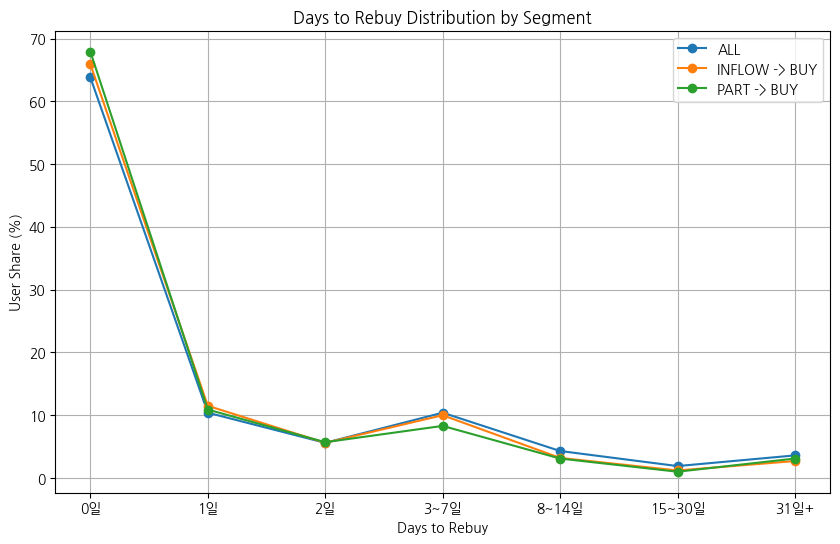

In [ ]:
print(dist.head())

plt.figure(figsize=(10,6))

for col in dist.columns:
    plt.plot(dist.index, dist[col], marker='o', label=col)

plt.title('Days to Rebuy Distribution by Segment')
plt.xlabel('Days to Rebuy')
plt.ylabel('User Share (%)')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
def make_dist_split_3_7(rebuy_df: pd.DataFrame) -> pd.Series:
    x = rebuy_df['days_to_rebuy'].dropna().astype(int)
    bins = [-1, 0, 1, 2, 5, 7, 14, 30, np.inf]
    labels = ['0일', '1일', '2일', '3~5일', '6~7일', '8~14일', '15~30일', '31일+']

    cat = pd.cut(x, bins=bins, labels=labels)
    share = cat.value_counts(normalize=True).reindex(labels).fillna(0) * 100
    return share

dist2 = pd.DataFrame({
    'ALL': make_dist_split_3_7(rebuy_all),
    'INFLOW -> BUY': make_dist_split_3_7(rebuy_inflow),
    'PART -> BUY': make_dist_split_3_7(rebuy_part),
})

print(dist2)


                ALL  INFLOW -> BUY  PART -> BUY
days_to_rebuy                                  
0일            63.81          65.85        67.88
1일            10.43          11.50        10.88
2일             5.64           5.65         5.70
3~5일           7.84           7.64         5.70
6~7일           2.54           2.32         2.59
8~14일          4.31           3.18         3.11
15~30일         1.85           1.15         1.04
31일+           3.57           2.71         3.11


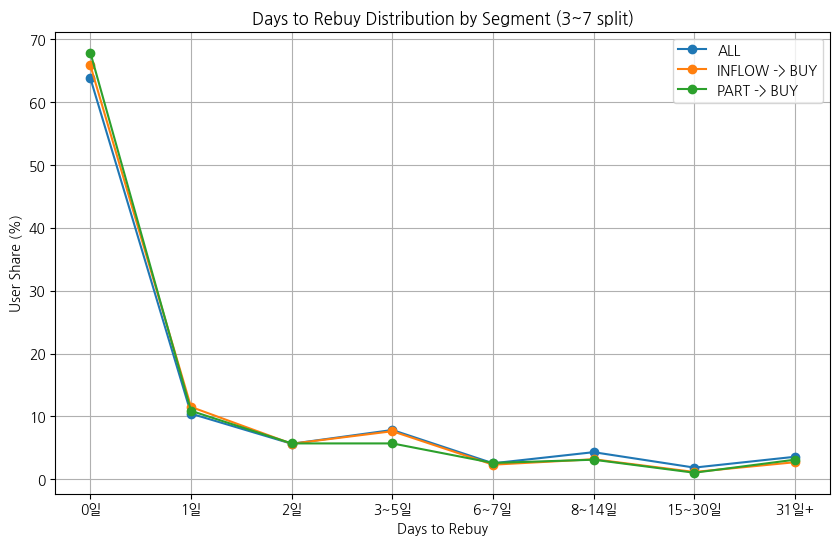

In [ ]:
plt.figure(figsize=(10,6))
for col in dist2.columns:
    plt.plot(dist2.index, dist2[col], marker='o', label=col)

plt.title('Days to Rebuy Distribution by Segment (3~7 split)')
plt.xlabel('Days to Rebuy')
plt.ylabel('User Share (%)')
plt.legend()
plt.grid(True)

labels = list(dist2.index)
idx_1d = labels.index('1일')
idx_3_5 = labels.index('3~5일')

plt.show()

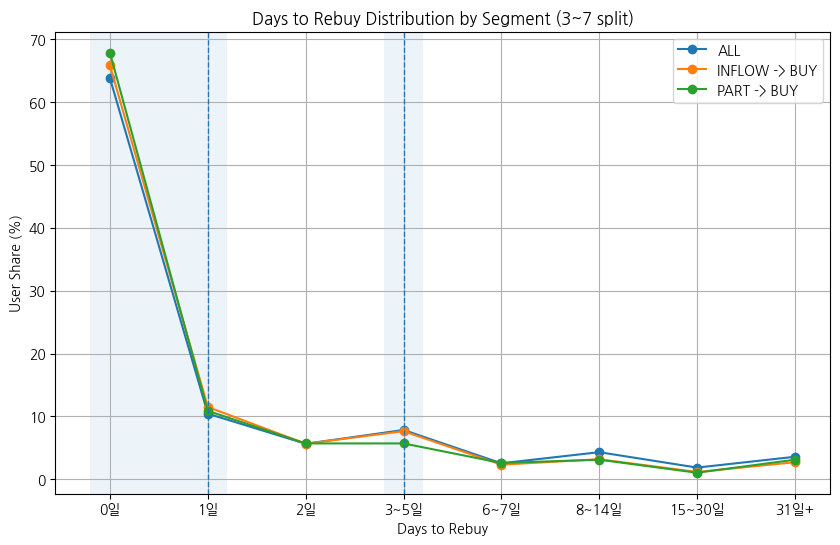

In [ ]:
plt.figure(figsize=(10,6))
for col in dist2.columns:
    plt.plot(dist2.index, dist2[col], marker='o', label=col)

plt.title('Days to Rebuy Distribution by Segment (3~7 split)')
plt.xlabel('Days to Rebuy')
plt.ylabel('User Share (%)')
plt.legend()
plt.grid(True)

labels = list(dist2.index)
idx_1d = labels.index('1일')
idx_3_5 = labels.index('3~5일')

plt.axvline(idx_1d, linestyle='--', linewidth=1)
plt.axvline(idx_3_5, linestyle='--', linewidth=1)

plt.axvspan(-0.2, idx_1d + 0.2, alpha=0.08)
plt.axvspan(idx_3_5 - 0.2, idx_3_5 + 0.2, alpha=0.08)

plt.show()

### 4) 세그먼트 분석

In [ ]:
pay_sorted = pay.sort_values(['user_id', 'created_at']).copy()
pay_sorted['order'] = pay_sorted.groupby('user_id').cumcount() + 1

user_tx = pay_sorted.groupby('user_id').size().rename('tx').reset_index()

first_buy  = pay_sorted.loc[pay_sorted['order'] == 1, ['user_id', 'created_at']].rename(columns={'created_at':'first_buy_at'})
second_buy = pay_sorted.loc[pay_sorted['order'] == 2, ['user_id', 'created_at']].rename(columns={'created_at':'second_buy_at'})

pay_sorted['buy_date'] = pay_sorted['created_at'].dt.date
active_days = pay_sorted.groupby('user_id')['buy_date'].nunique().rename('buy_active_days').reset_index()

minmax = pay_sorted.groupby('user_id')['created_at'].agg(['min','max']).reset_index()
minmax['buy_span_days'] = (minmax['max'] - minmax['min']).dt.days
minmax = minmax.drop(columns=['min','max'])

feat = user_tx.merge(first_buy, on='user_id', how='left') \
              .merge(second_buy, on='user_id', how='left') \
              .merge(active_days, on='user_id', how='left') \
              .merge(minmax, on='user_id', how='left')

feat['days_to_rebuy'] = (feat['second_buy_at'] - feat['first_buy_at']).dt.days

feat['tx_per_active_day'] = feat['tx'] / feat['buy_active_days'].replace(0, np.nan)
feat['is_rebuyer'] = feat['tx'] >= 2

In [ ]:
def assign_segment(row):
    tx = row['tx']
    d2 = row['days_to_rebuy']
    span = row['buy_span_days']
    dens = row['tx_per_active_day']

    if tx == 1:
        return 'one buy (1회구매)'

    if pd.notna(d2) and d2 <= 1:
        if pd.notna(span) and span <= 3 and pd.notna(dens) and dens >= 1.2:
            return 'vip (초단기 몰아구매)'
        return 'quick rebuy (즉시 재구매)'

    if pd.notna(d2) and 2 <= d2 <= 7:
        return 'normal rebuy (1주 내 재구매)'

    if pd.notna(d2) and d2 >= 8:
        if tx >= 3:
            return 'slow royalty (늦지만 꾸준)'
        return 'slow rebuy (늦은 재구매)'

    return 'unknown'

feat['segment'] = feat.apply(assign_segment, axis=1)

In [ ]:
def cohort_summary(feat_df, cohort_name, user_set=None):
    if user_set is not None:
        sub = feat_df[feat_df['user_id'].isin(user_set)].copy()
    else:
        sub = feat_df.copy()

    seg_cnt = sub['segment'].value_counts().rename('users').reset_index().rename(columns={'index':'segment'})
    seg_cnt['cohort'] = cohort_name
    seg_cnt['share'] = seg_cnt['users'] / seg_cnt['users'].sum()

    reb = sub[sub['tx'] >= 2].copy()
    if len(reb) > 0:
        timing = {
            'rebuy_users(2+)': len(reb),
            'median_days': float(reb['days_to_rebuy'].median()),
            'p75_days': float(reb['days_to_rebuy'].quantile(0.75)),
            'p90_days': float(reb['days_to_rebuy'].quantile(0.90)),
            'share_0d': float((reb['days_to_rebuy'] == 0).mean()),
            'share_le_1d': float((reb['days_to_rebuy'] <= 1).mean()),
            'share_le_2d': float((reb['days_to_rebuy'] <= 2).mean()),
            'share_le_3d': float((reb['days_to_rebuy'] <= 3).mean()),
            'share_le_7d': float((reb['days_to_rebuy'] <= 7).mean()),
        }
    else:
        timing = {
            'rebuy_users(2+)': 0,
            'median_days': np.nan,
            'p75_days': np.nan,
            'p90_days': np.nan,
            'share_0d': np.nan,
            'share_le_1d': np.nan,
            'share_le_2d': np.nan,
            'share_le_3d': np.nan,
            'share_le_7d': np.nan,
        }

    timing_df = pd.DataFrame([{'cohort': cohort_name, **timing}])
    return seg_cnt, timing_df

seg_all, timing_all       = cohort_summary(feat, 'ALL', None)
seg_inflow, timing_inflow = cohort_summary(feat, 'INFLOW -> BUY', inflow_buyers)
seg_part, timing_part     = cohort_summary(feat, 'PART -> BUY', part_buyers)

seg_table = pd.concat([seg_all, seg_inflow, seg_part], ignore_index=True)
timing_table = pd.concat([timing_all, timing_inflow, timing_part], ignore_index=True)

print('Segment Share Table')
print(seg_table.sort_values(['cohort','share'], ascending=[True, False]))

print('\nRebuy Timing Table')
print(timing_table)


Segment Share Table
                    segment  users         cohort  share
0            one buy (1회구매)  43050            ALL   0.73
1            vip (초단기 몰아구매)   7764            ALL   0.13
2      quick rebuy (즉시 재구매)   4220            ALL   0.07
3   normal rebuy (1주 내 재구매)   2586            ALL   0.04
4       slow rebuy (늦은 재구매)   1092            ALL   0.02
5     slow royalty (늦지만 꾸준)    479            ALL   0.01
6            one buy (1회구매)  24398  INFLOW -> BUY   0.71
7            vip (초단기 몰아구매)   4921  INFLOW -> BUY   0.14
8      quick rebuy (즉시 재구매)   2792  INFLOW -> BUY   0.08
9   normal rebuy (1주 내 재구매)   1556  INFLOW -> BUY   0.05
10      slow rebuy (늦은 재구매)    499  INFLOW -> BUY   0.01
11    slow royalty (늦지만 꾸준)    203  INFLOW -> BUY   0.01
12           one buy (1회구매)    480    PART -> BUY   0.71
13           vip (초단기 몰아구매)     90    PART -> BUY   0.13
14     quick rebuy (즉시 재구매)     62    PART -> BUY   0.09
15  normal rebuy (1주 내 재구매)     27    PART -> BUY   0.04
16      slo

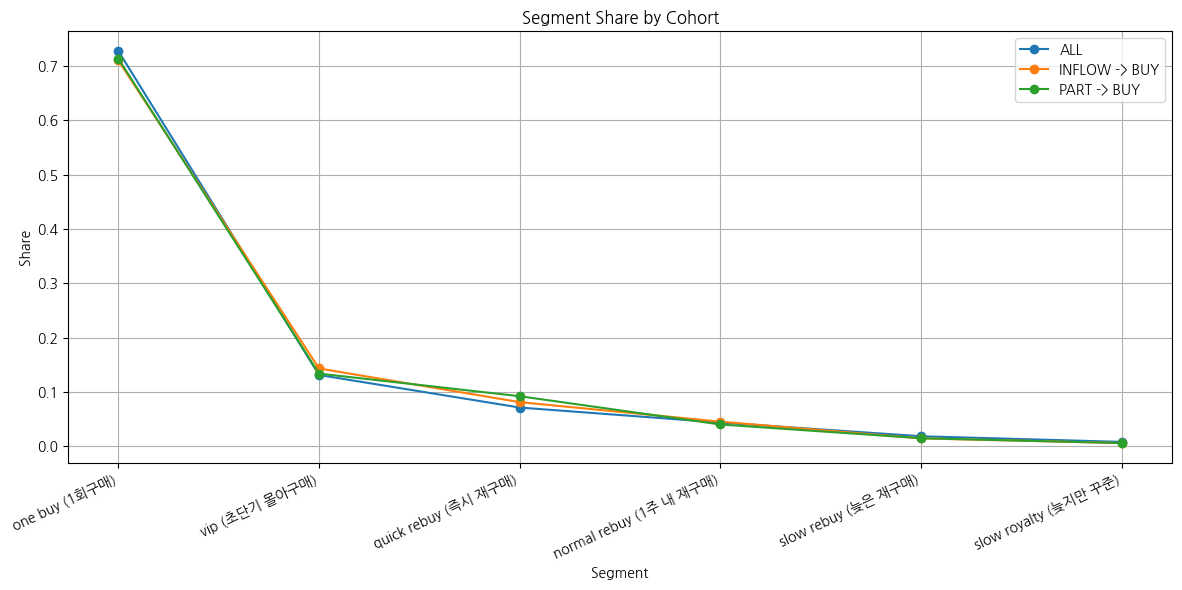

In [ ]:
pivot_share = seg_table.pivot_table(index='segment', columns='cohort', values='share', fill_value=0).sort_values('ALL', ascending=False)

plt.figure(figsize=(12,6))
for col in pivot_share.columns:
    plt.plot(pivot_share.index, pivot_share[col].values, marker='o', label=col)
plt.title('Segment Share by Cohort')
plt.xlabel('Segment')
plt.ylabel('Share')
plt.xticks(rotation=25, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

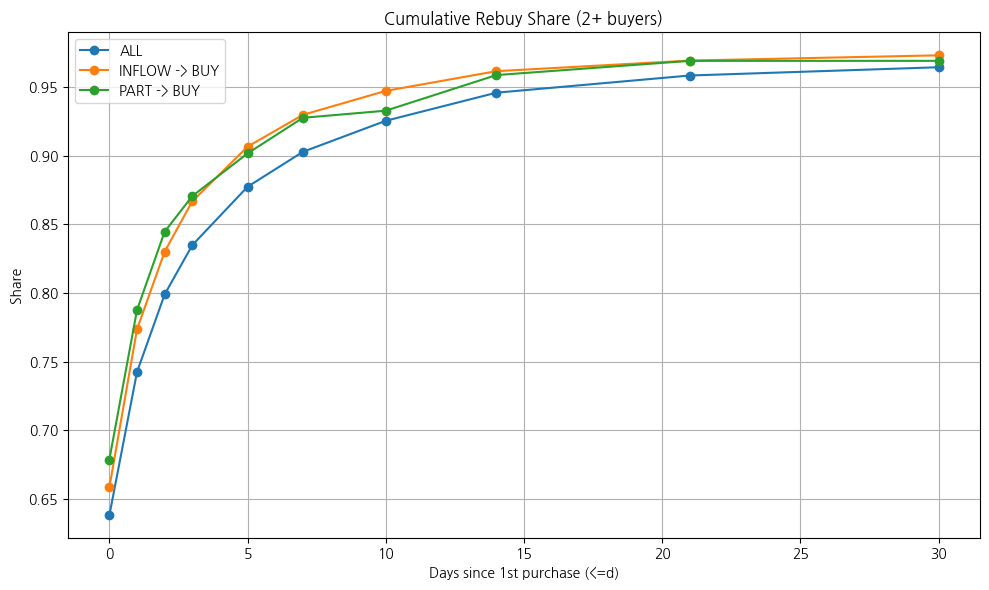

In [ ]:
days_list = [0,1,2,3,5,7,10,14,21,30]

def cum_rebuy_curve(feat_df, cohort_name, user_set=None):
    if user_set is not None:
        sub = feat_df[feat_df['user_id'].isin(user_set)].copy()
    else:
        sub = feat_df.copy()

    reb = sub[sub['tx'] >= 2].copy()
    y = []
    for d in days_list:
        y.append((reb['days_to_rebuy'] <= d).mean() if len(reb) > 0 else np.nan)
    return pd.Series(y, index=days_list, name=cohort_name)

curve_all = cum_rebuy_curve(feat, 'ALL', None)
curve_inflow = cum_rebuy_curve(feat, 'INFLOW -> BUY', inflow_buyers)
curve_part = cum_rebuy_curve(feat, 'PART -> BUY', part_buyers)

curves = pd.concat([curve_all, curve_inflow, curve_part], axis=1)

plt.figure(figsize=(10,6))
for col in curves.columns:
    plt.plot(curves.index, curves[col], marker='o', label=col)
plt.title('Cumulative Rebuy Share (2+ buyers)')
plt.xlabel('Days since 1st purchase (<=d)')
plt.ylabel('Share')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()